<a href="https://colab.research.google.com/github/AI4Finance-LLC/FinRL/blob/master/FinRL_ensemble_stock_trading_ICAIF_2020.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Reinforcement Learning for Stock Trading from Scratch: Multiple Stock Trading Using Ensemble Strategy

Tutorials to use OpenAI DRL to trade multiple stocks using ensemble strategy in one Jupyter Notebook | Presented at ICAIF 2020

* This notebook is the reimplementation of our paper: Deep Reinforcement Learning for Automated Stock Trading: An Ensemble Strategy, using FinRL.
* Check out medium blog for detailed explanations: https://medium.com/@ai4finance/deep-reinforcement-learning-for-automated-stock-trading-f1dad0126a02
* Please report any issues to our Github: https://github.com/AI4Finance-LLC/FinRL-Library/issues
* **Pytorch Version** 



# Content

* [1. Problem Definition](#0)
* [2. Getting Started - Load Python packages](#1)
    * [2.1. Install Packages](#1.1)    
    * [2.2. Check Additional Packages](#1.2)
    * [2.3. Import Packages](#1.3)
    * [2.4. Create Folders](#1.4)
* [3. Download Data](#2)
* [4. Preprocess Data](#3)        
    * [4.1. Technical Indicators](#3.1)
    * [4.2. Perform Feature Engineering](#3.2)
* [5.Build Environment](#4)  
    * [5.1. Training & Trade Data Split](#4.1)
    * [5.2. User-defined Environment](#4.2)   
    * [5.3. Initialize Environment](#4.3)    
* [6.Implement DRL Algorithms](#5)  
* [7.Backtesting Performance](#6)  
    * [7.1. BackTestStats](#6.1)
    * [7.2. BackTestPlot](#6.2)   
    * [7.3. Baseline Stats](#6.3)   
    * [7.3. Compare to Stock Market Index](#6.4)             

<a id='0'></a>
# Part 1. Problem Definition

This problem is to design an automated trading solution for single stock trading. We model the stock trading process as a Markov Decision Process (MDP). We then formulate our trading goal as a maximization problem.

The algorithm is trained using Deep Reinforcement Learning (DRL) algorithms and the components of the reinforcement learning environment are:


* Action: The action space describes the allowed actions that the agent interacts with the
environment. Normally, a ∈ A includes three actions: a ∈ {−1, 0, 1}, where −1, 0, 1 represent
selling, holding, and buying one stock. Also, an action can be carried upon multiple shares. We use
an action space {−k, ..., −1, 0, 1, ..., k}, where k denotes the number of shares. For example, "Buy
10 shares of AAPL" or "Sell 10 shares of AAPL" are 10 or −10, respectively

* Reward function: r(s, a, s′) is the incentive mechanism for an agent to learn a better action. The change of the portfolio value when action a is taken at state s and arriving at new state s',  i.e., r(s, a, s′) = v′ − v, where v′ and v represent the portfolio
values at state s′ and s, respectively

* State: The state space describes the observations that the agent receives from the environment. Just as a human trader needs to analyze various information before executing a trade, so
our trading agent observes many different features to better learn in an interactive environment.

* Environment: Dow 30 consituents


The data of the single stock that we will be using for this case study is obtained from Yahoo Finance API. The data contains Open-High-Low-Close price and volume.


<a id='1'></a>
# Part 2. Getting Started- Load Python Packages

<a id='1.1'></a>
## 2.1. Install all the packages through FinRL library


In [1]:
## install finrl library
# !pip3 install git+https://github.com/AI4Finance-LLC/FinRL-Library.git

In [2]:
import sys
sys.path

['/Users/evienguyen/Documents/FinRL/FinRL',
 '/usr/local/Cellar/python@3.9/3.9.1_6/Frameworks/Python.framework/Versions/3.9/lib/python39.zip',
 '/usr/local/Cellar/python@3.9/3.9.1_6/Frameworks/Python.framework/Versions/3.9/lib/python3.9',
 '/usr/local/Cellar/python@3.9/3.9.1_6/Frameworks/Python.framework/Versions/3.9/lib/python3.9/lib-dynload',
 '',
 '/Users/evienguyen/Library/Python/3.9/lib/python/site-packages',
 '/usr/local/lib/python3.9/site-packages',
 '/Users/evienguyen/Library/Python/3.9/lib/python/site-packages/IPython/extensions',
 '/Users/evienguyen/.ipython']

In [3]:
# ensemble_agent.print_test()
import os
os.chdir('/Users/evienguyen/Documents/FinRL/FinRL/finrl')
os.getcwd()

'/Users/evienguyen/Documents/FinRL/FinRL/finrl'


<a id='1.2'></a>
## 2.2. Check if the additional packages needed are present, if not install them. 
* Yahoo Finance API
* pandas
* numpy
* matplotlib
* stockstats
* OpenAI gym
* stable-baselines
* tensorflow
* pyfolio

<a id='1.3'></a>
## 2.3. Import Packages

In [4]:
import warnings
warnings.filterwarnings("ignore")

In [5]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
# matplotlib.use('Agg')
import datetime

%matplotlib inline
from finrl.config import config
from finrl.marketdata.yahoodownloader import YahooDownloader
from finrl.preprocessing.preprocessors import FeatureEngineer
from finrl.preprocessing.data import data_split
from finrl.env.env_stocktrading import StockTradingEnv
from finrl.model.models import DRLAgent,DRLEnsembleAgent
from finrl.trade.backtest import backtest_stats, backtest_plot, get_daily_return, get_baseline

from pprint import pprint

# import sys
# sys.path.append("../FinRL-Library")

import itertools

In [6]:
 print (dir(DRLEnsembleAgent))

['DRL_prediction', 'DRL_validation', '__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', 'get_model', 'get_validation_sharpe', 'print_test', 'run_ensemble_strategy', 'train_model']


<a id='1.4'></a>
## 2.4. Create Folders

In [7]:
import os
if not os.path.exists("./" + config.DATA_SAVE_DIR):
    os.makedirs("./" + config.DATA_SAVE_DIR)
if not os.path.exists("./" + config.TRAINED_MODEL_DIR):
    os.makedirs("./" + config.TRAINED_MODEL_DIR)
if not os.path.exists("./" + config.TENSORBOARD_LOG_DIR):
    os.makedirs("./" + config.TENSORBOARD_LOG_DIR)
if not os.path.exists("./" + config.RESULTS_DIR):
    os.makedirs("./" + config.RESULTS_DIR)

In [8]:
import sys
sys.path.append("../Users/evienguyen/Documents/FinRL/FinRL/finrl")

<a id='2'></a>
# Part 3. Download Data
Yahoo Finance is a website that provides stock data, financial news, financial reports, etc. All the data provided by Yahoo Finance is free.
* FinRL uses a class **YahooDownloader** to fetch data from Yahoo Finance API
* Call Limit: Using the Public API (without authentication), you are limited to 2,000 requests per hour per IP (or up to a total of 48,000 requests a day).




-----
class YahooDownloader:
    Provides methods for retrieving daily stock data from
    Yahoo Finance API

    Attributes
    ----------
        start_date : str
            start date of the data (modified from config.py)
        end_date : str
            end date of the data (modified from config.py)
        ticker_list : list
            a list of stock tickers (modified from config.py)

    Methods
    -------
    fetch_data()
        Fetches data from yahoo API


In [9]:
# from config.py start_date is a string
config.START_DATE

'2000-01-01'

In [10]:
print(config.DOW_30_TICKER)

['AAPL', 'MSFT', 'JPM', 'V', 'RTX', 'PG', 'GS', 'NKE', 'DIS', 'AXP', 'HD', 'INTC', 'WMT', 'IBM', 'MRK', 'UNH', 'KO', 'CAT', 'TRV', 'JNJ', 'CVX', 'MCD', 'VZ', 'CSCO', 'XOM', 'BA', 'MMM', 'PFE', 'WBA', 'DD']


In [11]:
df = YahooDownloader(start_date = '2009-01-01',
                     end_date = '2021-06-14',
                     ticker_list = config.DOW_30_TICKER).fetch_data()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

In [12]:
df.head()

,date,open,high,low,close,volume,tic,day
0,2009-01-02,3.067143,3.251429,3.041429,2.787006,746015200.0,AAPL,4
1,2009-01-02,18.570000,19.520000,18.400000,15.698216,10955700.0,AXP,4
2,2009-01-02,42.799999,45.560001,42.779999,33.941101,7010200.0,BA,4
3,2009-01-02,44.910000,46.980000,44.709999,32.830360,7117200.0,CAT,4
4,2009-01-02,16.410000,17.000000,16.250000,12.592946,40980600.0,CSCO,4


In [13]:
df.tail()

,date,open,high,low,close,volume,tic,day
93955,2021-06-11,234.389999,235.440002,233.710007,234.960007,5376500.0,V,4
93956,2021-06-11,57.490002,57.549999,57.009998,57.330002,12924100.0,VZ,4
93957,2021-06-11,55.580002,55.820000,54.810001,55.310001,3942600.0,WBA,4
93958,2021-06-11,140.229996,140.850006,139.860001,140.750000,8408800.0,WMT,4
93959,2021-06-11,63.009998,63.189999,62.139999,62.169998,17618900.0,XOM,4


In [14]:
df.shape

(93960, 8)

In [15]:
df.sort_values(['date','tic']).head()

,date,open,high,low,close,volume,tic,day
0,2009-01-02,3.067143,3.251429,3.041429,2.787006,746015200.0,AAPL,4
1,2009-01-02,18.570000,19.520000,18.400000,15.698216,10955700.0,AXP,4
2,2009-01-02,42.799999,45.560001,42.779999,33.941101,7010200.0,BA,4
3,2009-01-02,44.910000,46.980000,44.709999,32.830360,7117200.0,CAT,4
4,2009-01-02,16.410000,17.000000,16.250000,12.592946,40980600.0,CSCO,4


# Part 4: Preprocess Data
Data preprocessing is a crucial step for training a high quality machine learning model. We need to check for missing data and do feature engineering in order to convert the data into a model-ready state.
* Add technical indicators. In practical trading, various information needs to be taken into account, for example the historical stock prices, current holding shares, technical indicators, etc. In this article, we demonstrate two trend-following technical indicators: MACD and RSI.
* Add turbulence index. Risk-aversion reflects whether an investor will choose to preserve the capital. It also influences one's trading strategy when facing different market volatility level. To control the risk in a worst-case scenario, such as financial crisis of 2007–2008, FinRL employs the financial turbulence index that measures extreme asset price fluctuation.

In [16]:
fe = FeatureEngineer(
                    use_technical_indicator=True,
                    tech_indicator_list = config.TECHNICAL_INDICATORS_LIST,
                    use_turbulence=True,
                    user_defined_feature = False)

processed = fe.preprocess_data(df)

Successfully added technical indicators
Successfully added turbulence index


In [17]:
list_ticker = processed["tic"].unique().tolist()
list_date = list(pd.date_range(processed['date'].min(),processed['date'].max()).astype(str))
combination = list(itertools.product(list_date,list_ticker))

processed_full = pd.DataFrame(combination,columns=["date","tic"]).merge(processed,on=["date","tic"],how="left")
processed_full = processed_full[processed_full['date'].isin(processed['date'])]
processed_full = processed_full.sort_values(['date','tic'])

processed_full = processed_full.fillna(0)

In [18]:
processed_full.sample(5)

,date,tic,open,high,low,close,volume,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,turbulence
24693,2011-04-05,CAT,112.970001,113.160004,111.910004,84.560265,5338700.0,1.0,2.299634,87.505242,73.049325,64.641667,126.048630,27.799825,79.114903,76.458168,20.292536
24350,2011-03-24,PFE,18.975332,19.316889,18.795067,13.207226,52057692.0,3.0,0.198473,13.253991,12.295813,63.123851,136.845186,42.749706,12.644674,12.254671,23.161591
42987,2012-12-04,WBA,34.279999,34.570000,34.110001,27.658207,7172000.0,1.0,-0.107974,27.725511,25.638209,51.229074,31.613873,21.146905,27.212261,27.981085,20.886531
53075,2013-11-06,CVX,119.300003,121.410004,118.820000,87.153542,8373200.0,2.0,-0.183056,87.892443,83.998732,51.535965,39.704693,0.493765,86.000267,86.811443,34.394919
25784,2011-05-11,KO,33.645000,33.834999,33.450001,24.460611,11215400.0,2.0,0.094132,24.812551,24.186423,56.335844,0.775246,7.320447,24.464363,23.858302,66.918068


<AxesSubplot:xlabel='date'>

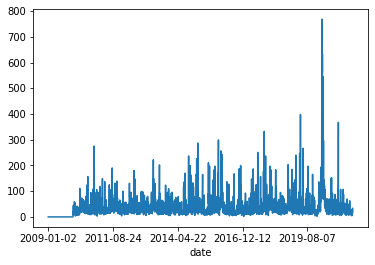

In [19]:
processed_full_copy = processed_full
processed_full_copy.set_index('date',inplace=True)
%matplotlib inline
processed_full_copy.turbulence.plot()


<a id='4'></a>
# Part 5. Design Environment
Considering the stochastic and interactive nature of the automated stock trading tasks, a financial task is modeled as a **Markov Decision Process (MDP)** problem. The training process involves observing stock price change, taking an action and reward's calculation to have the agent adjusting its strategy accordingly. By interacting with the environment, the trading agent will derive a trading strategy with the maximized rewards as time proceeds.

Our trading environments, based on OpenAI Gym framework, simulate live stock markets with real market data according to the principle of time-driven simulation.

The action space describes the allowed actions that the agent interacts with the environment. Normally, action a includes three actions: {-1, 0, 1}, where -1, 0, 1 represent selling, holding, and buying one share. Also, an action can be carried upon multiple shares. We use an action space {-k,…,-1, 0, 1, …, k}, where k denotes the number of shares to buy and -k denotes the number of shares to sell. For example, "Buy 10 shares of AAPL" or "Sell 10 shares of AAPL" are 10 or -10, respectively. The continuous action space needs to be normalized to [-1, 1], since the policy is defined on a Gaussian distribution, which needs to be normalized and symmetric.

In [20]:
config.TECHNICAL_INDICATORS_LIST

['macd',
 'boll_ub',
 'boll_lb',
 'rsi_30',
 'cci_30',
 'dx_30',
 'close_30_sma',
 'close_60_sma']

In [21]:
stock_dimension = len(processed_full.tic.unique())
state_space = 1 + 2*stock_dimension + len(config.TECHNICAL_INDICATORS_LIST)*stock_dimension
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")


Stock Dimension: 30, State Space: 301


In [22]:
env_kwargs = {
    "hmax": 100, 
    "initial_amount": 1000000, 
    "buy_cost_pct": 0.001, 
    "sell_cost_pct": 0.001, 
    "state_space": state_space, 
    "stock_dim": stock_dimension, 
    "tech_indicator_list": config.TECHNICAL_INDICATORS_LIST, 
    "action_space": stock_dimension, 
    "reward_scaling": 1e-4,
    "print_verbosity":5
    
}

In [23]:
processed_full.reset_index(inplace=True)

<a id='5'></a>
# Part 6: Implement DRL Algorithms
* The implementation of the DRL algorithms are based on **OpenAI Baselines** and **Stable Baselines**. Stable Baselines is a fork of OpenAI Baselines, with a major structural refactoring, and code cleanups.
* FinRL library includes fine-tuned standard DRL algorithms, such as DQN, DDPG,
Multi-Agent DDPG, PPO, SAC, A2C and TD3. We also allow users to
design their own DRL algorithms by adapting these DRL algorithms.

* In this notebook, we are training and validating 3 agents (A2C, PPO, DDPG) using Rolling-window Ensemble Method ([reference code](https://github.com/AI4Finance-LLC/Deep-Reinforcement-Learning-for-Automated-Stock-Trading-Ensemble-Strategy-ICAIF-2020/blob/80415db8fa7b2179df6bd7e81ce4fe8dbf913806/model/models.py#L92))

In [24]:
rebalance_window = 63 # rebalance_window is the number of days to retrain the model
validation_window = 63 # validation_window is the number of days to do validation and trading (e.g. if validation_window=63, then both validation and trading period will be 63 days)
train_start = '2009-01-01'
train_end = '2015-10-01'
val_test_start = '2015-10-01'
val_test_end = '2021-06-14'

ensemble_agent = DRLEnsembleAgent(df=processed_full,
                 train_period=(train_start,train_end),
                 val_test_period=(val_test_start,val_test_end),
                 rebalance_window=rebalance_window, 
                 validation_window=validation_window, 
                 **env_kwargs)

In [25]:
A2C_model_kwargs = {
                    'n_steps': 5,
                    'ent_coef': 0.01,
                    'learning_rate': 0.0005
                    }

PPO_model_kwargs = {
                    "ent_coef":0.01,
                    "n_steps": 2048,
                    "learning_rate": 0.00025,
                    "batch_size": 128
                    }

DDPG_model_kwargs = {
                      "action_noise":"ornstein_uhlenbeck",
                      "buffer_size": 50_000,
                      "learning_rate": 0.000005,
                      "batch_size": 128
                    }

timesteps_dict = {'a2c' : 30_000, 
                 'ppo' : 100_000, 
                 'ddpg' : 10_000
                 }

In [26]:
df_summary = ensemble_agent.run_ensemble_strategy(A2C_model_kwargs,
                                                 PPO_model_kwargs,
                                                 DDPG_model_kwargs,
                                                 timesteps_dict)

============Start Ensemble Strategy============
39.45621665227606
turbulence_threshold:  286.9563664825805
======Model training from:  2009-01-01 to  2015-10-02
======A2C Training========
{'n_steps': 5, 'ent_coef': 0.01, 'learning_rate': 0.0005}
Using cpu device
Logging to tensorboard_log/a2c/a2c_126_5
------------------------------------
| time/                 |          |
|    fps                | 106      |
|    iterations         | 100      |
|    time_elapsed       | 4        |
|    total_timesteps    | 500      |
| train/                |          |
|    entropy_loss       | -42.6    |
|    explained_variance | -0.745   |
|    learning_rate      | 0.0005   |
|    n_updates          | 99       |
|    policy_loss        | -114     |
|    std                | 1        |
|    value_loss         | 9.38     |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 126      |
|    iterations         | 200 

------------------------------------
| environment/          |          |
|    portfolio_value    | 2.54e+06 |
|    total_cost         | 1e+04    |
|    total_reward       | 1.54e+06 |
|    total_reward_pct   | 154      |
|    total_trades       | 28747    |
| time/                 |          |
|    fps                | 142      |
|    iterations         | 1400     |
|    time_elapsed       | 49       |
|    total_timesteps    | 7000     |
| train/                |          |
|    entropy_loss       | -42.8    |
|    explained_variance | 0        |
|    learning_rate      | 0.0005   |
|    n_updates          | 1399     |
|    policy_loss        | 50.7     |
|    std                | 1.01     |
|    value_loss         | 3.07     |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 143      |
|    iterations         | 1500     |
|    time_elapsed       | 52       |
|    total_timesteps    | 7500     |
|

------------------------------------
| time/                 |          |
|    fps                | 146      |
|    iterations         | 2700     |
|    time_elapsed       | 91       |
|    total_timesteps    | 13500    |
| train/                |          |
|    entropy_loss       | -42.9    |
|    explained_variance | 0        |
|    learning_rate      | 0.0005   |
|    n_updates          | 2699     |
|    policy_loss        | 33.6     |
|    std                | 1.01     |
|    value_loss         | 1.5      |
------------------------------------
------------------------------------
| environment/          |          |
|    portfolio_value    | 2.13e+06 |
|    total_cost         | 3.55e+03 |
|    total_reward       | 1.13e+06 |
|    total_reward_pct   | 113      |
|    total_trades       | 24124    |
| time/                 |          |
|    fps                | 147      |
|    iterations         | 2800     |
|    time_elapsed       | 95       |
|    total_timesteps    | 14000    |
|

------------------------------------
| time/                 |          |
|    fps                | 150      |
|    iterations         | 4000     |
|    time_elapsed       | 133      |
|    total_timesteps    | 20000    |
| train/                |          |
|    entropy_loss       | -43.1    |
|    explained_variance | 0        |
|    learning_rate      | 0.0005   |
|    n_updates          | 3999     |
|    policy_loss        | -234     |
|    std                | 1.02     |
|    value_loss         | 29.7     |
------------------------------------
------------------------------------
| environment/          |          |
|    portfolio_value    | 3.17e+06 |
|    total_cost         | 2.43e+04 |
|    total_reward       | 2.17e+06 |
|    total_reward_pct   | 217      |
|    total_trades       | 29252    |
| time/                 |          |
|    fps                | 150      |
|    iterations         | 4100     |
|    time_elapsed       | 136      |
|    total_timesteps    | 20500    |
|

------------------------------------
| time/                 |          |
|    fps                | 150      |
|    iterations         | 5300     |
|    time_elapsed       | 175      |
|    total_timesteps    | 26500    |
| train/                |          |
|    entropy_loss       | -43.2    |
|    explained_variance | 0        |
|    learning_rate      | 0.0005   |
|    n_updates          | 5299     |
|    policy_loss        | -1.86    |
|    std                | 1.02     |
|    value_loss         | 7.51     |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 150      |
|    iterations         | 5400     |
|    time_elapsed       | 179      |
|    total_timesteps    | 27000    |
| train/                |          |
|    entropy_loss       | -43.3    |
|    explained_variance | 0        |
|    learning_rate      | 0.0005   |
|    n_updates          | 5399     |
|    policy_loss        | -154     |
|

-----------------------------------------
| environment/            |             |
|    portfolio_value      | 2.02e+06    |
|    total_cost           | 1.4e+05     |
|    total_reward         | 1.02e+06    |
|    total_reward_pct     | 102         |
|    total_trades         | 48744       |
| time/                   |             |
|    fps                  | 159         |
|    iterations           | 5           |
|    time_elapsed         | 64          |
|    total_timesteps      | 10240       |
| train/                  |             |
|    approx_kl            | 0.020416902 |
|    clip_fraction        | 0.212       |
|    clip_range           | 0.2         |
|    entropy_loss         | -42.8       |
|    explained_variance   | 0.00204     |
|    learning_rate        | 0.00025     |
|    loss                 | 6.69        |
|    n_updates            | 40          |
|    policy_gradient_loss | -0.0284     |
|    std                  | 1.01        |
|    value_loss           | 14.7  

-----------------------------------------
| environment/            |             |
|    portfolio_value      | 2.19e+06    |
|    total_cost           | 1.35e+05    |
|    total_reward         | 1.19e+06    |
|    total_reward_pct     | 119         |
|    total_trades         | 48149       |
| time/                   |             |
|    fps                  | 160         |
|    iterations           | 13          |
|    time_elapsed         | 166         |
|    total_timesteps      | 26624       |
| train/                  |             |
|    approx_kl            | 0.026082704 |
|    clip_fraction        | 0.276       |
|    clip_range           | 0.2         |
|    entropy_loss         | -43.2       |
|    explained_variance   | 0.0201      |
|    learning_rate        | 0.00025     |
|    loss                 | 6.95        |
|    n_updates            | 120         |
|    policy_gradient_loss | -0.0228     |
|    std                  | 1.02        |
|    value_loss           | 12.5  

-----------------------------------------
| environment/            |             |
|    portfolio_value      | 1.71e+06    |
|    total_cost           | 1.18e+05    |
|    total_reward         | 7.09e+05    |
|    total_reward_pct     | 70.9        |
|    total_trades         | 46132       |
| time/                   |             |
|    fps                  | 159         |
|    iterations           | 21          |
|    time_elapsed         | 269         |
|    total_timesteps      | 43008       |
| train/                  |             |
|    approx_kl            | 0.027640468 |
|    clip_fraction        | 0.226       |
|    clip_range           | 0.2         |
|    entropy_loss         | -43.5       |
|    explained_variance   | 0.14        |
|    learning_rate        | 0.00025     |
|    loss                 | 10.6        |
|    n_updates            | 200         |
|    policy_gradient_loss | -0.0153     |
|    std                  | 1.04        |
|    value_loss           | 18.1  

-----------------------------------------
| environment/            |             |
|    portfolio_value      | 1.96e+06    |
|    total_cost           | 1.33e+05    |
|    total_reward         | 9.57e+05    |
|    total_reward_pct     | 95.7        |
|    total_trades         | 47505       |
| time/                   |             |
|    fps                  | 157         |
|    iterations           | 29          |
|    time_elapsed         | 377         |
|    total_timesteps      | 59392       |
| train/                  |             |
|    approx_kl            | 0.029512685 |
|    clip_fraction        | 0.254       |
|    clip_range           | 0.2         |
|    entropy_loss         | -43.9       |
|    explained_variance   | 0.113       |
|    learning_rate        | 0.00025     |
|    loss                 | 4.26        |
|    n_updates            | 280         |
|    policy_gradient_loss | -0.0178     |
|    std                  | 1.05        |
|    value_loss           | 12.6  

-----------------------------------------
| environment/            |             |
|    portfolio_value      | 2.09e+06    |
|    total_cost           | 1.33e+05    |
|    total_reward         | 1.09e+06    |
|    total_reward_pct     | 109         |
|    total_trades         | 47157       |
| time/                   |             |
|    fps                  | 157         |
|    iterations           | 37          |
|    time_elapsed         | 479         |
|    total_timesteps      | 75776       |
| train/                  |             |
|    approx_kl            | 0.026730875 |
|    clip_fraction        | 0.246       |
|    clip_range           | 0.2         |
|    entropy_loss         | -44.2       |
|    explained_variance   | 0.272       |
|    learning_rate        | 0.00025     |
|    loss                 | 8.56        |
|    n_updates            | 360         |
|    policy_gradient_loss | -0.018      |
|    std                  | 1.06        |
|    value_loss           | 18    

-----------------------------------------
| environment/            |             |
|    portfolio_value      | 2.45e+06    |
|    total_cost           | 1.25e+05    |
|    total_reward         | 1.45e+06    |
|    total_reward_pct     | 145         |
|    total_trades         | 45956       |
| time/                   |             |
|    fps                  | 158         |
|    iterations           | 45          |
|    time_elapsed         | 579         |
|    total_timesteps      | 92160       |
| train/                  |             |
|    approx_kl            | 0.048877567 |
|    clip_fraction        | 0.308       |
|    clip_range           | 0.2         |
|    entropy_loss         | -44.5       |
|    explained_variance   | 0.34        |
|    learning_rate        | 0.00025     |
|    loss                 | 6.92        |
|    n_updates            | 440         |
|    policy_gradient_loss | -0.00891    |
|    std                  | 1.07        |
|    value_loss           | 15.8  

------------------------------------
| time/                 |          |
|    fps                | 88       |
|    iterations         | 100      |
|    time_elapsed       | 5        |
|    total_timesteps    | 500      |
| train/                |          |
|    entropy_loss       | -42.6    |
|    explained_variance | 0.438    |
|    learning_rate      | 0.0005   |
|    n_updates          | 99       |
|    policy_loss        | -26.7    |
|    std                | 1        |
|    value_loss         | 0.457    |
------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 109       |
|    iterations         | 200       |
|    time_elapsed       | 9         |
|    total_timesteps    | 1000      |
| train/                |           |
|    entropy_loss       | -42.7     |
|    explained_variance | -1.19e-07 |
|    learning_rate      | 0.0005    |
|    n_updates          | 199       |
|    policy_loss        | -

------------------------------------
| environment/          |          |
|    portfolio_value    | 2.09e+06 |
|    total_cost         | 5.69e+04 |
|    total_reward       | 1.09e+06 |
|    total_reward_pct   | 109      |
|    total_trades       | 39889    |
| time/                 |          |
|    fps                | 143      |
|    iterations         | 1500     |
|    time_elapsed       | 52       |
|    total_timesteps    | 7500     |
| train/                |          |
|    entropy_loss       | -42.8    |
|    explained_variance | 0        |
|    learning_rate      | 0.0005   |
|    n_updates          | 1499     |
|    policy_loss        | 40.6     |
|    std                | 1.01     |
|    value_loss         | 1.09     |
------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 143       |
|    iterations         | 1600      |
|    time_elapsed       | 55        |
|    total_timesteps    | 8000   

-------------------------------------
| time/                 |           |
|    fps                | 146       |
|    iterations         | 2800      |
|    time_elapsed       | 95        |
|    total_timesteps    | 14000     |
| train/                |           |
|    entropy_loss       | -42.7     |
|    explained_variance | -1.19e-07 |
|    learning_rate      | 0.0005    |
|    n_updates          | 2799      |
|    policy_loss        | 80.7      |
|    std                | 1         |
|    value_loss         | 7.47      |
-------------------------------------
------------------------------------
| environment/          |          |
|    portfolio_value    | 5.05e+06 |
|    total_cost         | 6.54e+04 |
|    total_reward       | 4.05e+06 |
|    total_reward_pct   | 405      |
|    total_trades       | 37904    |
| time/                 |          |
|    fps                | 146      |
|    iterations         | 2900     |
|    time_elapsed       | 99       |
|    total_timesteps   

------------------------------------
| time/                 |          |
|    fps                | 146      |
|    iterations         | 4100     |
|    time_elapsed       | 139      |
|    total_timesteps    | 20500    |
| train/                |          |
|    entropy_loss       | -42.8    |
|    explained_variance | 0        |
|    learning_rate      | 0.0005   |
|    n_updates          | 4099     |
|    policy_loss        | 30.4     |
|    std                | 1.01     |
|    value_loss         | 10.1     |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 146      |
|    iterations         | 4200     |
|    time_elapsed       | 142      |
|    total_timesteps    | 21000    |
| train/                |          |
|    entropy_loss       | -42.9    |
|    explained_variance | 0        |
|    learning_rate      | 0.0005   |
|    n_updates          | 4199     |
|    policy_loss        | -18      |
|

------------------------------------
| time/                 |          |
|    fps                | 147      |
|    iterations         | 5400     |
|    time_elapsed       | 183      |
|    total_timesteps    | 27000    |
| train/                |          |
|    entropy_loss       | -42.9    |
|    explained_variance | 0        |
|    learning_rate      | 0.0005   |
|    n_updates          | 5399     |
|    policy_loss        | 13.4     |
|    std                | 1.01     |
|    value_loss         | 1.08     |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 147      |
|    iterations         | 5500     |
|    time_elapsed       | 186      |
|    total_timesteps    | 27500    |
| train/                |          |
|    entropy_loss       | -42.9    |
|    explained_variance | 0        |
|    learning_rate      | 0.0005   |
|    n_updates          | 5499     |
|    policy_loss        | -19.6    |
|

-----------------------------------------
| environment/            |             |
|    portfolio_value      | 2.1e+06     |
|    total_cost           | 1.5e+05     |
|    total_reward         | 1.1e+06     |
|    total_reward_pct     | 110         |
|    total_trades         | 50492       |
| time/                   |             |
|    fps                  | 150         |
|    iterations           | 5           |
|    time_elapsed         | 67          |
|    total_timesteps      | 10240       |
| train/                  |             |
|    approx_kl            | 0.020003146 |
|    clip_fraction        | 0.192       |
|    clip_range           | 0.2         |
|    entropy_loss         | -42.7       |
|    explained_variance   | -0.0266     |
|    learning_rate        | 0.00025     |
|    loss                 | 4.33        |
|    n_updates            | 40          |
|    policy_gradient_loss | -0.0248     |
|    std                  | 1           |
|    value_loss           | 9.64  

-----------------------------------------
| environment/            |             |
|    portfolio_value      | 2.23e+06    |
|    total_cost           | 1.45e+05    |
|    total_reward         | 1.23e+06    |
|    total_reward_pct     | 123         |
|    total_trades         | 49589       |
| time/                   |             |
|    fps                  | 150         |
|    iterations           | 13          |
|    time_elapsed         | 177         |
|    total_timesteps      | 26624       |
| train/                  |             |
|    approx_kl            | 0.019146422 |
|    clip_fraction        | 0.22        |
|    clip_range           | 0.2         |
|    entropy_loss         | -43.1       |
|    explained_variance   | 0.0357      |
|    learning_rate        | 0.00025     |
|    loss                 | 3.06        |
|    n_updates            | 120         |
|    policy_gradient_loss | -0.0288     |
|    std                  | 1.02        |
|    value_loss           | 9.65  

-----------------------------------------
| environment/            |             |
|    portfolio_value      | 2.16e+06    |
|    total_cost           | 1.41e+05    |
|    total_reward         | 1.16e+06    |
|    total_reward_pct     | 116         |
|    total_trades         | 49425       |
| time/                   |             |
|    fps                  | 151         |
|    iterations           | 21          |
|    time_elapsed         | 284         |
|    total_timesteps      | 43008       |
| train/                  |             |
|    approx_kl            | 0.045940384 |
|    clip_fraction        | 0.267       |
|    clip_range           | 0.2         |
|    entropy_loss         | -43.3       |
|    explained_variance   | 0.0533      |
|    learning_rate        | 0.00025     |
|    loss                 | 4.8         |
|    n_updates            | 200         |
|    policy_gradient_loss | -0.0101     |
|    std                  | 1.03        |
|    value_loss           | 8.53  

----------------------------------------
| environment/            |            |
|    portfolio_value      | 2.49e+06   |
|    total_cost           | 1.38e+05   |
|    total_reward         | 1.49e+06   |
|    total_reward_pct     | 149        |
|    total_trades         | 48898      |
| time/                   |            |
|    fps                  | 151        |
|    iterations           | 29         |
|    time_elapsed         | 391        |
|    total_timesteps      | 59392      |
| train/                  |            |
|    approx_kl            | 0.02820244 |
|    clip_fraction        | 0.212      |
|    clip_range           | 0.2        |
|    entropy_loss         | -43.7      |
|    explained_variance   | 0.0358     |
|    learning_rate        | 0.00025    |
|    loss                 | 5.57       |
|    n_updates            | 280        |
|    policy_gradient_loss | -0.0163    |
|    std                  | 1.04       |
|    value_loss           | 13.1       |
----------------

day: 1761, episode: 60
begin_total_asset: 1000000.00
end_total_asset: 2429573.30
total_reward: 1429573.30
total_cost: 132146.78
total_trades: 48594
Sharpe: 0.851
-----------------------------------------
| environment/            |             |
|    portfolio_value      | 2.66e+06    |
|    total_cost           | 1.35e+05    |
|    total_reward         | 1.66e+06    |
|    total_reward_pct     | 166         |
|    total_trades         | 48812       |
| time/                   |             |
|    fps                  | 152         |
|    iterations           | 37          |
|    time_elapsed         | 496         |
|    total_timesteps      | 75776       |
| train/                  |             |
|    approx_kl            | 0.028158605 |
|    clip_fraction        | 0.265       |
|    clip_range           | 0.2         |
|    entropy_loss         | -44.1       |
|    explained_variance   | 0.0606      |
|    learning_rate        | 0.00025     |
|    loss                 | 7.31        

day: 1761, episode: 70
begin_total_asset: 1000000.00
end_total_asset: 2883651.11
total_reward: 1883651.11
total_cost: 138798.51
total_trades: 48882
Sharpe: 1.070
----------------------------------------
| environment/            |            |
|    portfolio_value      | 2.88e+06   |
|    total_cost           | 1.39e+05   |
|    total_reward         | 1.88e+06   |
|    total_reward_pct     | 188        |
|    total_trades         | 48882      |
| time/                   |            |
|    fps                  | 152        |
|    iterations           | 45         |
|    time_elapsed         | 603        |
|    total_timesteps      | 92160      |
| train/                  |            |
|    approx_kl            | 0.03306766 |
|    clip_fraction        | 0.201      |
|    clip_range           | 0.2        |
|    entropy_loss         | -44.5      |
|    explained_variance   | 0.217      |
|    learning_rate        | 0.00025    |
|    loss                 | 6.14       |
|    n_updates    

-----------------------------------------
| environment/            |             |
|    portfolio_value      | 2.04e+06    |
|    total_cost           | 1.58e+05    |
|    total_reward         | 1.04e+06    |
|    total_reward_pct     | 104         |
|    total_trades         | 52713       |
| time/                   |             |
|    fps                  | 146         |
|    iterations           | 3           |
|    time_elapsed         | 41          |
|    total_timesteps      | 6144        |
| train/                  |             |
|    approx_kl            | 0.012179358 |
|    clip_fraction        | 0.236       |
|    clip_range           | 0.2         |
|    entropy_loss         | -42.7       |
|    explained_variance   | 0.0123      |
|    learning_rate        | 0.00025     |
|    loss                 | 4.59        |
|    n_updates            | 20          |
|    policy_gradient_loss | -0.0187     |
|    std                  | 1           |
|    value_loss           | 9.5   

----------------------------------------
| environment/            |            |
|    portfolio_value      | 1.91e+06   |
|    total_cost           | 1.5e+05    |
|    total_reward         | 9.1e+05    |
|    total_reward_pct     | 91         |
|    total_trades         | 51598      |
| time/                   |            |
|    fps                  | 147        |
|    iterations           | 11         |
|    time_elapsed         | 153        |
|    total_timesteps      | 22528      |
| train/                  |            |
|    approx_kl            | 0.02046095 |
|    clip_fraction        | 0.198      |
|    clip_range           | 0.2        |
|    entropy_loss         | -43.2      |
|    explained_variance   | 0.0186     |
|    learning_rate        | 0.00025    |
|    loss                 | 5.69       |
|    n_updates            | 100        |
|    policy_gradient_loss | -0.0193    |
|    std                  | 1.02       |
|    value_loss           | 14.4       |
----------------

-----------------------------------------
| environment/            |             |
|    portfolio_value      | 1.9e+06     |
|    total_cost           | 1.44e+05    |
|    total_reward         | 8.99e+05    |
|    total_reward_pct     | 89.9        |
|    total_trades         | 50534       |
| time/                   |             |
|    fps                  | 149         |
|    iterations           | 19          |
|    time_elapsed         | 260         |
|    total_timesteps      | 38912       |
| train/                  |             |
|    approx_kl            | 0.022111082 |
|    clip_fraction        | 0.247       |
|    clip_range           | 0.2         |
|    entropy_loss         | -43.6       |
|    explained_variance   | -0.000693   |
|    learning_rate        | 0.00025     |
|    loss                 | 6.81        |
|    n_updates            | 180         |
|    policy_gradient_loss | -0.0134     |
|    std                  | 1.04        |
|    value_loss           | 12.7  

day: 1824, episode: 30
begin_total_asset: 1000000.00
end_total_asset: 2789974.56
total_reward: 1789974.56
total_cost: 143299.18
total_trades: 50892
Sharpe: 0.953
-----------------------------------------
| environment/            |             |
|    portfolio_value      | 2.79e+06    |
|    total_cost           | 1.43e+05    |
|    total_reward         | 1.79e+06    |
|    total_reward_pct     | 179         |
|    total_trades         | 50892       |
| time/                   |             |
|    fps                  | 152         |
|    iterations           | 27          |
|    time_elapsed         | 363         |
|    total_timesteps      | 55296       |
| train/                  |             |
|    approx_kl            | 0.025775146 |
|    clip_fraction        | 0.288       |
|    clip_range           | 0.2         |
|    entropy_loss         | -44.1       |
|    explained_variance   | 0.0194      |
|    learning_rate        | 0.00025     |
|    loss                 | 7.99        

-----------------------------------------
| environment/            |             |
|    portfolio_value      | 2.62e+06    |
|    total_cost           | 1.4e+05     |
|    total_reward         | 1.62e+06    |
|    total_reward_pct     | 162         |
|    total_trades         | 50914       |
| time/                   |             |
|    fps                  | 153         |
|    iterations           | 35          |
|    time_elapsed         | 468         |
|    total_timesteps      | 71680       |
| train/                  |             |
|    approx_kl            | 0.024920922 |
|    clip_fraction        | 0.309       |
|    clip_range           | 0.2         |
|    entropy_loss         | -44.4       |
|    explained_variance   | 0.112       |
|    learning_rate        | 0.00025     |
|    loss                 | 5.19        |
|    n_updates            | 340         |
|    policy_gradient_loss | -0.0156     |
|    std                  | 1.06        |
|    value_loss           | 14.9  

----------------------------------------
| environment/            |            |
|    portfolio_value      | 3e+06      |
|    total_cost           | 1.3e+05    |
|    total_reward         | 2e+06      |
|    total_reward_pct     | 200        |
|    total_trades         | 49350      |
| time/                   |            |
|    fps                  | 154        |
|    iterations           | 43         |
|    time_elapsed         | 570        |
|    total_timesteps      | 88064      |
| train/                  |            |
|    approx_kl            | 0.03666457 |
|    clip_fraction        | 0.36       |
|    clip_range           | 0.2        |
|    entropy_loss         | -44.9      |
|    explained_variance   | 0.0837     |
|    learning_rate        | 0.00025    |
|    loss                 | 6.61       |
|    n_updates            | 420        |
|    policy_gradient_loss | -0.0031    |
|    std                  | 1.08       |
|    value_loss           | 18         |
----------------

------------------------------------
| time/                 |          |
|    fps                | 126      |
|    iterations         | 200      |
|    time_elapsed       | 7        |
|    total_timesteps    | 1000     |
| train/                |          |
|    entropy_loss       | -42.7    |
|    explained_variance | 1.19e-07 |
|    learning_rate      | 0.0005   |
|    n_updates          | 199      |
|    policy_loss        | -144     |
|    std                | 1        |
|    value_loss         | 17.1     |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 133      |
|    iterations         | 300      |
|    time_elapsed       | 11       |
|    total_timesteps    | 1500     |
| train/                |          |
|    entropy_loss       | -42.7    |
|    explained_variance | 0        |
|    learning_rate      | 0.0005   |
|    n_updates          | 299      |
|    policy_loss        | -154     |
|

------------------------------------
| time/                 |          |
|    fps                | 149      |
|    iterations         | 1600     |
|    time_elapsed       | 53       |
|    total_timesteps    | 8000     |
| train/                |          |
|    entropy_loss       | -42.8    |
|    explained_variance | 0.0124   |
|    learning_rate      | 0.0005   |
|    n_updates          | 1599     |
|    policy_loss        | 7.07     |
|    std                | 1.01     |
|    value_loss         | 4.54     |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 149      |
|    iterations         | 1700     |
|    time_elapsed       | 56       |
|    total_timesteps    | 8500     |
| train/                |          |
|    entropy_loss       | -42.9    |
|    explained_variance | 0        |
|    learning_rate      | 0.0005   |
|    n_updates          | 1699     |
|    policy_loss        | -77.4    |
|

------------------------------------
| environment/          |          |
|    portfolio_value    | 3.08e+06 |
|    total_cost         | 5.87e+04 |
|    total_reward       | 2.08e+06 |
|    total_reward_pct   | 208      |
|    total_trades       | 41688    |
| time/                 |          |
|    fps                | 151      |
|    iterations         | 3000     |
|    time_elapsed       | 99       |
|    total_timesteps    | 15000    |
| train/                |          |
|    entropy_loss       | -43.1    |
|    explained_variance | 0        |
|    learning_rate      | 0.0005   |
|    n_updates          | 2999     |
|    policy_loss        | -30.4    |
|    std                | 1.02     |
|    value_loss         | 0.779    |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 151      |
|    iterations         | 3100     |
|    time_elapsed       | 102      |
|    total_timesteps    | 15500    |
|

-------------------------------------
| time/                 |           |
|    fps                | 151       |
|    iterations         | 4300      |
|    time_elapsed       | 141       |
|    total_timesteps    | 21500     |
| train/                |           |
|    entropy_loss       | -43.4     |
|    explained_variance | -4.05e-06 |
|    learning_rate      | 0.0005    |
|    n_updates          | 4299      |
|    policy_loss        | 48.3      |
|    std                | 1.03      |
|    value_loss         | 2.07      |
-------------------------------------
------------------------------------
| environment/          |          |
|    portfolio_value    | 2.95e+06 |
|    total_cost         | 4.13e+04 |
|    total_reward       | 1.95e+06 |
|    total_reward_pct   | 195      |
|    total_trades       | 40628    |
| time/                 |          |
|    fps                | 151      |
|    iterations         | 4400     |
|    time_elapsed       | 145      |
|    total_timesteps   

------------------------------------
| time/                 |          |
|    fps                | 152      |
|    iterations         | 5600     |
|    time_elapsed       | 184      |
|    total_timesteps    | 28000    |
| train/                |          |
|    entropy_loss       | -43.5    |
|    explained_variance | 0        |
|    learning_rate      | 0.0005   |
|    n_updates          | 5599     |
|    policy_loss        | 42.1     |
|    std                | 1.03     |
|    value_loss         | 1.8      |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 152      |
|    iterations         | 5700     |
|    time_elapsed       | 187      |
|    total_timesteps    | 28500    |
| train/                |          |
|    entropy_loss       | -43.5    |
|    explained_variance | 0        |
|    learning_rate      | 0.0005   |
|    n_updates          | 5699     |
|    policy_loss        | -25.2    |
|

-----------------------------------------
| environment/            |             |
|    portfolio_value      | 1.96e+06    |
|    total_cost           | 1.54e+05    |
|    total_reward         | 9.6e+05     |
|    total_reward_pct     | 96          |
|    total_trades         | 52160       |
| time/                   |             |
|    fps                  | 158         |
|    iterations           | 7           |
|    time_elapsed         | 90          |
|    total_timesteps      | 14336       |
| train/                  |             |
|    approx_kl            | 0.019158866 |
|    clip_fraction        | 0.225       |
|    clip_range           | 0.2         |
|    entropy_loss         | -42.8       |
|    explained_variance   | 0.0129      |
|    learning_rate        | 0.00025     |
|    loss                 | 5.19        |
|    n_updates            | 60          |
|    policy_gradient_loss | -0.0245     |
|    std                  | 1.01        |
|    value_loss           | 11.2  

-----------------------------------------
| environment/            |             |
|    portfolio_value      | 2.21e+06    |
|    total_cost           | 1.5e+05     |
|    total_reward         | 1.21e+06    |
|    total_reward_pct     | 121         |
|    total_trades         | 51509       |
| time/                   |             |
|    fps                  | 157         |
|    iterations           | 15          |
|    time_elapsed         | 194         |
|    total_timesteps      | 30720       |
| train/                  |             |
|    approx_kl            | 0.026787626 |
|    clip_fraction        | 0.226       |
|    clip_range           | 0.2         |
|    entropy_loss         | -43.2       |
|    explained_variance   | 0.00901     |
|    learning_rate        | 0.00025     |
|    loss                 | 3.82        |
|    n_updates            | 140         |
|    policy_gradient_loss | -0.0294     |
|    std                  | 1.02        |
|    value_loss           | 9.78  

----------------------------------------
| environment/            |            |
|    portfolio_value      | 1.81e+06   |
|    total_cost           | 1.48e+05   |
|    total_reward         | 8.15e+05   |
|    total_reward_pct     | 81.5       |
|    total_trades         | 51392      |
| time/                   |            |
|    fps                  | 158        |
|    iterations           | 23         |
|    time_elapsed         | 297        |
|    total_timesteps      | 47104      |
| train/                  |            |
|    approx_kl            | 0.02645633 |
|    clip_fraction        | 0.257      |
|    clip_range           | 0.2        |
|    entropy_loss         | -43.4      |
|    explained_variance   | -0.00784   |
|    learning_rate        | 0.00025    |
|    loss                 | 4.63       |
|    n_updates            | 220        |
|    policy_gradient_loss | -0.0197    |
|    std                  | 1.03       |
|    value_loss           | 9.44       |
----------------

----------------------------------------
| environment/            |            |
|    portfolio_value      | 2.17e+06   |
|    total_cost           | 1.37e+05   |
|    total_reward         | 1.17e+06   |
|    total_reward_pct     | 117        |
|    total_trades         | 50232      |
| time/                   |            |
|    fps                  | 158        |
|    iterations           | 31         |
|    time_elapsed         | 399        |
|    total_timesteps      | 63488      |
| train/                  |            |
|    approx_kl            | 0.02474437 |
|    clip_fraction        | 0.325      |
|    clip_range           | 0.2        |
|    entropy_loss         | -43.8      |
|    explained_variance   | 0.175      |
|    learning_rate        | 0.00025    |
|    loss                 | 4.17       |
|    n_updates            | 300        |
|    policy_gradient_loss | -0.0147    |
|    std                  | 1.04       |
|    value_loss           | 11.1       |
----------------

day: 1824, episode: 60
begin_total_asset: 1000000.00
end_total_asset: 2038313.83
total_reward: 1038313.83
total_cost: 138582.68
total_trades: 50343
Sharpe: 0.679
-----------------------------------------
| environment/            |             |
|    portfolio_value      | 2.04e+06    |
|    total_cost           | 1.39e+05    |
|    total_reward         | 1.04e+06    |
|    total_reward_pct     | 104         |
|    total_trades         | 50343       |
| time/                   |             |
|    fps                  | 158         |
|    iterations           | 39          |
|    time_elapsed         | 502         |
|    total_timesteps      | 79872       |
| train/                  |             |
|    approx_kl            | 0.049309406 |
|    clip_fraction        | 0.281       |
|    clip_range           | 0.2         |
|    entropy_loss         | -44.1       |
|    explained_variance   | 0.11        |
|    learning_rate        | 0.00025     |
|    loss                 | 7.15        

-----------------------------------------
| environment/            |             |
|    portfolio_value      | 2.54e+06    |
|    total_cost           | 1.46e+05    |
|    total_reward         | 1.54e+06    |
|    total_reward_pct     | 154         |
|    total_trades         | 50696       |
| time/                   |             |
|    fps                  | 158         |
|    iterations           | 47          |
|    time_elapsed         | 607         |
|    total_timesteps      | 96256       |
| train/                  |             |
|    approx_kl            | 0.026573356 |
|    clip_fraction        | 0.236       |
|    clip_range           | 0.2         |
|    entropy_loss         | -44.4       |
|    explained_variance   | 0.169       |
|    learning_rate        | 0.00025     |
|    loss                 | 4.87        |
|    n_updates            | 460         |
|    policy_gradient_loss | -0.0157     |
|    std                  | 1.07        |
|    value_loss           | 11.4  

------------------------------------
| time/                 |          |
|    fps                | 138      |
|    iterations         | 500      |
|    time_elapsed       | 18       |
|    total_timesteps    | 2500     |
| train/                |          |
|    entropy_loss       | -42.6    |
|    explained_variance | 0        |
|    learning_rate      | 0.0005   |
|    n_updates          | 499      |
|    policy_loss        | -52.3    |
|    std                | 1        |
|    value_loss         | 3.48     |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 140      |
|    iterations         | 600      |
|    time_elapsed       | 21       |
|    total_timesteps    | 3000     |
| train/                |          |
|    entropy_loss       | -42.5    |
|    explained_variance | 0        |
|    learning_rate      | 0.0005   |
|    n_updates          | 599      |
|    policy_loss        | 5.11     |
|

day: 1887, episode: 5
begin_total_asset: 1000000.00
end_total_asset: 3526776.17
total_reward: 2526776.17
total_cost: 19947.59
total_trades: 35416
Sharpe: 1.035
------------------------------------
| environment/          |          |
|    portfolio_value    | 3.53e+06 |
|    total_cost         | 1.99e+04 |
|    total_reward       | 2.53e+06 |
|    total_reward_pct   | 253      |
|    total_trades       | 35416    |
| time/                 |          |
|    fps                | 148      |
|    iterations         | 1900     |
|    time_elapsed       | 64       |
|    total_timesteps    | 9500     |
| train/                |          |
|    entropy_loss       | -42.6    |
|    explained_variance | -0.202   |
|    learning_rate      | 0.0005   |
|    n_updates          | 1899     |
|    policy_loss        | 105      |
|    std                | 1        |
|    value_loss         | 12.6     |
------------------------------------
------------------------------------
| time/                 | 

------------------------------------
| time/                 |          |
|    fps                | 149      |
|    iterations         | 3200     |
|    time_elapsed       | 107      |
|    total_timesteps    | 16000    |
| train/                |          |
|    entropy_loss       | -42.7    |
|    explained_variance | 0        |
|    learning_rate      | 0.0005   |
|    n_updates          | 3199     |
|    policy_loss        | 141      |
|    std                | 1.01     |
|    value_loss         | 14.6     |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 149      |
|    iterations         | 3300     |
|    time_elapsed       | 110      |
|    total_timesteps    | 16500    |
| train/                |          |
|    entropy_loss       | -42.7    |
|    explained_variance | 0        |
|    learning_rate      | 0.0005   |
|    n_updates          | 3299     |
|    policy_loss        | 124      |
|

------------------------------------
| environment/          |          |
|    portfolio_value    | 3.82e+06 |
|    total_cost         | 2.17e+04 |
|    total_reward       | 2.82e+06 |
|    total_reward_pct   | 282      |
|    total_trades       | 33823    |
| time/                 |          |
|    fps                | 150      |
|    iterations         | 4600     |
|    time_elapsed       | 152      |
|    total_timesteps    | 23000    |
| train/                |          |
|    entropy_loss       | -43      |
|    explained_variance | 0.000207 |
|    learning_rate      | 0.0005   |
|    n_updates          | 4599     |
|    policy_loss        | -16      |
|    std                | 1.02     |
|    value_loss         | 25       |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 150      |
|    iterations         | 4700     |
|    time_elapsed       | 156      |
|    total_timesteps    | 23500    |
|

------------------------------------
| time/                 |          |
|    fps                | 150      |
|    iterations         | 5900     |
|    time_elapsed       | 195      |
|    total_timesteps    | 29500    |
| train/                |          |
|    entropy_loss       | -43      |
|    explained_variance | 0        |
|    learning_rate      | 0.0005   |
|    n_updates          | 5899     |
|    policy_loss        | 281      |
|    std                | 1.02     |
|    value_loss         | 36.8     |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 150      |
|    iterations         | 6000     |
|    time_elapsed       | 198      |
|    total_timesteps    | 30000    |
| train/                |          |
|    entropy_loss       | -43      |
|    explained_variance | 0        |
|    learning_rate      | 0.0005   |
|    n_updates          | 5999     |
|    policy_loss        | 747      |
|

-----------------------------------------
| environment/            |             |
|    portfolio_value      | 2.16e+06    |
|    total_cost           | 1.61e+05    |
|    total_reward         | 1.16e+06    |
|    total_reward_pct     | 116         |
|    total_trades         | 53419       |
| time/                   |             |
|    fps                  | 151         |
|    iterations           | 8           |
|    time_elapsed         | 107         |
|    total_timesteps      | 16384       |
| train/                  |             |
|    approx_kl            | 0.023037875 |
|    clip_fraction        | 0.23        |
|    clip_range           | 0.2         |
|    entropy_loss         | -42.9       |
|    explained_variance   | -0.00986    |
|    learning_rate        | 0.00025     |
|    loss                 | 5.64        |
|    n_updates            | 70          |
|    policy_gradient_loss | -0.0211     |
|    std                  | 1.01        |
|    value_loss           | 12.1  

-----------------------------------------
| environment/            |             |
|    portfolio_value      | 2.43e+06    |
|    total_cost           | 1.56e+05    |
|    total_reward         | 1.43e+06    |
|    total_reward_pct     | 143         |
|    total_trades         | 52983       |
| time/                   |             |
|    fps                  | 150         |
|    iterations           | 16          |
|    time_elapsed         | 217         |
|    total_timesteps      | 32768       |
| train/                  |             |
|    approx_kl            | 0.026505576 |
|    clip_fraction        | 0.255       |
|    clip_range           | 0.2         |
|    entropy_loss         | -43.2       |
|    explained_variance   | 0.0134      |
|    learning_rate        | 0.00025     |
|    loss                 | 5.05        |
|    n_updates            | 150         |
|    policy_gradient_loss | -0.0108     |
|    std                  | 1.02        |
|    value_loss           | 13.8  

-----------------------------------------
| environment/            |             |
|    portfolio_value      | 1.79e+06    |
|    total_cost           | 1.44e+05    |
|    total_reward         | 7.88e+05    |
|    total_reward_pct     | 78.8        |
|    total_trades         | 51798       |
| time/                   |             |
|    fps                  | 151         |
|    iterations           | 24          |
|    time_elapsed         | 324         |
|    total_timesteps      | 49152       |
| train/                  |             |
|    approx_kl            | 0.023190306 |
|    clip_fraction        | 0.183       |
|    clip_range           | 0.2         |
|    entropy_loss         | -43.5       |
|    explained_variance   | 0.0585      |
|    learning_rate        | 0.00025     |
|    loss                 | 9.05        |
|    n_updates            | 230         |
|    policy_gradient_loss | -0.0196     |
|    std                  | 1.03        |
|    value_loss           | 22.7  

day: 1887, episode: 50
begin_total_asset: 1000000.00
end_total_asset: 2611879.33
total_reward: 1611879.33
total_cost: 129909.66
total_trades: 50176
Sharpe: 0.835
-----------------------------------------
| environment/            |             |
|    portfolio_value      | 2.61e+06    |
|    total_cost           | 1.3e+05     |
|    total_reward         | 1.61e+06    |
|    total_reward_pct     | 161         |
|    total_trades         | 50176       |
| time/                   |             |
|    fps                  | 152         |
|    iterations           | 32          |
|    time_elapsed         | 429         |
|    total_timesteps      | 65536       |
| train/                  |             |
|    approx_kl            | 0.021117544 |
|    clip_fraction        | 0.164       |
|    clip_range           | 0.2         |
|    entropy_loss         | -44         |
|    explained_variance   | 0.178       |
|    learning_rate        | 0.00025     |
|    loss                 | 10.3        

-----------------------------------------
| environment/            |             |
|    portfolio_value      | 2.58e+06    |
|    total_cost           | 1.37e+05    |
|    total_reward         | 1.58e+06    |
|    total_reward_pct     | 158         |
|    total_trades         | 51011       |
| time/                   |             |
|    fps                  | 153         |
|    iterations           | 40          |
|    time_elapsed         | 533         |
|    total_timesteps      | 81920       |
| train/                  |             |
|    approx_kl            | 0.029462863 |
|    clip_fraction        | 0.28        |
|    clip_range           | 0.2         |
|    entropy_loss         | -44.2       |
|    explained_variance   | 0.179       |
|    learning_rate        | 0.00025     |
|    loss                 | 11.4        |
|    n_updates            | 390         |
|    policy_gradient_loss | -0.0165     |
|    std                  | 1.06        |
|    value_loss           | 23    

-----------------------------------------
| environment/            |             |
|    portfolio_value      | 2.58e+06    |
|    total_cost           | 1.34e+05    |
|    total_reward         | 1.58e+06    |
|    total_reward_pct     | 158         |
|    total_trades         | 50865       |
| time/                   |             |
|    fps                  | 154         |
|    iterations           | 48          |
|    time_elapsed         | 637         |
|    total_timesteps      | 98304       |
| train/                  |             |
|    approx_kl            | 0.038254198 |
|    clip_fraction        | 0.337       |
|    clip_range           | 0.2         |
|    entropy_loss         | -44.6       |
|    explained_variance   | 0.066       |
|    learning_rate        | 0.00025     |
|    loss                 | 15.4        |
|    n_updates            | 470         |
|    policy_gradient_loss | -0.00528    |
|    std                  | 1.07        |
|    value_loss           | 34.2  

------------------------------------
| time/                 |          |
|    fps                | 139      |
|    iterations         | 900      |
|    time_elapsed       | 32       |
|    total_timesteps    | 4500     |
| train/                |          |
|    entropy_loss       | -42.8    |
|    explained_variance | 0        |
|    learning_rate      | 0.0005   |
|    n_updates          | 899      |
|    policy_loss        | 5.77     |
|    std                | 1.01     |
|    value_loss         | 0.524    |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 140      |
|    iterations         | 1000     |
|    time_elapsed       | 35       |
|    total_timesteps    | 5000     |
| train/                |          |
|    entropy_loss       | -42.8    |
|    explained_variance | 5.96e-08 |
|    learning_rate      | 0.0005   |
|    n_updates          | 999      |
|    policy_loss        | 55.8     |
|

-------------------------------------
| time/                 |           |
|    fps                | 139       |
|    iterations         | 2300      |
|    time_elapsed       | 82        |
|    total_timesteps    | 11500     |
| train/                |           |
|    entropy_loss       | -42.9     |
|    explained_variance | -1.19e-07 |
|    learning_rate      | 0.0005    |
|    n_updates          | 2299      |
|    policy_loss        | 36.2      |
|    std                | 1.01      |
|    value_loss         | 2.84      |
-------------------------------------
------------------------------------
| environment/          |          |
|    portfolio_value    | 3.49e+06 |
|    total_cost         | 9.31e+03 |
|    total_reward       | 2.49e+06 |
|    total_reward_pct   | 249      |
|    total_trades       | 32221    |
| time/                 |          |
|    fps                | 139      |
|    iterations         | 2400     |
|    time_elapsed       | 85       |
|    total_timesteps   

-------------------------------------
| time/                 |           |
|    fps                | 142       |
|    iterations         | 3700      |
|    time_elapsed       | 130       |
|    total_timesteps    | 18500     |
| train/                |           |
|    entropy_loss       | -43.3     |
|    explained_variance | -1.19e-07 |
|    learning_rate      | 0.0005    |
|    n_updates          | 3699      |
|    policy_loss        | 74.1      |
|    std                | 1.02      |
|    value_loss         | 6.15      |
-------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 142      |
|    iterations         | 3800     |
|    time_elapsed       | 133      |
|    total_timesteps    | 19000    |
| train/                |          |
|    entropy_loss       | -43.3    |
|    explained_variance | 5.96e-08 |
|    learning_rate      | 0.0005   |
|    n_updates          | 3799     |
|    policy_loss       

------------------------------------
| environment/          |          |
|    portfolio_value    | 3.34e+06 |
|    total_cost         | 8.9e+04  |
|    total_reward       | 2.34e+06 |
|    total_reward_pct   | 234      |
|    total_trades       | 44760    |
| time/                 |          |
|    fps                | 142      |
|    iterations         | 5100     |
|    time_elapsed       | 179      |
|    total_timesteps    | 25500    |
| train/                |          |
|    entropy_loss       | -43.5    |
|    explained_variance | 0.0435   |
|    learning_rate      | 0.0005   |
|    n_updates          | 5099     |
|    policy_loss        | 66.8     |
|    std                | 1.03     |
|    value_loss         | 2.67     |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 142      |
|    iterations         | 5200     |
|    time_elapsed       | 182      |
|    total_timesteps    | 26000    |
|

------------------------------------
| environment/          |          |
|    portfolio_value    | 2.92e+06 |
|    total_cost         | 1.07e+05 |
|    total_reward       | 1.92e+06 |
|    total_reward_pct   | 192      |
|    total_trades       | 50234    |
| time/                 |          |
|    fps                | 131      |
|    iterations         | 400      |
|    time_elapsed       | 15       |
|    total_timesteps    | 2000     |
| train/                |          |
|    entropy_loss       | -42.5    |
|    explained_variance | 0.0954   |
|    learning_rate      | 0.0005   |
|    n_updates          | 399      |
|    policy_loss        | -129     |
|    std                | 0.996    |
|    value_loss         | 9.52     |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 133      |
|    iterations         | 500      |
|    time_elapsed       | 18       |
|    total_timesteps    | 2500     |
|

-------------------------------------
| time/                 |           |
|    fps                | 142       |
|    iterations         | 1800      |
|    time_elapsed       | 62        |
|    total_timesteps    | 9000      |
| train/                |           |
|    entropy_loss       | -42.5     |
|    explained_variance | -1.19e-07 |
|    learning_rate      | 0.0005    |
|    n_updates          | 1799      |
|    policy_loss        | -95.9     |
|    std                | 0.996     |
|    value_loss         | 6.57      |
-------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 143      |
|    iterations         | 1900     |
|    time_elapsed       | 66       |
|    total_timesteps    | 9500     |
| train/                |          |
|    entropy_loss       | -42.5    |
|    explained_variance | -0.0753  |
|    learning_rate      | 0.0005   |
|    n_updates          | 1899     |
|    policy_loss       

------------------------------------
| environment/          |          |
|    portfolio_value    | 3.68e+06 |
|    total_cost         | 7.34e+04 |
|    total_reward       | 2.68e+06 |
|    total_reward_pct   | 268      |
|    total_trades       | 40648    |
| time/                 |          |
|    fps                | 139      |
|    iterations         | 3200     |
|    time_elapsed       | 114      |
|    total_timesteps    | 16000    |
| train/                |          |
|    entropy_loss       | -42.6    |
|    explained_variance | -0.0185  |
|    learning_rate      | 0.0005   |
|    n_updates          | 3199     |
|    policy_loss        | -50.9    |
|    std                | 1        |
|    value_loss         | 3.45     |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 140      |
|    iterations         | 3300     |
|    time_elapsed       | 117      |
|    total_timesteps    | 16500    |
|

-------------------------------------
| time/                 |           |
|    fps                | 141       |
|    iterations         | 4500      |
|    time_elapsed       | 158       |
|    total_timesteps    | 22500     |
| train/                |           |
|    entropy_loss       | -42.5     |
|    explained_variance | -1.19e-07 |
|    learning_rate      | 0.0005    |
|    n_updates          | 4499      |
|    policy_loss        | -11.4     |
|    std                | 0.998     |
|    value_loss         | 0.876     |
-------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 141       |
|    iterations         | 4600      |
|    time_elapsed       | 162       |
|    total_timesteps    | 23000     |
| train/                |           |
|    entropy_loss       | -42.5     |
|    explained_variance | -1.19e-07 |
|    learning_rate      | 0.0005    |
|    n_updates          | 4599      |
|    policy_

day: 1950, episode: 15
begin_total_asset: 1000000.00
end_total_asset: 2725652.08
total_reward: 1725652.08
total_cost: 6731.30
total_trades: 37374
Sharpe: 0.815
------------------------------------
| environment/          |          |
|    portfolio_value    | 2.73e+06 |
|    total_cost         | 6.73e+03 |
|    total_reward       | 1.73e+06 |
|    total_reward_pct   | 173      |
|    total_trades       | 37374    |
| time/                 |          |
|    fps                | 143      |
|    iterations         | 5900     |
|    time_elapsed       | 205      |
|    total_timesteps    | 29500    |
| train/                |          |
|    entropy_loss       | -42.7    |
|    explained_variance | 0.0631   |
|    learning_rate      | 0.0005   |
|    n_updates          | 5899     |
|    policy_loss        | 0.214    |
|    std                | 1        |
|    value_loss         | 1.02     |
------------------------------------
------------------------------------
| time/                 | 

-----------------------------------------
| environment/            |             |
|    portfolio_value      | 2.17e+06    |
|    total_cost           | 1.7e+05     |
|    total_reward         | 1.17e+06    |
|    total_reward_pct     | 117         |
|    total_trades         | 55362       |
| time/                   |             |
|    fps                  | 147         |
|    iterations           | 8           |
|    time_elapsed         | 110         |
|    total_timesteps      | 16384       |
| train/                  |             |
|    approx_kl            | 0.026640724 |
|    clip_fraction        | 0.205       |
|    clip_range           | 0.2         |
|    entropy_loss         | -42.9       |
|    explained_variance   | -0.00486    |
|    learning_rate        | 0.00025     |
|    loss                 | 4.93        |
|    n_updates            | 70          |
|    policy_gradient_loss | -0.0164     |
|    std                  | 1.01        |
|    value_loss           | 13.3  

-----------------------------------------
| environment/            |             |
|    portfolio_value      | 2.1e+06     |
|    total_cost           | 1.63e+05    |
|    total_reward         | 1.1e+06     |
|    total_reward_pct     | 110         |
|    total_trades         | 54960       |
| time/                   |             |
|    fps                  | 149         |
|    iterations           | 16          |
|    time_elapsed         | 219         |
|    total_timesteps      | 32768       |
| train/                  |             |
|    approx_kl            | 0.018580085 |
|    clip_fraction        | 0.179       |
|    clip_range           | 0.2         |
|    entropy_loss         | -43.1       |
|    explained_variance   | 0.0872      |
|    learning_rate        | 0.00025     |
|    loss                 | 5.58        |
|    n_updates            | 150         |
|    policy_gradient_loss | -0.0187     |
|    std                  | 1.02        |
|    value_loss           | 12.4  

---------------------------------------
| environment/            |           |
|    portfolio_value      | 2.97e+06  |
|    total_cost           | 1.73e+05  |
|    total_reward         | 1.97e+06  |
|    total_reward_pct     | 197       |
|    total_trades         | 54887     |
| time/                   |           |
|    fps                  | 149       |
|    iterations           | 24        |
|    time_elapsed         | 329       |
|    total_timesteps      | 49152     |
| train/                  |           |
|    approx_kl            | 0.0554604 |
|    clip_fraction        | 0.301     |
|    clip_range           | 0.2       |
|    entropy_loss         | -43.6     |
|    explained_variance   | -0.00936  |
|    learning_rate        | 0.00025   |
|    loss                 | 11.8      |
|    n_updates            | 230       |
|    policy_gradient_loss | -0.00722  |
|    std                  | 1.04      |
|    value_loss           | 19.9      |
---------------------------------------


----------------------------------------
| environment/            |            |
|    portfolio_value      | 2.6e+06    |
|    total_cost           | 1.5e+05    |
|    total_reward         | 1.6e+06    |
|    total_reward_pct     | 160        |
|    total_trades         | 53607      |
| time/                   |            |
|    fps                  | 149        |
|    iterations           | 32         |
|    time_elapsed         | 438        |
|    total_timesteps      | 65536      |
| train/                  |            |
|    approx_kl            | 0.01698359 |
|    clip_fraction        | 0.243      |
|    clip_range           | 0.2        |
|    entropy_loss         | -44        |
|    explained_variance   | 0.0604     |
|    learning_rate        | 0.00025    |
|    loss                 | 11.8       |
|    n_updates            | 310        |
|    policy_gradient_loss | -0.0122    |
|    std                  | 1.05       |
|    value_loss           | 19.5       |
----------------

----------------------------------------
| environment/            |            |
|    portfolio_value      | 2.56e+06   |
|    total_cost           | 1.54e+05   |
|    total_reward         | 1.56e+06   |
|    total_reward_pct     | 156        |
|    total_trades         | 53255      |
| time/                   |            |
|    fps                  | 149        |
|    iterations           | 40         |
|    time_elapsed         | 548        |
|    total_timesteps      | 81920      |
| train/                  |            |
|    approx_kl            | 0.02880692 |
|    clip_fraction        | 0.252      |
|    clip_range           | 0.2        |
|    entropy_loss         | -44.4      |
|    explained_variance   | 0.0651     |
|    learning_rate        | 0.00025    |
|    loss                 | 9.43       |
|    n_updates            | 390        |
|    policy_gradient_loss | -0.0124    |
|    std                  | 1.07       |
|    value_loss           | 17.6       |
----------------

----------------------------------------
| environment/            |            |
|    portfolio_value      | 2.22e+06   |
|    total_cost           | 1.26e+05   |
|    total_reward         | 1.22e+06   |
|    total_reward_pct     | 122        |
|    total_trades         | 51264      |
| time/                   |            |
|    fps                  | 148        |
|    iterations           | 48         |
|    time_elapsed         | 661        |
|    total_timesteps      | 98304      |
| train/                  |            |
|    approx_kl            | 0.04309316 |
|    clip_fraction        | 0.341      |
|    clip_range           | 0.2        |
|    entropy_loss         | -44.8      |
|    explained_variance   | 0.0197     |
|    learning_rate        | 0.00025    |
|    loss                 | 9.25       |
|    n_updates            | 470        |
|    policy_gradient_loss | -0.0109    |
|    std                  | 1.08       |
|    value_loss           | 16.8       |
----------------

------------------------------------
| environment/          |          |
|    portfolio_value    | 3.17e+06 |
|    total_cost         | 1.18e+05 |
|    total_reward       | 2.17e+06 |
|    total_reward_pct   | 217      |
|    total_trades       | 51245    |
| time/                 |          |
|    fps                | 138      |
|    iterations         | 900      |
|    time_elapsed       | 32       |
|    total_timesteps    | 4500     |
| train/                |          |
|    entropy_loss       | -42.8    |
|    explained_variance | 0.00877  |
|    learning_rate      | 0.0005   |
|    n_updates          | 899      |
|    policy_loss        | -24.8    |
|    std                | 1.01     |
|    value_loss         | 4.04     |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 139      |
|    iterations         | 1000     |
|    time_elapsed       | 35       |
|    total_timesteps    | 5000     |
|

------------------------------------
| time/                 |          |
|    fps                | 142      |
|    iterations         | 2200     |
|    time_elapsed       | 77       |
|    total_timesteps    | 11000    |
| train/                |          |
|    entropy_loss       | -43      |
|    explained_variance | 0        |
|    learning_rate      | 0.0005   |
|    n_updates          | 2199     |
|    policy_loss        | -128     |
|    std                | 1.02     |
|    value_loss         | 11.4     |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 142      |
|    iterations         | 2300     |
|    time_elapsed       | 80       |
|    total_timesteps    | 11500    |
| train/                |          |
|    entropy_loss       | -43      |
|    explained_variance | 0        |
|    learning_rate      | 0.0005   |
|    n_updates          | 2299     |
|    policy_loss        | -29.7    |
|

------------------------------------
| time/                 |          |
|    fps                | 143      |
|    iterations         | 3600     |
|    time_elapsed       | 125      |
|    total_timesteps    | 18000    |
| train/                |          |
|    entropy_loss       | -43.2    |
|    explained_variance | 0        |
|    learning_rate      | 0.0005   |
|    n_updates          | 3599     |
|    policy_loss        | -300     |
|    std                | 1.02     |
|    value_loss         | 60.1     |
------------------------------------
------------------------------------
| environment/          |          |
|    portfolio_value    | 3.13e+06 |
|    total_cost         | 3.21e+04 |
|    total_reward       | 2.13e+06 |
|    total_reward_pct   | 213      |
|    total_trades       | 38209    |
| time/                 |          |
|    fps                | 143      |
|    iterations         | 3700     |
|    time_elapsed       | 128      |
|    total_timesteps    | 18500    |
|

------------------------------------
| time/                 |          |
|    fps                | 144      |
|    iterations         | 5000     |
|    time_elapsed       | 173      |
|    total_timesteps    | 25000    |
| train/                |          |
|    entropy_loss       | -43.3    |
|    explained_variance | 5.96e-08 |
|    learning_rate      | 0.0005   |
|    n_updates          | 4999     |
|    policy_loss        | 31.7     |
|    std                | 1.03     |
|    value_loss         | 1.83     |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 144      |
|    iterations         | 5100     |
|    time_elapsed       | 176      |
|    total_timesteps    | 25500    |
| train/                |          |
|    entropy_loss       | -43.3    |
|    explained_variance | 0.034    |
|    learning_rate      | 0.0005   |
|    n_updates          | 5099     |
|    policy_loss        | -129     |
|

------------------------------------
| time/                 |          |
|    fps                | 129      |
|    iterations         | 400      |
|    time_elapsed       | 15       |
|    total_timesteps    | 2000     |
| train/                |          |
|    entropy_loss       | -42.6    |
|    explained_variance | 0        |
|    learning_rate      | 0.0005   |
|    n_updates          | 399      |
|    policy_loss        | 54.5     |
|    std                | 1        |
|    value_loss         | 2.42     |
------------------------------------
------------------------------------
| environment/          |          |
|    portfolio_value    | 3.78e+06 |
|    total_cost         | 1.46e+05 |
|    total_reward       | 2.78e+06 |
|    total_reward_pct   | 278      |
|    total_trades       | 53927    |
| time/                 |          |
|    fps                | 132      |
|    iterations         | 500      |
|    time_elapsed       | 18       |
|    total_timesteps    | 2500     |
|

------------------------------------
| time/                 |          |
|    fps                | 141      |
|    iterations         | 1800     |
|    time_elapsed       | 63       |
|    total_timesteps    | 9000     |
| train/                |          |
|    entropy_loss       | -42.7    |
|    explained_variance | -0.43    |
|    learning_rate      | 0.0005   |
|    n_updates          | 1799     |
|    policy_loss        | -166     |
|    std                | 1.01     |
|    value_loss         | 16       |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 141      |
|    iterations         | 1900     |
|    time_elapsed       | 67       |
|    total_timesteps    | 9500     |
| train/                |          |
|    entropy_loss       | -42.8    |
|    explained_variance | 0        |
|    learning_rate      | 0.0005   |
|    n_updates          | 1899     |
|    policy_loss        | -13.8    |
|

------------------------------------
| time/                 |          |
|    fps                | 143      |
|    iterations         | 3200     |
|    time_elapsed       | 111      |
|    total_timesteps    | 16000    |
| train/                |          |
|    entropy_loss       | -43      |
|    explained_variance | 0        |
|    learning_rate      | 0.0005   |
|    n_updates          | 3199     |
|    policy_loss        | 58.6     |
|    std                | 1.02     |
|    value_loss         | 2.42     |
------------------------------------
------------------------------------
| environment/          |          |
|    portfolio_value    | 3.61e+06 |
|    total_cost         | 4.59e+04 |
|    total_reward       | 2.61e+06 |
|    total_reward_pct   | 261      |
|    total_trades       | 42541    |
| time/                 |          |
|    fps                | 143      |
|    iterations         | 3300     |
|    time_elapsed       | 115      |
|    total_timesteps    | 16500    |
|

------------------------------------
| time/                 |          |
|    fps                | 142      |
|    iterations         | 4600     |
|    time_elapsed       | 161      |
|    total_timesteps    | 23000    |
| train/                |          |
|    entropy_loss       | -43.2    |
|    explained_variance | 0.249    |
|    learning_rate      | 0.0005   |
|    n_updates          | 4599     |
|    policy_loss        | -109     |
|    std                | 1.02     |
|    value_loss         | 6.28     |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 142      |
|    iterations         | 4700     |
|    time_elapsed       | 164      |
|    total_timesteps    | 23500    |
| train/                |          |
|    entropy_loss       | -43.2    |
|    explained_variance | 0.0439   |
|    learning_rate      | 0.0005   |
|    n_updates          | 4699     |
|    policy_loss        | 16.3     |
|

------------------------------------
| time/                 |          |
|    fps                | 143      |
|    iterations         | 6000     |
|    time_elapsed       | 209      |
|    total_timesteps    | 30000    |
| train/                |          |
|    entropy_loss       | -43.3    |
|    explained_variance | 0        |
|    learning_rate      | 0.0005   |
|    n_updates          | 5999     |
|    policy_loss        | 81.1     |
|    std                | 1.03     |
|    value_loss         | 10.1     |
------------------------------------
======A2C Validation from:  2017-01-03 to  2017-04-04
A2C Sharpe Ratio:  0.41372824336187464
======PPO Training========
{'ent_coef': 0.01, 'n_steps': 2048, 'learning_rate': 0.00025, 'batch_size': 128}
Using cpu device
Logging to tensorboard_log/ppo/ppo_441_3
----------------------------------
| environment/        |          |
|    portfolio_value  | 2.32e+06 |
|    total_cost       | 1.89e+05 |
|    total_reward     | 1.32e+06 |
|    total_

-----------------------------------------
| environment/            |             |
|    portfolio_value      | 2.35e+06    |
|    total_cost           | 1.66e+05    |
|    total_reward         | 1.35e+06    |
|    total_reward_pct     | 135         |
|    total_trades         | 56674       |
| time/                   |             |
|    fps                  | 149         |
|    iterations           | 9           |
|    time_elapsed         | 123         |
|    total_timesteps      | 18432       |
| train/                  |             |
|    approx_kl            | 0.021222059 |
|    clip_fraction        | 0.229       |
|    clip_range           | 0.2         |
|    entropy_loss         | -42.9       |
|    explained_variance   | 0.00323     |
|    learning_rate        | 0.00025     |
|    loss                 | 5.87        |
|    n_updates            | 80          |
|    policy_gradient_loss | -0.0236     |
|    std                  | 1.01        |
|    value_loss           | 17.7  

-----------------------------------------
| environment/            |             |
|    portfolio_value      | 2.86e+06    |
|    total_cost           | 1.79e+05    |
|    total_reward         | 1.86e+06    |
|    total_reward_pct     | 186         |
|    total_trades         | 57556       |
| time/                   |             |
|    fps                  | 148         |
|    iterations           | 17          |
|    time_elapsed         | 233         |
|    total_timesteps      | 34816       |
| train/                  |             |
|    approx_kl            | 0.026584307 |
|    clip_fraction        | 0.306       |
|    clip_range           | 0.2         |
|    entropy_loss         | -43.4       |
|    explained_variance   | 0.0355      |
|    learning_rate        | 0.00025     |
|    loss                 | 9.8         |
|    n_updates            | 160         |
|    policy_gradient_loss | -0.0195     |
|    std                  | 1.03        |
|    value_loss           | 20.5  

day: 2013, episode: 40
begin_total_asset: 1000000.00
end_total_asset: 2976154.14
total_reward: 1976154.14
total_cost: 157291.70
total_trades: 55024
Sharpe: 0.929
-----------------------------------------
| environment/            |             |
|    portfolio_value      | 2.98e+06    |
|    total_cost           | 1.57e+05    |
|    total_reward         | 1.98e+06    |
|    total_reward_pct     | 198         |
|    total_trades         | 55024       |
| time/                   |             |
|    fps                  | 148         |
|    iterations           | 25          |
|    time_elapsed         | 343         |
|    total_timesteps      | 51200       |
| train/                  |             |
|    approx_kl            | 0.039913137 |
|    clip_fraction        | 0.251       |
|    clip_range           | 0.2         |
|    entropy_loss         | -43.8       |
|    explained_variance   | 0.0198      |
|    learning_rate        | 0.00025     |
|    loss                 | 9.45        

----------------------------------------
| environment/            |            |
|    portfolio_value      | 3.2e+06    |
|    total_cost           | 1.47e+05   |
|    total_reward         | 2.2e+06    |
|    total_reward_pct     | 220        |
|    total_trades         | 53700      |
| time/                   |            |
|    fps                  | 149        |
|    iterations           | 33         |
|    time_elapsed         | 453        |
|    total_timesteps      | 67584      |
| train/                  |            |
|    approx_kl            | 0.02355014 |
|    clip_fraction        | 0.171      |
|    clip_range           | 0.2        |
|    entropy_loss         | -44        |
|    explained_variance   | 0.0894     |
|    learning_rate        | 0.00025    |
|    loss                 | 16.2       |
|    n_updates            | 320        |
|    policy_gradient_loss | -0.0164    |
|    std                  | 1.05       |
|    value_loss           | 34         |
----------------

-----------------------------------------
| environment/            |             |
|    portfolio_value      | 3.7e+06     |
|    total_cost           | 1.4e+05     |
|    total_reward         | 2.7e+06     |
|    total_reward_pct     | 270         |
|    total_trades         | 53393       |
| time/                   |             |
|    fps                  | 149         |
|    iterations           | 41          |
|    time_elapsed         | 562         |
|    total_timesteps      | 83968       |
| train/                  |             |
|    approx_kl            | 0.025761463 |
|    clip_fraction        | 0.266       |
|    clip_range           | 0.2         |
|    entropy_loss         | -44.2       |
|    explained_variance   | 0.0755      |
|    learning_rate        | 0.00025     |
|    loss                 | 14.5        |
|    n_updates            | 400         |
|    policy_gradient_loss | -0.00624    |
|    std                  | 1.06        |
|    value_loss           | 32.4  

-----------------------------------------
| environment/            |             |
|    portfolio_value      | 3.09e+06    |
|    total_cost           | 1.57e+05    |
|    total_reward         | 2.09e+06    |
|    total_reward_pct     | 209         |
|    total_trades         | 55156       |
| time/                   |             |
|    fps                  | 149         |
|    iterations           | 49          |
|    time_elapsed         | 673         |
|    total_timesteps      | 100352      |
| train/                  |             |
|    approx_kl            | 0.032041267 |
|    clip_fraction        | 0.325       |
|    clip_range           | 0.2         |
|    entropy_loss         | -44.6       |
|    explained_variance   | 0.0393      |
|    learning_rate        | 0.00025     |
|    loss                 | 11.2        |
|    n_updates            | 480         |
|    policy_gradient_loss | -0.0089     |
|    std                  | 1.07        |
|    value_loss           | 22.3  

------------------------------------
| time/                 |          |
|    fps                | 126      |
|    iterations         | 800      |
|    time_elapsed       | 31       |
|    total_timesteps    | 4000     |
| train/                |          |
|    entropy_loss       | -42.8    |
|    explained_variance | 0.0401   |
|    learning_rate      | 0.0005   |
|    n_updates          | 799      |
|    policy_loss        | 42.4     |
|    std                | 1.01     |
|    value_loss         | 4.07     |
------------------------------------
------------------------------------
| environment/          |          |
|    portfolio_value    | 2.42e+06 |
|    total_cost         | 8.45e+04 |
|    total_reward       | 1.42e+06 |
|    total_reward_pct   | 142      |
|    total_trades       | 48074    |
| time/                 |          |
|    fps                | 127      |
|    iterations         | 900      |
|    time_elapsed       | 35       |
|    total_timesteps    | 4500     |
|

------------------------------------
| time/                 |          |
|    fps                | 129      |
|    iterations         | 2200     |
|    time_elapsed       | 84       |
|    total_timesteps    | 11000    |
| train/                |          |
|    entropy_loss       | -43      |
|    explained_variance | 0        |
|    learning_rate      | 0.0005   |
|    n_updates          | 2199     |
|    policy_loss        | -102     |
|    std                | 1.01     |
|    value_loss         | 8.5      |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 128      |
|    iterations         | 2300     |
|    time_elapsed       | 89       |
|    total_timesteps    | 11500    |
| train/                |          |
|    entropy_loss       | -43      |
|    explained_variance | 0        |
|    learning_rate      | 0.0005   |
|    n_updates          | 2299     |
|    policy_loss        | 7.47     |
|

------------------------------------
| time/                 |          |
|    fps                | 131      |
|    iterations         | 3600     |
|    time_elapsed       | 137      |
|    total_timesteps    | 18000    |
| train/                |          |
|    entropy_loss       | -43.2    |
|    explained_variance | 0        |
|    learning_rate      | 0.0005   |
|    n_updates          | 3599     |
|    policy_loss        | -20      |
|    std                | 1.02     |
|    value_loss         | 1.25     |
------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 131       |
|    iterations         | 3700      |
|    time_elapsed       | 140       |
|    total_timesteps    | 18500     |
| train/                |           |
|    entropy_loss       | -43.2     |
|    explained_variance | -1.19e-07 |
|    learning_rate      | 0.0005    |
|    n_updates          | 3699      |
|    policy_loss        | -

------------------------------------
| environment/          |          |
|    portfolio_value    | 3.39e+06 |
|    total_cost         | 1.18e+04 |
|    total_reward       | 2.39e+06 |
|    total_reward_pct   | 239      |
|    total_trades       | 36021    |
| time/                 |          |
|    fps                | 134      |
|    iterations         | 5000     |
|    time_elapsed       | 186      |
|    total_timesteps    | 25000    |
| train/                |          |
|    entropy_loss       | -43.5    |
|    explained_variance | -0.0126  |
|    learning_rate      | 0.0005   |
|    n_updates          | 4999     |
|    policy_loss        | 11.8     |
|    std                | 1.03     |
|    value_loss         | 1.87     |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 134      |
|    iterations         | 5100     |
|    time_elapsed       | 189      |
|    total_timesteps    | 25500    |
|

-----------------------------------------
| environment/            |             |
|    portfolio_value      | 2.38e+06    |
|    total_cost           | 1.92e+05    |
|    total_reward         | 1.38e+06    |
|    total_reward_pct     | 138         |
|    total_trades         | 59789       |
| time/                   |             |
|    fps                  | 130         |
|    iterations           | 3           |
|    time_elapsed         | 47          |
|    total_timesteps      | 6144        |
| train/                  |             |
|    approx_kl            | 0.025471412 |
|    clip_fraction        | 0.181       |
|    clip_range           | 0.2         |
|    entropy_loss         | -42.7       |
|    explained_variance   | -0.0305     |
|    learning_rate        | 0.00025     |
|    loss                 | 6.14        |
|    n_updates            | 20          |
|    policy_gradient_loss | -0.0212     |
|    std                  | 1           |
|    value_loss           | 12.3  

day: 2076, episode: 25
begin_total_asset: 1000000.00
end_total_asset: 2469833.98
total_reward: 1469833.98
total_cost: 184310.26
total_trades: 58334
Sharpe: 0.853
-----------------------------------------
| environment/            |             |
|    portfolio_value      | 2.47e+06    |
|    total_cost           | 1.84e+05    |
|    total_reward         | 1.47e+06    |
|    total_reward_pct     | 147         |
|    total_trades         | 58334       |
| time/                   |             |
|    fps                  | 137         |
|    iterations           | 11          |
|    time_elapsed         | 163         |
|    total_timesteps      | 22528       |
| train/                  |             |
|    approx_kl            | 0.018876903 |
|    clip_fraction        | 0.278       |
|    clip_range           | 0.2         |
|    entropy_loss         | -43.1       |
|    explained_variance   | -0.022      |
|    learning_rate        | 0.00025     |
|    loss                 | 4.95        

-----------------------------------------
| environment/            |             |
|    portfolio_value      | 3.15e+06    |
|    total_cost           | 1.78e+05    |
|    total_reward         | 2.15e+06    |
|    total_reward_pct     | 215         |
|    total_trades         | 57829       |
| time/                   |             |
|    fps                  | 140         |
|    iterations           | 19          |
|    time_elapsed         | 276         |
|    total_timesteps      | 38912       |
| train/                  |             |
|    approx_kl            | 0.036616597 |
|    clip_fraction        | 0.309       |
|    clip_range           | 0.2         |
|    entropy_loss         | -43.6       |
|    explained_variance   | -0.00388    |
|    learning_rate        | 0.00025     |
|    loss                 | 10.4        |
|    n_updates            | 180         |
|    policy_gradient_loss | -0.0222     |
|    std                  | 1.04        |
|    value_loss           | 20.7  

-----------------------------------------
| environment/            |             |
|    portfolio_value      | 3.44e+06    |
|    total_cost           | 1.72e+05    |
|    total_reward         | 2.44e+06    |
|    total_reward_pct     | 244         |
|    total_trades         | 57729       |
| time/                   |             |
|    fps                  | 141         |
|    iterations           | 27          |
|    time_elapsed         | 390         |
|    total_timesteps      | 55296       |
| train/                  |             |
|    approx_kl            | 0.024644097 |
|    clip_fraction        | 0.215       |
|    clip_range           | 0.2         |
|    entropy_loss         | -44         |
|    explained_variance   | 0.0301      |
|    learning_rate        | 0.00025     |
|    loss                 | 11.6        |
|    n_updates            | 260         |
|    policy_gradient_loss | -0.0135     |
|    std                  | 1.05        |
|    value_loss           | 22.6  

-----------------------------------------
| environment/            |             |
|    portfolio_value      | 4.46e+06    |
|    total_cost           | 1.68e+05    |
|    total_reward         | 3.46e+06    |
|    total_reward_pct     | 346         |
|    total_trades         | 56863       |
| time/                   |             |
|    fps                  | 142         |
|    iterations           | 35          |
|    time_elapsed         | 503         |
|    total_timesteps      | 71680       |
| train/                  |             |
|    approx_kl            | 0.038882405 |
|    clip_fraction        | 0.34        |
|    clip_range           | 0.2         |
|    entropy_loss         | -44.3       |
|    explained_variance   | 0.0526      |
|    learning_rate        | 0.00025     |
|    loss                 | 15.8        |
|    n_updates            | 340         |
|    policy_gradient_loss | -0.0089     |
|    std                  | 1.06        |
|    value_loss           | 31.2  

-----------------------------------------
| environment/            |             |
|    portfolio_value      | 3.83e+06    |
|    total_cost           | 1.27e+05    |
|    total_reward         | 2.83e+06    |
|    total_reward_pct     | 283         |
|    total_trades         | 52515       |
| time/                   |             |
|    fps                  | 142         |
|    iterations           | 43          |
|    time_elapsed         | 617         |
|    total_timesteps      | 88064       |
| train/                  |             |
|    approx_kl            | 0.015391327 |
|    clip_fraction        | 0.25        |
|    clip_range           | 0.2         |
|    entropy_loss         | -44.6       |
|    explained_variance   | 0.0256      |
|    learning_rate        | 0.00025     |
|    loss                 | 12.9        |
|    n_updates            | 420         |
|    policy_gradient_loss | -0.00658    |
|    std                  | 1.07        |
|    value_loss           | 28.5  

----------------------------------
| environment/        |          |
|    portfolio_value  | 3.6e+06  |
|    total_cost       | 1.88e+03 |
|    total_reward     | 2.6e+06  |
|    total_reward_pct | 260      |
|    total_trades     | 33459    |
| time/               |          |
|    episodes         | 4        |
|    fps              | 51       |
|    time_elapsed     | 160      |
|    total timesteps  | 8308     |
| train/              |          |
|    actor_loss       | -6.94    |
|    critic_loss      | 93.7     |
|    learning_rate    | 5e-06    |
|    n_updates        | 6231     |
----------------------------------
======DDPG Validation from:  2017-04-04 to  2017-07-05
======Best Model Retraining from:  2009-01-01 to  2017-07-05
{'n_steps': 5, 'ent_coef': 0.01, 'learning_rate': 0.0005}
Using cpu device
Logging to tensorboard_log/a2c/ensemble_504_1
------------------------------------
| time/                 |          |
|    fps                | 102      |
|    iterations       

------------------------------------
| time/                 |          |
|    fps                | 133      |
|    iterations         | 1400     |
|    time_elapsed       | 52       |
|    total_timesteps    | 7000     |
| train/                |          |
|    entropy_loss       | -42.7    |
|    explained_variance | 0.00776  |
|    learning_rate      | 0.0005   |
|    n_updates          | 1399     |
|    policy_loss        | -35.6    |
|    std                | 1        |
|    value_loss         | 0.838    |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 133      |
|    iterations         | 1500     |
|    time_elapsed       | 56       |
|    total_timesteps    | 7500     |
| train/                |          |
|    entropy_loss       | -42.7    |
|    explained_variance | 0        |
|    learning_rate      | 0.0005   |
|    n_updates          | 1499     |
|    policy_loss        | 65.7     |
|

------------------------------------
| time/                 |          |
|    fps                | 136      |
|    iterations         | 2800     |
|    time_elapsed       | 102      |
|    total_timesteps    | 14000    |
| train/                |          |
|    entropy_loss       | -42.9    |
|    explained_variance | -0.572   |
|    learning_rate      | 0.0005   |
|    n_updates          | 2799     |
|    policy_loss        | -14.3    |
|    std                | 1.01     |
|    value_loss         | 1.1      |
------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 136       |
|    iterations         | 2900      |
|    time_elapsed       | 106       |
|    total_timesteps    | 14500     |
| train/                |           |
|    entropy_loss       | -42.9     |
|    explained_variance | -1.19e-07 |
|    learning_rate      | 0.0005    |
|    n_updates          | 2899      |
|    policy_loss        | 2

------------------------------------
| time/                 |          |
|    fps                | 136      |
|    iterations         | 4200     |
|    time_elapsed       | 153      |
|    total_timesteps    | 21000    |
| train/                |          |
|    entropy_loss       | -43.2    |
|    explained_variance | 0        |
|    learning_rate      | 0.0005   |
|    n_updates          | 4199     |
|    policy_loss        | -144     |
|    std                | 1.02     |
|    value_loss         | 13.5     |
------------------------------------
day: 2139, episode: 10
begin_total_asset: 1000000.00
end_total_asset: 2736181.13
total_reward: 1736181.13
total_cost: 58036.21
total_trades: 41807
Sharpe: 0.818
------------------------------------
| environment/          |          |
|    portfolio_value    | 2.74e+06 |
|    total_cost         | 5.8e+04  |
|    total_reward       | 1.74e+06 |
|    total_reward_pct   | 174      |
|    total_trades       | 41807    |
| time/                 |

------------------------------------
| environment/          |          |
|    portfolio_value    | 2.64e+06 |
|    total_cost         | 1.67e+04 |
|    total_reward       | 1.64e+06 |
|    total_reward_pct   | 164      |
|    total_trades       | 37416    |
| time/                 |          |
|    fps                | 137      |
|    iterations         | 5600     |
|    time_elapsed       | 203      |
|    total_timesteps    | 28000    |
| train/                |          |
|    entropy_loss       | -43.3    |
|    explained_variance | 0        |
|    learning_rate      | 0.0005   |
|    n_updates          | 5599     |
|    policy_loss        | 9.29     |
|    std                | 1.02     |
|    value_loss         | 0.879    |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 137      |
|    iterations         | 5700     |
|    time_elapsed       | 207      |
|    total_timesteps    | 28500    |
|

------------------------------------
| environment/          |          |
|    portfolio_value    | 3.19e+06 |
|    total_cost         | 1.28e+05 |
|    total_reward       | 2.19e+06 |
|    total_reward_pct   | 219      |
|    total_trades       | 54566    |
| time/                 |          |
|    fps                | 133      |
|    iterations         | 900      |
|    time_elapsed       | 33       |
|    total_timesteps    | 4500     |
| train/                |          |
|    entropy_loss       | -42.6    |
|    explained_variance | -0.111   |
|    learning_rate      | 0.0005   |
|    n_updates          | 899      |
|    policy_loss        | 123      |
|    std                | 1        |
|    value_loss         | 11.1     |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 133      |
|    iterations         | 1000     |
|    time_elapsed       | 37       |
|    total_timesteps    | 5000     |
|

------------------------------------
| time/                 |          |
|    fps                | 136      |
|    iterations         | 2300     |
|    time_elapsed       | 84       |
|    total_timesteps    | 11500    |
| train/                |          |
|    entropy_loss       | -42.7    |
|    explained_variance | 0        |
|    learning_rate      | 0.0005   |
|    n_updates          | 2299     |
|    policy_loss        | 5.94     |
|    std                | 1.01     |
|    value_loss         | 0.678    |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 136      |
|    iterations         | 2400     |
|    time_elapsed       | 87       |
|    total_timesteps    | 12000    |
| train/                |          |
|    entropy_loss       | -42.8    |
|    explained_variance | -0.15    |
|    learning_rate      | 0.0005   |
|    n_updates          | 2399     |
|    policy_loss        | -11.7    |
|

------------------------------------
| time/                 |          |
|    fps                | 135      |
|    iterations         | 3700     |
|    time_elapsed       | 136      |
|    total_timesteps    | 18500    |
| train/                |          |
|    entropy_loss       | -43      |
|    explained_variance | 1.19e-07 |
|    learning_rate      | 0.0005   |
|    n_updates          | 3699     |
|    policy_loss        | 75.2     |
|    std                | 1.01     |
|    value_loss         | 5.53     |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 135      |
|    iterations         | 3800     |
|    time_elapsed       | 139      |
|    total_timesteps    | 19000    |
| train/                |          |
|    entropy_loss       | -43      |
|    explained_variance | 0        |
|    learning_rate      | 0.0005   |
|    n_updates          | 3799     |
|    policy_loss        | -273     |
|

------------------------------------
| time/                 |          |
|    fps                | 136      |
|    iterations         | 5100     |
|    time_elapsed       | 187      |
|    total_timesteps    | 25500    |
| train/                |          |
|    entropy_loss       | -43      |
|    explained_variance | 1.19e-07 |
|    learning_rate      | 0.0005   |
|    n_updates          | 5099     |
|    policy_loss        | -28.6    |
|    std                | 1.01     |
|    value_loss         | 0.88     |
------------------------------------
------------------------------------
| environment/          |          |
|    portfolio_value    | 3.8e+06  |
|    total_cost         | 7.04e+04 |
|    total_reward       | 2.8e+06  |
|    total_reward_pct   | 280      |
|    total_trades       | 46477    |
| time/                 |          |
|    fps                | 136      |
|    iterations         | 5200     |
|    time_elapsed       | 190      |
|    total_timesteps    | 26000    |
|

----------------------------------------
| environment/            |            |
|    portfolio_value      | 1.91e+06   |
|    total_cost           | 1.99e+05   |
|    total_reward         | 9.12e+05   |
|    total_reward_pct     | 91.2       |
|    total_trades         | 61319      |
| time/                   |            |
|    fps                  | 139        |
|    iterations           | 4          |
|    time_elapsed         | 58         |
|    total_timesteps      | 8192       |
| train/                  |            |
|    approx_kl            | 0.01813791 |
|    clip_fraction        | 0.205      |
|    clip_range           | 0.2        |
|    entropy_loss         | -42.7      |
|    explained_variance   | 0.00652    |
|    learning_rate        | 0.00025    |
|    loss                 | 3.22       |
|    n_updates            | 30         |
|    policy_gradient_loss | -0.0258    |
|    std                  | 1.01       |
|    value_loss           | 8.94       |
----------------

-----------------------------------------
| environment/            |             |
|    portfolio_value      | 2.12e+06    |
|    total_cost           | 1.88e+05    |
|    total_reward         | 1.12e+06    |
|    total_reward_pct     | 112         |
|    total_trades         | 60733       |
| time/                   |             |
|    fps                  | 140         |
|    iterations           | 12          |
|    time_elapsed         | 175         |
|    total_timesteps      | 24576       |
| train/                  |             |
|    approx_kl            | 0.019415706 |
|    clip_fraction        | 0.171       |
|    clip_range           | 0.2         |
|    entropy_loss         | -43.2       |
|    explained_variance   | 0.0252      |
|    learning_rate        | 0.00025     |
|    loss                 | 4.23        |
|    n_updates            | 110         |
|    policy_gradient_loss | -0.0228     |
|    std                  | 1.02        |
|    value_loss           | 10    

-----------------------------------------
| environment/            |             |
|    portfolio_value      | 3.48e+06    |
|    total_cost           | 1.88e+05    |
|    total_reward         | 2.48e+06    |
|    total_reward_pct     | 248         |
|    total_trades         | 60291       |
| time/                   |             |
|    fps                  | 140         |
|    iterations           | 20          |
|    time_elapsed         | 291         |
|    total_timesteps      | 40960       |
| train/                  |             |
|    approx_kl            | 0.028584834 |
|    clip_fraction        | 0.181       |
|    clip_range           | 0.2         |
|    entropy_loss         | -43.4       |
|    explained_variance   | 0.00983     |
|    learning_rate        | 0.00025     |
|    loss                 | 7.83        |
|    n_updates            | 190         |
|    policy_gradient_loss | -0.0125     |
|    std                  | 1.03        |
|    value_loss           | 21.8  

-----------------------------------------
| environment/            |             |
|    portfolio_value      | 2.23e+06    |
|    total_cost           | 1.83e+05    |
|    total_reward         | 1.23e+06    |
|    total_reward_pct     | 123         |
|    total_trades         | 59426       |
| time/                   |             |
|    fps                  | 140         |
|    iterations           | 28          |
|    time_elapsed         | 406         |
|    total_timesteps      | 57344       |
| train/                  |             |
|    approx_kl            | 0.024599979 |
|    clip_fraction        | 0.286       |
|    clip_range           | 0.2         |
|    entropy_loss         | -43.9       |
|    explained_variance   | 0.0391      |
|    learning_rate        | 0.00025     |
|    loss                 | 3.58        |
|    n_updates            | 270         |
|    policy_gradient_loss | -0.0137     |
|    std                  | 1.05        |
|    value_loss           | 10.9  

----------------------------------------
| environment/            |            |
|    portfolio_value      | 2.36e+06   |
|    total_cost           | 1.86e+05   |
|    total_reward         | 1.36e+06   |
|    total_reward_pct     | 136        |
|    total_trades         | 59202      |
| time/                   |            |
|    fps                  | 141        |
|    iterations           | 36         |
|    time_elapsed         | 521        |
|    total_timesteps      | 73728      |
| train/                  |            |
|    approx_kl            | 0.02116757 |
|    clip_fraction        | 0.221      |
|    clip_range           | 0.2        |
|    entropy_loss         | -44.3      |
|    explained_variance   | 0.0407     |
|    learning_rate        | 0.00025    |
|    loss                 | 9.79       |
|    n_updates            | 350        |
|    policy_gradient_loss | -0.0149    |
|    std                  | 1.06       |
|    value_loss           | 15.9       |
----------------

----------------------------------------
| environment/            |            |
|    portfolio_value      | 1.97e+06   |
|    total_cost           | 1.41e+05   |
|    total_reward         | 9.65e+05   |
|    total_reward_pct     | 96.5       |
|    total_trades         | 55230      |
| time/                   |            |
|    fps                  | 141        |
|    iterations           | 44         |
|    time_elapsed         | 637        |
|    total_timesteps      | 90112      |
| train/                  |            |
|    approx_kl            | 0.03755846 |
|    clip_fraction        | 0.27       |
|    clip_range           | 0.2        |
|    entropy_loss         | -44.5      |
|    explained_variance   | 0.118      |
|    learning_rate        | 0.00025    |
|    loss                 | 5.14       |
|    n_updates            | 430        |
|    policy_gradient_loss | -0.0145    |
|    std                  | 1.07       |
|    value_loss           | 12         |
----------------

day: 2202, episode: 5
begin_total_asset: 1000000.00
end_total_asset: 3758707.20
total_reward: 2758707.20
total_cost: 1398.82
total_trades: 28593
Sharpe: 1.011
======Trading from:  2017-10-03 to  2018-01-03
16.813210198800224
turbulence_threshold:  286.9563664825805
======Model training from:  2009-01-01 to  2017-10-03
======A2C Training========
{'n_steps': 5, 'ent_coef': 0.01, 'learning_rate': 0.0005}
Using cpu device
Logging to tensorboard_log/a2c/a2c_630_3
------------------------------------
| time/                 |          |
|    fps                | 99       |
|    iterations         | 100      |
|    time_elapsed       | 5        |
|    total_timesteps    | 500      |
| train/                |          |
|    entropy_loss       | -42.6    |
|    explained_variance | 0.269    |
|    learning_rate      | 0.0005   |
|    n_updates          | 99       |
|    policy_loss        | 18.3     |
|    std                | 1        |
|    value_loss         | 0.281    |
-------------------

------------------------------------
| environment/          |          |
|    portfolio_value    | 4.89e+06 |
|    total_cost         | 7.77e+04 |
|    total_reward       | 3.89e+06 |
|    total_reward_pct   | 389      |
|    total_trades       | 47174    |
| time/                 |          |
|    fps                | 130      |
|    iterations         | 1400     |
|    time_elapsed       | 53       |
|    total_timesteps    | 7000     |
| train/                |          |
|    entropy_loss       | -42.7    |
|    explained_variance | -0.329   |
|    learning_rate      | 0.0005   |
|    n_updates          | 1399     |
|    policy_loss        | -114     |
|    std                | 1        |
|    value_loss         | 9.02     |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 130      |
|    iterations         | 1500     |
|    time_elapsed       | 57       |
|    total_timesteps    | 7500     |
|

------------------------------------
| time/                 |          |
|    fps                | 132      |
|    iterations         | 2800     |
|    time_elapsed       | 105      |
|    total_timesteps    | 14000    |
| train/                |          |
|    entropy_loss       | -42.7    |
|    explained_variance | 0        |
|    learning_rate      | 0.0005   |
|    n_updates          | 2799     |
|    policy_loss        | 15.3     |
|    std                | 1        |
|    value_loss         | 0.568    |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 132      |
|    iterations         | 2900     |
|    time_elapsed       | 109      |
|    total_timesteps    | 14500    |
| train/                |          |
|    entropy_loss       | -42.7    |
|    explained_variance | 0        |
|    learning_rate      | 0.0005   |
|    n_updates          | 2899     |
|    policy_loss        | -433     |
|

------------------------------------
| time/                 |          |
|    fps                | 133      |
|    iterations         | 4200     |
|    time_elapsed       | 157      |
|    total_timesteps    | 21000    |
| train/                |          |
|    entropy_loss       | -43      |
|    explained_variance | 1.19e-07 |
|    learning_rate      | 0.0005   |
|    n_updates          | 4199     |
|    policy_loss        | 36.2     |
|    std                | 1.02     |
|    value_loss         | 1.57     |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 132      |
|    iterations         | 4300     |
|    time_elapsed       | 161      |
|    total_timesteps    | 21500    |
| train/                |          |
|    entropy_loss       | -43.1    |
|    explained_variance | 0        |
|    learning_rate      | 0.0005   |
|    n_updates          | 4299     |
|    policy_loss        | -155     |
|

------------------------------------
| time/                 |          |
|    fps                | 133      |
|    iterations         | 5600     |
|    time_elapsed       | 209      |
|    total_timesteps    | 28000    |
| train/                |          |
|    entropy_loss       | -43      |
|    explained_variance | 5.96e-08 |
|    learning_rate      | 0.0005   |
|    n_updates          | 5599     |
|    policy_loss        | 55       |
|    std                | 1.02     |
|    value_loss         | 8.21     |
------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 133       |
|    iterations         | 5700      |
|    time_elapsed       | 213       |
|    total_timesteps    | 28500     |
| train/                |           |
|    entropy_loss       | -43       |
|    explained_variance | -1.19e-07 |
|    learning_rate      | 0.0005    |
|    n_updates          | 5699      |
|    policy_loss        | -

day: 2202, episode: 20
begin_total_asset: 1000000.00
end_total_asset: 2471881.36
total_reward: 1471881.36
total_cost: 207398.00
total_trades: 63054
Sharpe: 0.764
----------------------------------------
| environment/            |            |
|    portfolio_value      | 2.47e+06   |
|    total_cost           | 2.07e+05   |
|    total_reward         | 1.47e+06   |
|    total_reward_pct     | 147        |
|    total_trades         | 63054      |
| time/                   |            |
|    fps                  | 137        |
|    iterations           | 7          |
|    time_elapsed         | 104        |
|    total_timesteps      | 14336      |
| train/                  |            |
|    approx_kl            | 0.02345867 |
|    clip_fraction        | 0.199      |
|    clip_range           | 0.2        |
|    entropy_loss         | -42.8      |
|    explained_variance   | 0.00994    |
|    learning_rate        | 0.00025    |
|    loss                 | 7.01       |
|    n_updates    

-----------------------------------------
| time/                   |             |
|    fps                  | 136         |
|    iterations           | 15          |
|    time_elapsed         | 225         |
|    total_timesteps      | 30720       |
| train/                  |             |
|    approx_kl            | 0.022914123 |
|    clip_fraction        | 0.192       |
|    clip_range           | 0.2         |
|    entropy_loss         | -43.3       |
|    explained_variance   | -0.037      |
|    learning_rate        | 0.00025     |
|    loss                 | 6.94        |
|    n_updates            | 140         |
|    policy_gradient_loss | -0.0194     |
|    std                  | 1.03        |
|    value_loss           | 17.1        |
-----------------------------------------
-----------------------------------------
| environment/            |             |
|    portfolio_value      | 3.9e+06     |
|    total_cost           | 1.94e+05    |
|    total_reward         | 2.9e+0

day: 2202, episode: 35
begin_total_asset: 1000000.00
end_total_asset: 4203200.45
total_reward: 3203200.45
total_cost: 182113.99
total_trades: 60974
Sharpe: 1.102
-----------------------------------------
| environment/            |             |
|    portfolio_value      | 4.2e+06     |
|    total_cost           | 1.82e+05    |
|    total_reward         | 3.2e+06     |
|    total_reward_pct     | 320         |
|    total_trades         | 60974       |
| time/                   |             |
|    fps                  | 135         |
|    iterations           | 23          |
|    time_elapsed         | 347         |
|    total_timesteps      | 47104       |
| train/                  |             |
|    approx_kl            | 0.026803287 |
|    clip_fraction        | 0.195       |
|    clip_range           | 0.2         |
|    entropy_loss         | -43.6       |
|    explained_variance   | 0.0901      |
|    learning_rate        | 0.00025     |
|    loss                 | 12.1        

----------------------------------------
| environment/            |            |
|    portfolio_value      | 5.1e+06    |
|    total_cost           | 1.64e+05   |
|    total_reward         | 4.1e+06    |
|    total_reward_pct     | 410        |
|    total_trades         | 59584      |
| time/                   |            |
|    fps                  | 135        |
|    iterations           | 31         |
|    time_elapsed         | 467        |
|    total_timesteps      | 63488      |
| train/                  |            |
|    approx_kl            | 0.02395535 |
|    clip_fraction        | 0.241      |
|    clip_range           | 0.2        |
|    entropy_loss         | -44.1      |
|    explained_variance   | 0.166      |
|    learning_rate        | 0.00025    |
|    loss                 | 14.7       |
|    n_updates            | 300        |
|    policy_gradient_loss | -0.0125    |
|    std                  | 1.05       |
|    value_loss           | 36.9       |
----------------

day: 2202, episode: 50
begin_total_asset: 1000000.00
end_total_asset: 4325787.48
total_reward: 3325787.48
total_cost: 161720.07
total_trades: 58678
Sharpe: 1.118
----------------------------------------
| environment/            |            |
|    portfolio_value      | 4.33e+06   |
|    total_cost           | 1.62e+05   |
|    total_reward         | 3.33e+06   |
|    total_reward_pct     | 333        |
|    total_trades         | 58678      |
| time/                   |            |
|    fps                  | 135        |
|    iterations           | 39         |
|    time_elapsed         | 591        |
|    total_timesteps      | 79872      |
| train/                  |            |
|    approx_kl            | 0.04302796 |
|    clip_fraction        | 0.263      |
|    clip_range           | 0.2        |
|    entropy_loss         | -44.4      |
|    explained_variance   | 0.279      |
|    learning_rate        | 0.00025    |
|    loss                 | 24.9       |
|    n_updates    

----------------------------------------
| environment/            |            |
|    portfolio_value      | 4.96e+06   |
|    total_cost           | 1.37e+05   |
|    total_reward         | 3.96e+06   |
|    total_reward_pct     | 396        |
|    total_trades         | 56836      |
| time/                   |            |
|    fps                  | 136        |
|    iterations           | 47         |
|    time_elapsed         | 707        |
|    total_timesteps      | 96256      |
| train/                  |            |
|    approx_kl            | 0.04356288 |
|    clip_fraction        | 0.338      |
|    clip_range           | 0.2        |
|    entropy_loss         | -44.8      |
|    explained_variance   | 0.16       |
|    learning_rate        | 0.00025    |
|    loss                 | 10.7       |
|    n_updates            | 460        |
|    policy_gradient_loss | 0.00388    |
|    std                  | 1.08       |
|    value_loss           | 33.5       |
----------------

day: 2265, episode: 5
begin_total_asset: 1000000.00
end_total_asset: 3549508.32
total_reward: 2549508.32
total_cost: 214297.35
total_trades: 64615
Sharpe: 1.094
-----------------------------------------
| environment/            |             |
|    portfolio_value      | 3.55e+06    |
|    total_cost           | 2.14e+05    |
|    total_reward         | 2.55e+06    |
|    total_reward_pct     | 255         |
|    total_trades         | 64615       |
| time/                   |             |
|    fps                  | 132         |
|    iterations           | 6           |
|    time_elapsed         | 92          |
|    total_timesteps      | 12288       |
| train/                  |             |
|    approx_kl            | 0.012886558 |
|    clip_fraction        | 0.169       |
|    clip_range           | 0.2         |
|    entropy_loss         | -42.9       |
|    explained_variance   | -0.0349     |
|    learning_rate        | 0.00025     |
|    loss                 | 9.86        |

-----------------------------------------
| environment/            |             |
|    portfolio_value      | 2.89e+06    |
|    total_cost           | 2.14e+05    |
|    total_reward         | 1.89e+06    |
|    total_reward_pct     | 189         |
|    total_trades         | 64388       |
| time/                   |             |
|    fps                  | 133         |
|    iterations           | 14          |
|    time_elapsed         | 214         |
|    total_timesteps      | 28672       |
| train/                  |             |
|    approx_kl            | 0.026227983 |
|    clip_fraction        | 0.274       |
|    clip_range           | 0.2         |
|    entropy_loss         | -43.2       |
|    explained_variance   | -0.0021     |
|    learning_rate        | 0.00025     |
|    loss                 | 4.84        |
|    n_updates            | 130         |
|    policy_gradient_loss | -0.028      |
|    std                  | 1.03        |
|    value_loss           | 12.4  

-----------------------------------------
| environment/            |             |
|    portfolio_value      | 2.72e+06    |
|    total_cost           | 2.07e+05    |
|    total_reward         | 1.72e+06    |
|    total_reward_pct     | 172         |
|    total_trades         | 63587       |
| time/                   |             |
|    fps                  | 134         |
|    iterations           | 22          |
|    time_elapsed         | 335         |
|    total_timesteps      | 45056       |
| train/                  |             |
|    approx_kl            | 0.023126481 |
|    clip_fraction        | 0.224       |
|    clip_range           | 0.2         |
|    entropy_loss         | -43.7       |
|    explained_variance   | -0.0152     |
|    learning_rate        | 0.00025     |
|    loss                 | 4.29        |
|    n_updates            | 210         |
|    policy_gradient_loss | -0.0211     |
|    std                  | 1.04        |
|    value_loss           | 10.4  

-----------------------------------------
| environment/            |             |
|    portfolio_value      | 4.05e+06    |
|    total_cost           | 2.07e+05    |
|    total_reward         | 3.05e+06    |
|    total_reward_pct     | 305         |
|    total_trades         | 62933       |
| time/                   |             |
|    fps                  | 135         |
|    iterations           | 30          |
|    time_elapsed         | 454         |
|    total_timesteps      | 61440       |
| train/                  |             |
|    approx_kl            | 0.025727972 |
|    clip_fraction        | 0.262       |
|    clip_range           | 0.2         |
|    entropy_loss         | -44.1       |
|    explained_variance   | 0.0665      |
|    learning_rate        | 0.00025     |
|    loss                 | 7.82        |
|    n_updates            | 290         |
|    policy_gradient_loss | -0.019      |
|    std                  | 1.05        |
|    value_loss           | 15.3  

----------------------------------------
| environment/            |            |
|    portfolio_value      | 3.8e+06    |
|    total_cost           | 1.94e+05   |
|    total_reward         | 2.8e+06    |
|    total_reward_pct     | 280        |
|    total_trades         | 61751      |
| time/                   |            |
|    fps                  | 135        |
|    iterations           | 38         |
|    time_elapsed         | 574        |
|    total_timesteps      | 77824      |
| train/                  |            |
|    approx_kl            | 0.04263774 |
|    clip_fraction        | 0.329      |
|    clip_range           | 0.2        |
|    entropy_loss         | -44.5      |
|    explained_variance   | 0.153      |
|    learning_rate        | 0.00025    |
|    loss                 | 5.8        |
|    n_updates            | 370        |
|    policy_gradient_loss | -0.0112    |
|    std                  | 1.07       |
|    value_loss           | 16.7       |
----------------

-----------------------------------------
| environment/            |             |
|    portfolio_value      | 3.06e+06    |
|    total_cost           | 1.31e+05    |
|    total_reward         | 2.06e+06    |
|    total_reward_pct     | 206         |
|    total_trades         | 55786       |
| time/                   |             |
|    fps                  | 135         |
|    iterations           | 46          |
|    time_elapsed         | 693         |
|    total_timesteps      | 94208       |
| train/                  |             |
|    approx_kl            | 0.025464687 |
|    clip_fraction        | 0.198       |
|    clip_range           | 0.2         |
|    entropy_loss         | -44.7       |
|    explained_variance   | 0.0846      |
|    learning_rate        | 0.00025     |
|    loss                 | 5.44        |
|    n_updates            | 450         |
|    policy_gradient_loss | -0.0107     |
|    std                  | 1.08        |
|    value_loss           | 13.5  

------------------------------------
| time/                 |          |
|    fps                | 126      |
|    iterations         | 800      |
|    time_elapsed       | 31       |
|    total_timesteps    | 4000     |
| train/                |          |
|    entropy_loss       | -42.7    |
|    explained_variance | 0        |
|    learning_rate      | 0.0005   |
|    n_updates          | 799      |
|    policy_loss        | -413     |
|    std                | 1        |
|    value_loss         | 106      |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 127      |
|    iterations         | 900      |
|    time_elapsed       | 35       |
|    total_timesteps    | 4500     |
| train/                |          |
|    entropy_loss       | -42.7    |
|    explained_variance | 0        |
|    learning_rate      | 0.0005   |
|    n_updates          | 899      |
|    policy_loss        | -49.1    |
|

-------------------------------------
| time/                 |           |
|    fps                | 126       |
|    iterations         | 2200      |
|    time_elapsed       | 86        |
|    total_timesteps    | 11000     |
| train/                |           |
|    entropy_loss       | -42.8     |
|    explained_variance | -0.000191 |
|    learning_rate      | 0.0005    |
|    n_updates          | 2199      |
|    policy_loss        | 70.8      |
|    std                | 1.01      |
|    value_loss         | 3.6       |
-------------------------------------
day: 2265, episode: 5
begin_total_asset: 1000000.00
end_total_asset: 3559148.49
total_reward: 2559148.49
total_cost: 120848.10
total_trades: 53519
Sharpe: 0.892
------------------------------------
| environment/          |          |
|    portfolio_value    | 3.56e+06 |
|    total_cost         | 1.21e+05 |
|    total_reward       | 2.56e+06 |
|    total_reward_pct   | 256      |
|    total_trades       | 53519    |
| time/   

------------------------------------
| time/                 |          |
|    fps                | 129      |
|    iterations         | 3600     |
|    time_elapsed       | 139      |
|    total_timesteps    | 18000    |
| train/                |          |
|    entropy_loss       | -42.9    |
|    explained_variance | 0        |
|    learning_rate      | 0.0005   |
|    n_updates          | 3599     |
|    policy_loss        | -196     |
|    std                | 1.01     |
|    value_loss         | 31.4     |
------------------------------------
------------------------------------
| environment/          |          |
|    portfolio_value    | 3.37e+06 |
|    total_cost         | 4.25e+04 |
|    total_reward       | 2.37e+06 |
|    total_reward_pct   | 237      |
|    total_trades       | 44669    |
| time/                 |          |
|    fps                | 129      |
|    iterations         | 3700     |
|    time_elapsed       | 143      |
|    total_timesteps    | 18500    |
|

------------------------------------
| environment/          |          |
|    portfolio_value    | 3.57e+06 |
|    total_cost         | 3.85e+04 |
|    total_reward       | 2.57e+06 |
|    total_reward_pct   | 257      |
|    total_trades       | 43542    |
| time/                 |          |
|    fps                | 129      |
|    iterations         | 5000     |
|    time_elapsed       | 193      |
|    total_timesteps    | 25000    |
| train/                |          |
|    entropy_loss       | -43.2    |
|    explained_variance | -12.3    |
|    learning_rate      | 0.0005   |
|    n_updates          | 4999     |
|    policy_loss        | 288      |
|    std                | 1.02     |
|    value_loss         | 68.7     |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 129      |
|    iterations         | 5100     |
|    time_elapsed       | 196      |
|    total_timesteps    | 25500    |
|

-----------------------------------------
| environment/            |             |
|    portfolio_value      | 2.84e+06    |
|    total_cost           | 2.22e+05    |
|    total_reward         | 1.84e+06    |
|    total_reward_pct     | 184         |
|    total_trades         | 65116       |
| time/                   |             |
|    fps                  | 135         |
|    iterations           | 3           |
|    time_elapsed         | 45          |
|    total_timesteps      | 6144        |
| train/                  |             |
|    approx_kl            | 0.018205836 |
|    clip_fraction        | 0.223       |
|    clip_range           | 0.2         |
|    entropy_loss         | -42.6       |
|    explained_variance   | -0.0257     |
|    learning_rate        | 0.00025     |
|    loss                 | 5.12        |
|    n_updates            | 20          |
|    policy_gradient_loss | -0.0211     |
|    std                  | 1           |
|    value_loss           | 12.1  

----------------------------------------
| time/                   |            |
|    fps                  | 136        |
|    iterations           | 11         |
|    time_elapsed         | 165        |
|    total_timesteps      | 22528      |
| train/                  |            |
|    approx_kl            | 0.01185252 |
|    clip_fraction        | 0.198      |
|    clip_range           | 0.2        |
|    entropy_loss         | -42.8      |
|    explained_variance   | -0.0236    |
|    learning_rate        | 0.00025    |
|    loss                 | 6.7        |
|    n_updates            | 100        |
|    policy_gradient_loss | -0.0153    |
|    std                  | 1.01       |
|    value_loss           | 15.8       |
----------------------------------------
-----------------------------------------
| environment/            |             |
|    portfolio_value      | 2.36e+06    |
|    total_cost           | 1.97e+05    |
|    total_reward         | 1.36e+06    |
|    total_

----------------------------------------
| environment/            |            |
|    portfolio_value      | 2.9e+06    |
|    total_cost           | 2.05e+05   |
|    total_reward         | 1.9e+06    |
|    total_reward_pct     | 190        |
|    total_trades         | 63170      |
| time/                   |            |
|    fps                  | 134        |
|    iterations           | 19         |
|    time_elapsed         | 288        |
|    total_timesteps      | 38912      |
| train/                  |            |
|    approx_kl            | 0.03470871 |
|    clip_fraction        | 0.266      |
|    clip_range           | 0.2        |
|    entropy_loss         | -43.2      |
|    explained_variance   | 0.0101     |
|    learning_rate        | 0.00025    |
|    loss                 | 5.74       |
|    n_updates            | 180        |
|    policy_gradient_loss | -0.0184    |
|    std                  | 1.02       |
|    value_loss           | 11.9       |
----------------

-----------------------------------------
| environment/            |             |
|    portfolio_value      | 2.36e+06    |
|    total_cost           | 1.71e+05    |
|    total_reward         | 1.36e+06    |
|    total_reward_pct     | 136         |
|    total_trades         | 60236       |
| time/                   |             |
|    fps                  | 123         |
|    iterations           | 27          |
|    time_elapsed         | 447         |
|    total_timesteps      | 55296       |
| train/                  |             |
|    approx_kl            | 0.009840561 |
|    clip_fraction        | 0.162       |
|    clip_range           | 0.2         |
|    entropy_loss         | -43.5       |
|    explained_variance   | 0.0195      |
|    learning_rate        | 0.00025     |
|    loss                 | 7.48        |
|    n_updates            | 260         |
|    policy_gradient_loss | -0.0102     |
|    std                  | 1.03        |
|    value_loss           | 17.9  

day: 2265, episode: 45
begin_total_asset: 1000000.00
end_total_asset: 3530240.92
total_reward: 2530240.92
total_cost: 202763.85
total_trades: 62632
Sharpe: 1.072
---------------------------------------
| environment/            |           |
|    portfolio_value      | 3.53e+06  |
|    total_cost           | 2.03e+05  |
|    total_reward         | 2.53e+06  |
|    total_reward_pct     | 253       |
|    total_trades         | 62632     |
| time/                   |           |
|    fps                  | 122       |
|    iterations           | 35        |
|    time_elapsed         | 583       |
|    total_timesteps      | 71680     |
| train/                  |           |
|    approx_kl            | 0.0302907 |
|    clip_fraction        | 0.262     |
|    clip_range           | 0.2       |
|    entropy_loss         | -43.8     |
|    explained_variance   | 0.0525    |
|    learning_rate        | 0.00025   |
|    loss                 | 5.97      |
|    n_updates            | 340       

----------------------------------------
| environment/            |            |
|    portfolio_value      | 2.99e+06   |
|    total_cost           | 1.9e+05    |
|    total_reward         | 1.99e+06   |
|    total_reward_pct     | 199        |
|    total_trades         | 61935      |
| time/                   |            |
|    fps                  | 124        |
|    iterations           | 43         |
|    time_elapsed         | 706        |
|    total_timesteps      | 88064      |
| train/                  |            |
|    approx_kl            | 0.03968448 |
|    clip_fraction        | 0.29       |
|    clip_range           | 0.2        |
|    entropy_loss         | -44.2      |
|    explained_variance   | 0.041      |
|    learning_rate        | 0.00025    |
|    loss                 | 7.32       |
|    n_updates            | 420        |
|    policy_gradient_loss | -0.013     |
|    std                  | 1.06       |
|    value_loss           | 15.7       |
----------------

======DDPG Validation from:  2018-01-03 to  2018-04-05
======Best Model Retraining from:  2009-01-01 to  2018-04-05
{'n_steps': 5, 'ent_coef': 0.01, 'learning_rate': 0.0005}
Using cpu device
Logging to tensorboard_log/a2c/ensemble_693_1
------------------------------------
| time/                 |          |
|    fps                | 93       |
|    iterations         | 100      |
|    time_elapsed       | 5        |
|    total_timesteps    | 500      |
| train/                |          |
|    entropy_loss       | -42.7    |
|    explained_variance | -1.66    |
|    learning_rate      | 0.0005   |
|    n_updates          | 99       |
|    policy_loss        | -12.7    |
|    std                | 1        |
|    value_loss         | 1.07     |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 108      |
|    iterations         | 200      |
|    time_elapsed       | 9        |
|    total_timesteps   

------------------------------------
| time/                 |          |
|    fps                | 125      |
|    iterations         | 1500     |
|    time_elapsed       | 59       |
|    total_timesteps    | 7500     |
| train/                |          |
|    entropy_loss       | -42.8    |
|    explained_variance | 0        |
|    learning_rate      | 0.0005   |
|    n_updates          | 1499     |
|    policy_loss        | 18.2     |
|    std                | 1.01     |
|    value_loss         | 1.41     |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 125      |
|    iterations         | 1600     |
|    time_elapsed       | 63       |
|    total_timesteps    | 8000     |
| train/                |          |
|    entropy_loss       | -42.9    |
|    explained_variance | 5.96e-08 |
|    learning_rate      | 0.0005   |
|    n_updates          | 1599     |
|    policy_loss        | 190      |
|

------------------------------------
| time/                 |          |
|    fps                | 125      |
|    iterations         | 2900     |
|    time_elapsed       | 115      |
|    total_timesteps    | 14500    |
| train/                |          |
|    entropy_loss       | -42.9    |
|    explained_variance | 0        |
|    learning_rate      | 0.0005   |
|    n_updates          | 2899     |
|    policy_loss        | 117      |
|    std                | 1.01     |
|    value_loss         | 8.84     |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 125      |
|    iterations         | 3000     |
|    time_elapsed       | 119      |
|    total_timesteps    | 15000    |
| train/                |          |
|    entropy_loss       | -42.9    |
|    explained_variance | 0.122    |
|    learning_rate      | 0.0005   |
|    n_updates          | 2999     |
|    policy_loss        | -146     |
|

------------------------------------
| time/                 |          |
|    fps                | 127      |
|    iterations         | 4300     |
|    time_elapsed       | 168      |
|    total_timesteps    | 21500    |
| train/                |          |
|    entropy_loss       | -42.9    |
|    explained_variance | 0        |
|    learning_rate      | 0.0005   |
|    n_updates          | 4299     |
|    policy_loss        | 2.18     |
|    std                | 1.01     |
|    value_loss         | 1.27     |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 127      |
|    iterations         | 4400     |
|    time_elapsed       | 172      |
|    total_timesteps    | 22000    |
| train/                |          |
|    entropy_loss       | -43      |
|    explained_variance | 0        |
|    learning_rate      | 0.0005   |
|    n_updates          | 4399     |
|    policy_loss        | -36.5    |
|

------------------------------------
| time/                 |          |
|    fps                | 127      |
|    iterations         | 5700     |
|    time_elapsed       | 222      |
|    total_timesteps    | 28500    |
| train/                |          |
|    entropy_loss       | -43.3    |
|    explained_variance | 0.00013  |
|    learning_rate      | 0.0005   |
|    n_updates          | 5699     |
|    policy_loss        | -43      |
|    std                | 1.02     |
|    value_loss         | 2.19     |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 127      |
|    iterations         | 5800     |
|    time_elapsed       | 226      |
|    total_timesteps    | 29000    |
| train/                |          |
|    entropy_loss       | -43.2    |
|    explained_variance | 0        |
|    learning_rate      | 0.0005   |
|    n_updates          | 5799     |
|    policy_loss        | 22.4     |
|

------------------------------------
| time/                 |          |
|    fps                | 124      |
|    iterations         | 1100     |
|    time_elapsed       | 44       |
|    total_timesteps    | 5500     |
| train/                |          |
|    entropy_loss       | -42.9    |
|    explained_variance | -0.00352 |
|    learning_rate      | 0.0005   |
|    n_updates          | 1099     |
|    policy_loss        | 29.1     |
|    std                | 1.01     |
|    value_loss         | 3.9      |
------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 125       |
|    iterations         | 1200      |
|    time_elapsed       | 47        |
|    total_timesteps    | 6000      |
| train/                |           |
|    entropy_loss       | -42.9     |
|    explained_variance | -1.19e-07 |
|    learning_rate      | 0.0005    |
|    n_updates          | 1199      |
|    policy_loss        | 1

------------------------------------
| time/                 |          |
|    fps                | 125      |
|    iterations         | 2500     |
|    time_elapsed       | 99       |
|    total_timesteps    | 12500    |
| train/                |          |
|    entropy_loss       | -43.1    |
|    explained_variance | 0        |
|    learning_rate      | 0.0005   |
|    n_updates          | 2499     |
|    policy_loss        | 88.8     |
|    std                | 1.02     |
|    value_loss         | 5.92     |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 126      |
|    iterations         | 2600     |
|    time_elapsed       | 103      |
|    total_timesteps    | 13000    |
| train/                |          |
|    entropy_loss       | -43.2    |
|    explained_variance | 0        |
|    learning_rate      | 0.0005   |
|    n_updates          | 2599     |
|    policy_loss        | -227     |
|

-------------------------------------
| time/                 |           |
|    fps                | 126       |
|    iterations         | 3900      |
|    time_elapsed       | 153       |
|    total_timesteps    | 19500     |
| train/                |           |
|    entropy_loss       | -43.4     |
|    explained_variance | -1.19e-07 |
|    learning_rate      | 0.0005    |
|    n_updates          | 3899      |
|    policy_loss        | 72.2      |
|    std                | 1.03      |
|    value_loss         | 5.47      |
-------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 126      |
|    iterations         | 4000     |
|    time_elapsed       | 157      |
|    total_timesteps    | 20000    |
| train/                |          |
|    entropy_loss       | -43.5    |
|    explained_variance | 0        |
|    learning_rate      | 0.0005   |
|    n_updates          | 3999     |
|    policy_loss       

------------------------------------
| time/                 |          |
|    fps                | 127      |
|    iterations         | 5300     |
|    time_elapsed       | 207      |
|    total_timesteps    | 26500    |
| train/                |          |
|    entropy_loss       | -43.7    |
|    explained_variance | -0.0137  |
|    learning_rate      | 0.0005   |
|    n_updates          | 5299     |
|    policy_loss        | -133     |
|    std                | 1.04     |
|    value_loss         | 15.4     |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 127      |
|    iterations         | 5400     |
|    time_elapsed       | 211      |
|    total_timesteps    | 27000    |
| train/                |          |
|    entropy_loss       | -43.7    |
|    explained_variance | 1.79e-07 |
|    learning_rate      | 0.0005   |
|    n_updates          | 5399     |
|    policy_loss        | -12.2    |
|

-----------------------------------------
| environment/            |             |
|    portfolio_value      | 2.69e+06    |
|    total_cost           | 2.26e+05    |
|    total_reward         | 1.69e+06    |
|    total_reward_pct     | 169         |
|    total_trades         | 66957       |
| time/                   |             |
|    fps                  | 133         |
|    iterations           | 5           |
|    time_elapsed         | 76          |
|    total_timesteps      | 10240       |
| train/                  |             |
|    approx_kl            | 0.026146121 |
|    clip_fraction        | 0.24        |
|    clip_range           | 0.2         |
|    entropy_loss         | -42.7       |
|    explained_variance   | -0.000893   |
|    learning_rate        | 0.00025     |
|    loss                 | 4.72        |
|    n_updates            | 40          |
|    policy_gradient_loss | -0.025      |
|    std                  | 1.01        |
|    value_loss           | 11.6  

-----------------------------------------
| environment/            |             |
|    portfolio_value      | 3.15e+06    |
|    total_cost           | 2.23e+05    |
|    total_reward         | 2.15e+06    |
|    total_reward_pct     | 215         |
|    total_trades         | 65868       |
| time/                   |             |
|    fps                  | 133         |
|    iterations           | 13          |
|    time_elapsed         | 199         |
|    total_timesteps      | 26624       |
| train/                  |             |
|    approx_kl            | 0.028542073 |
|    clip_fraction        | 0.242       |
|    clip_range           | 0.2         |
|    entropy_loss         | -43.2       |
|    explained_variance   | 0.0157      |
|    learning_rate        | 0.00025     |
|    loss                 | 5.48        |
|    n_updates            | 120         |
|    policy_gradient_loss | -0.0198     |
|    std                  | 1.02        |
|    value_loss           | 14    

-----------------------------------------
| environment/            |             |
|    portfolio_value      | 3.19e+06    |
|    total_cost           | 2.32e+05    |
|    total_reward         | 2.19e+06    |
|    total_reward_pct     | 219         |
|    total_trades         | 66478       |
| time/                   |             |
|    fps                  | 133         |
|    iterations           | 21          |
|    time_elapsed         | 321         |
|    total_timesteps      | 43008       |
| train/                  |             |
|    approx_kl            | 0.021330817 |
|    clip_fraction        | 0.323       |
|    clip_range           | 0.2         |
|    entropy_loss         | -43.6       |
|    explained_variance   | 0.000817    |
|    learning_rate        | 0.00025     |
|    loss                 | 14.8        |
|    n_updates            | 200         |
|    policy_gradient_loss | -0.0183     |
|    std                  | 1.04        |
|    value_loss           | 22.4  

-----------------------------------------
| environment/            |             |
|    portfolio_value      | 4.03e+06    |
|    total_cost           | 2.16e+05    |
|    total_reward         | 3.03e+06    |
|    total_reward_pct     | 303         |
|    total_trades         | 64818       |
| time/                   |             |
|    fps                  | 133         |
|    iterations           | 29          |
|    time_elapsed         | 444         |
|    total_timesteps      | 59392       |
| train/                  |             |
|    approx_kl            | 0.026502257 |
|    clip_fraction        | 0.256       |
|    clip_range           | 0.2         |
|    entropy_loss         | -44         |
|    explained_variance   | 0.0101      |
|    learning_rate        | 0.00025     |
|    loss                 | 9.69        |
|    n_updates            | 280         |
|    policy_gradient_loss | -0.016      |
|    std                  | 1.05        |
|    value_loss           | 20.9  

day: 2328, episode: 45
begin_total_asset: 1000000.00
end_total_asset: 4172020.31
total_reward: 3172020.31
total_cost: 205971.33
total_trades: 63739
Sharpe: 1.078
----------------------------------------
| environment/            |            |
|    portfolio_value      | 4.17e+06   |
|    total_cost           | 2.06e+05   |
|    total_reward         | 3.17e+06   |
|    total_reward_pct     | 317        |
|    total_trades         | 63739      |
| time/                   |            |
|    fps                  | 133        |
|    iterations           | 37         |
|    time_elapsed         | 565        |
|    total_timesteps      | 75776      |
| train/                  |            |
|    approx_kl            | 0.03442744 |
|    clip_fraction        | 0.338      |
|    clip_range           | 0.2        |
|    entropy_loss         | -44.4      |
|    explained_variance   | 0.0144     |
|    learning_rate        | 0.00025    |
|    loss                 | 9.39       |
|    n_updates    

-----------------------------------------
| environment/            |             |
|    portfolio_value      | 2.99e+06    |
|    total_cost           | 2.08e+05    |
|    total_reward         | 1.99e+06    |
|    total_reward_pct     | 199         |
|    total_trades         | 64544       |
| time/                   |             |
|    fps                  | 133         |
|    iterations           | 45          |
|    time_elapsed         | 688         |
|    total_timesteps      | 92160       |
| train/                  |             |
|    approx_kl            | 0.038965266 |
|    clip_fraction        | 0.288       |
|    clip_range           | 0.2         |
|    entropy_loss         | -44.8       |
|    explained_variance   | 0.0239      |
|    learning_rate        | 0.00025     |
|    loss                 | 8.62        |
|    n_updates            | 440         |
|    policy_gradient_loss | -0.0141     |
|    std                  | 1.08        |
|    value_loss           | 14.9  

------------------------------------
| time/                 |          |
|    fps                | 96       |
|    iterations         | 100      |
|    time_elapsed       | 5        |
|    total_timesteps    | 500      |
| train/                |          |
|    entropy_loss       | -42.6    |
|    explained_variance | 0.0825   |
|    learning_rate      | 0.0005   |
|    n_updates          | 99       |
|    policy_loss        | 19.5     |
|    std                | 1        |
|    value_loss         | 1.08     |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 112      |
|    iterations         | 200      |
|    time_elapsed       | 8        |
|    total_timesteps    | 1000     |
| train/                |          |
|    entropy_loss       | -42.6    |
|    explained_variance | 0.279    |
|    learning_rate      | 0.0005   |
|    n_updates          | 199      |
|    policy_loss        | -12.4    |
|

-------------------------------------
| environment/          |           |
|    portfolio_value    | 6.26e+06  |
|    total_cost         | 6.34e+04  |
|    total_reward       | 5.26e+06  |
|    total_reward_pct   | 526       |
|    total_trades       | 48224     |
| time/                 |           |
|    fps                | 126       |
|    iterations         | 1500      |
|    time_elapsed       | 59        |
|    total_timesteps    | 7500      |
| train/                |           |
|    entropy_loss       | -42.7     |
|    explained_variance | -1.19e-07 |
|    learning_rate      | 0.0005    |
|    n_updates          | 1499      |
|    policy_loss        | 36.4      |
|    std                | 1         |
|    value_loss         | 1.08      |
-------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 126      |
|    iterations         | 1600     |
|    time_elapsed       | 63       |
|    total_timest

------------------------------------
| environment/          |          |
|    portfolio_value    | 4.16e+06 |
|    total_cost         | 7.46e+04 |
|    total_reward       | 3.16e+06 |
|    total_reward_pct   | 316      |
|    total_trades       | 50138    |
| time/                 |          |
|    fps                | 124      |
|    iterations         | 2900     |
|    time_elapsed       | 116      |
|    total_timesteps    | 14500    |
| train/                |          |
|    entropy_loss       | -42.7    |
|    explained_variance | 5.96e-08 |
|    learning_rate      | 0.0005   |
|    n_updates          | 2899     |
|    policy_loss        | -42.3    |
|    std                | 1.01     |
|    value_loss         | 1.89     |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 124      |
|    iterations         | 3000     |
|    time_elapsed       | 120      |
|    total_timesteps    | 15000    |
|

------------------------------------
| time/                 |          |
|    fps                | 124      |
|    iterations         | 4300     |
|    time_elapsed       | 172      |
|    total_timesteps    | 21500    |
| train/                |          |
|    entropy_loss       | -42.6    |
|    explained_variance | -28.4    |
|    learning_rate      | 0.0005   |
|    n_updates          | 4299     |
|    policy_loss        | 153      |
|    std                | 1        |
|    value_loss         | 17.8     |
------------------------------------
------------------------------------
| environment/          |          |
|    portfolio_value    | 3.29e+06 |
|    total_cost         | 1.26e+05 |
|    total_reward       | 2.29e+06 |
|    total_reward_pct   | 229      |
|    total_trades       | 55826    |
| time/                 |          |
|    fps                | 124      |
|    iterations         | 4400     |
|    time_elapsed       | 176      |
|    total_timesteps    | 22000    |
|

------------------------------------
| time/                 |          |
|    fps                | 124      |
|    iterations         | 5700     |
|    time_elapsed       | 229      |
|    total_timesteps    | 28500    |
| train/                |          |
|    entropy_loss       | -42.7    |
|    explained_variance | 0.0699   |
|    learning_rate      | 0.0005   |
|    n_updates          | 5699     |
|    policy_loss        | -89.1    |
|    std                | 1        |
|    value_loss         | 9.65     |
------------------------------------
------------------------------------
| environment/          |          |
|    portfolio_value    | 6.74e+06 |
|    total_cost         | 6.67e+04 |
|    total_reward       | 5.74e+06 |
|    total_reward_pct   | 574      |
|    total_trades       | 47673    |
| time/                 |          |
|    fps                | 124      |
|    iterations         | 5800     |
|    time_elapsed       | 233      |
|    total_timesteps    | 29000    |
|

-----------------------------------------
| time/                   |             |
|    fps                  | 128         |
|    iterations           | 7           |
|    time_elapsed         | 111         |
|    total_timesteps      | 14336       |
| train/                  |             |
|    approx_kl            | 0.031237556 |
|    clip_fraction        | 0.199       |
|    clip_range           | 0.2         |
|    entropy_loss         | -42.8       |
|    explained_variance   | -0.0292     |
|    learning_rate        | 0.00025     |
|    loss                 | 8.43        |
|    n_updates            | 60          |
|    policy_gradient_loss | -0.0206     |
|    std                  | 1.01        |
|    value_loss           | 14.1        |
-----------------------------------------
-----------------------------------------
| environment/            |             |
|    portfolio_value      | 2.48e+06    |
|    total_cost           | 2.44e+05    |
|    total_reward         | 1.48e+

-----------------------------------------
| environment/            |             |
|    portfolio_value      | 2.9e+06     |
|    total_cost           | 2.34e+05    |
|    total_reward         | 1.9e+06     |
|    total_reward_pct     | 190         |
|    total_trades         | 67130       |
| time/                   |             |
|    fps                  | 127         |
|    iterations           | 15          |
|    time_elapsed         | 240         |
|    total_timesteps      | 30720       |
| train/                  |             |
|    approx_kl            | 0.033602204 |
|    clip_fraction        | 0.236       |
|    clip_range           | 0.2         |
|    entropy_loss         | -43.1       |
|    explained_variance   | -0.0477     |
|    learning_rate        | 0.00025     |
|    loss                 | 6.92        |
|    n_updates            | 140         |
|    policy_gradient_loss | -0.0115     |
|    std                  | 1.02        |
|    value_loss           | 16.7  

----------------------------------------
| environment/            |            |
|    portfolio_value      | 2.99e+06   |
|    total_cost           | 2.1e+05    |
|    total_reward         | 1.99e+06   |
|    total_reward_pct     | 199        |
|    total_trades         | 65721      |
| time/                   |            |
|    fps                  | 127        |
|    iterations           | 23         |
|    time_elapsed         | 369        |
|    total_timesteps      | 47104      |
| train/                  |            |
|    approx_kl            | 0.02141309 |
|    clip_fraction        | 0.25       |
|    clip_range           | 0.2        |
|    entropy_loss         | -43.4      |
|    explained_variance   | 0.00223    |
|    learning_rate        | 0.00025    |
|    loss                 | 6.98       |
|    n_updates            | 220        |
|    policy_gradient_loss | -0.0172    |
|    std                  | 1.03       |
|    value_loss           | 15.8       |
----------------

---------------------------------------
| environment/            |           |
|    portfolio_value      | 2.89e+06  |
|    total_cost           | 2.03e+05  |
|    total_reward         | 1.89e+06  |
|    total_reward_pct     | 189       |
|    total_trades         | 64648     |
| time/                   |           |
|    fps                  | 127       |
|    iterations           | 31        |
|    time_elapsed         | 499       |
|    total_timesteps      | 63488     |
| train/                  |           |
|    approx_kl            | 0.0214673 |
|    clip_fraction        | 0.21      |
|    clip_range           | 0.2       |
|    entropy_loss         | -43.7     |
|    explained_variance   | -0.0131   |
|    learning_rate        | 0.00025   |
|    loss                 | 5.51      |
|    n_updates            | 300       |
|    policy_gradient_loss | -0.0169   |
|    std                  | 1.04      |
|    value_loss           | 15.4      |
---------------------------------------


----------------------------------------
| environment/            |            |
|    portfolio_value      | 2.94e+06   |
|    total_cost           | 2.26e+05   |
|    total_reward         | 1.94e+06   |
|    total_reward_pct     | 194        |
|    total_trades         | 66527      |
| time/                   |            |
|    fps                  | 127        |
|    iterations           | 39         |
|    time_elapsed         | 627        |
|    total_timesteps      | 79872      |
| train/                  |            |
|    approx_kl            | 0.03307359 |
|    clip_fraction        | 0.278      |
|    clip_range           | 0.2        |
|    entropy_loss         | -44.1      |
|    explained_variance   | 0.0178     |
|    learning_rate        | 0.00025    |
|    loss                 | 12.5       |
|    n_updates            | 380        |
|    policy_gradient_loss | -0.00631   |
|    std                  | 1.05       |
|    value_loss           | 24         |
----------------

-----------------------------------------
| environment/            |             |
|    portfolio_value      | 3.97e+06    |
|    total_cost           | 2.24e+05    |
|    total_reward         | 2.97e+06    |
|    total_reward_pct     | 297         |
|    total_trades         | 66067       |
| time/                   |             |
|    fps                  | 127         |
|    iterations           | 47          |
|    time_elapsed         | 754         |
|    total_timesteps      | 96256       |
| train/                  |             |
|    approx_kl            | 0.025048554 |
|    clip_fraction        | 0.196       |
|    clip_range           | 0.2         |
|    entropy_loss         | -44.5       |
|    explained_variance   | 0.104       |
|    learning_rate        | 0.00025     |
|    loss                 | 9.57        |
|    n_updates            | 460         |
|    policy_gradient_loss | -0.013      |
|    std                  | 1.07        |
|    value_loss           | 15.3  

day: 2454, episode: 5
begin_total_asset: 1000000.00
end_total_asset: 2874588.69
total_reward: 1874588.69
total_cost: 247240.46
total_trades: 69711
Sharpe: 0.820
-----------------------------------------
| environment/            |             |
|    portfolio_value      | 2.87e+06    |
|    total_cost           | 2.47e+05    |
|    total_reward         | 1.87e+06    |
|    total_reward_pct     | 187         |
|    total_trades         | 69711       |
| time/                   |             |
|    fps                  | 125         |
|    iterations           | 6           |
|    time_elapsed         | 97          |
|    total_timesteps      | 12288       |
| train/                  |             |
|    approx_kl            | 0.013680575 |
|    clip_fraction        | 0.184       |
|    clip_range           | 0.2         |
|    entropy_loss         | -42.8       |
|    explained_variance   | -0.0127     |
|    learning_rate        | 0.00025     |
|    loss                 | 8.1         |

-----------------------------------------
| environment/            |             |
|    portfolio_value      | 3.14e+06    |
|    total_cost           | 2.44e+05    |
|    total_reward         | 2.14e+06    |
|    total_reward_pct     | 214         |
|    total_trades         | 69066       |
| time/                   |             |
|    fps                  | 120         |
|    iterations           | 14          |
|    time_elapsed         | 237         |
|    total_timesteps      | 28672       |
| train/                  |             |
|    approx_kl            | 0.028167723 |
|    clip_fraction        | 0.262       |
|    clip_range           | 0.2         |
|    entropy_loss         | -43.3       |
|    explained_variance   | 0.00838     |
|    learning_rate        | 0.00025     |
|    loss                 | 8.49        |
|    n_updates            | 130         |
|    policy_gradient_loss | -0.0227     |
|    std                  | 1.02        |
|    value_loss           | 17.2  

-----------------------------------------
| environment/            |             |
|    portfolio_value      | 3.11e+06    |
|    total_cost           | 2.37e+05    |
|    total_reward         | 2.11e+06    |
|    total_reward_pct     | 211         |
|    total_trades         | 68399       |
| time/                   |             |
|    fps                  | 121         |
|    iterations           | 22          |
|    time_elapsed         | 372         |
|    total_timesteps      | 45056       |
| train/                  |             |
|    approx_kl            | 0.029902477 |
|    clip_fraction        | 0.214       |
|    clip_range           | 0.2         |
|    entropy_loss         | -43.6       |
|    explained_variance   | -0.0868     |
|    learning_rate        | 0.00025     |
|    loss                 | 18.2        |
|    n_updates            | 210         |
|    policy_gradient_loss | -0.0144     |
|    std                  | 1.04        |
|    value_loss           | 35.7  

day: 2454, episode: 25
begin_total_asset: 1000000.00
end_total_asset: 4014117.72
total_reward: 3014117.72
total_cost: 221503.60
total_trades: 67033
Sharpe: 0.903
----------------------------------------
| environment/            |            |
|    portfolio_value      | 4.01e+06   |
|    total_cost           | 2.22e+05   |
|    total_reward         | 3.01e+06   |
|    total_reward_pct     | 301        |
|    total_trades         | 67033      |
| time/                   |            |
|    fps                  | 116        |
|    iterations           | 30         |
|    time_elapsed         | 526        |
|    total_timesteps      | 61440      |
| train/                  |            |
|    approx_kl            | 0.01745853 |
|    clip_fraction        | 0.154      |
|    clip_range           | 0.2        |
|    entropy_loss         | -43.9      |
|    explained_variance   | 0.0795     |
|    learning_rate        | 0.00025    |
|    loss                 | 11.6       |
|    n_updates    

-----------------------------------------
| environment/            |             |
|    portfolio_value      | 3.96e+06    |
|    total_cost           | 2.23e+05    |
|    total_reward         | 2.96e+06    |
|    total_reward_pct     | 296         |
|    total_trades         | 66296       |
| time/                   |             |
|    fps                  | 113         |
|    iterations           | 38          |
|    time_elapsed         | 683         |
|    total_timesteps      | 77824       |
| train/                  |             |
|    approx_kl            | 0.013280118 |
|    clip_fraction        | 0.138       |
|    clip_range           | 0.2         |
|    entropy_loss         | -44.1       |
|    explained_variance   | 0.0414      |
|    learning_rate        | 0.00025     |
|    loss                 | 8.91        |
|    n_updates            | 370         |
|    policy_gradient_loss | -0.0218     |
|    std                  | 1.05        |
|    value_loss           | 19.2  

-----------------------------------------
| environment/            |             |
|    portfolio_value      | 2.32e+06    |
|    total_cost           | 1.75e+05    |
|    total_reward         | 1.32e+06    |
|    total_reward_pct     | 132         |
|    total_trades         | 61704       |
| time/                   |             |
|    fps                  | 112         |
|    iterations           | 46          |
|    time_elapsed         | 838         |
|    total_timesteps      | 94208       |
| train/                  |             |
|    approx_kl            | 0.015215389 |
|    clip_fraction        | 0.188       |
|    clip_range           | 0.2         |
|    entropy_loss         | -44.4       |
|    explained_variance   | 0.0614      |
|    learning_rate        | 0.00025     |
|    loss                 | 17.5        |
|    n_updates            | 450         |
|    policy_gradient_loss | -0.0194     |
|    std                  | 1.06        |
|    value_loss           | 27    

------------------------------------
| time/                 |          |
|    fps                | 113      |
|    iterations         | 800      |
|    time_elapsed       | 35       |
|    total_timesteps    | 4000     |
| train/                |          |
|    entropy_loss       | -42.7    |
|    explained_variance | -0.0194  |
|    learning_rate      | 0.0005   |
|    n_updates          | 799      |
|    policy_loss        | 115      |
|    std                | 1.01     |
|    value_loss         | 20.8     |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 114      |
|    iterations         | 900      |
|    time_elapsed       | 39       |
|    total_timesteps    | 4500     |
| train/                |          |
|    entropy_loss       | -42.7    |
|    explained_variance | 0.0163   |
|    learning_rate      | 0.0005   |
|    n_updates          | 899      |
|    policy_loss        | 74.8     |
|

------------------------------------
| time/                 |          |
|    fps                | 121      |
|    iterations         | 2200     |
|    time_elapsed       | 90       |
|    total_timesteps    | 11000    |
| train/                |          |
|    entropy_loss       | -43      |
|    explained_variance | 0        |
|    learning_rate      | 0.0005   |
|    n_updates          | 2199     |
|    policy_loss        | 15       |
|    std                | 1.01     |
|    value_loss         | 0.422    |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 121      |
|    iterations         | 2300     |
|    time_elapsed       | 94       |
|    total_timesteps    | 11500    |
| train/                |          |
|    entropy_loss       | -43      |
|    explained_variance | -0.0061  |
|    learning_rate      | 0.0005   |
|    n_updates          | 2299     |
|    policy_loss        | 385      |
|

------------------------------------
| time/                 |          |
|    fps                | 122      |
|    iterations         | 3600     |
|    time_elapsed       | 147      |
|    total_timesteps    | 18000    |
| train/                |          |
|    entropy_loss       | -43.2    |
|    explained_variance | 0.26     |
|    learning_rate      | 0.0005   |
|    n_updates          | 3599     |
|    policy_loss        | -27.4    |
|    std                | 1.02     |
|    value_loss         | 0.439    |
------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 122       |
|    iterations         | 3700      |
|    time_elapsed       | 151       |
|    total_timesteps    | 18500     |
| train/                |           |
|    entropy_loss       | -43.2     |
|    explained_variance | -1.19e-07 |
|    learning_rate      | 0.0005    |
|    n_updates          | 3699      |
|    policy_loss        | -

day: 2454, episode: 10
begin_total_asset: 1000000.00
end_total_asset: 7613317.50
total_reward: 6613317.50
total_cost: 9494.15
total_trades: 42077
Sharpe: 1.322
------------------------------------
| environment/          |          |
|    portfolio_value    | 7.61e+06 |
|    total_cost         | 9.49e+03 |
|    total_reward       | 6.61e+06 |
|    total_reward_pct   | 661      |
|    total_trades       | 42077    |
| time/                 |          |
|    fps                | 123      |
|    iterations         | 5000     |
|    time_elapsed       | 202      |
|    total_timesteps    | 25000    |
| train/                |          |
|    entropy_loss       | -43.5    |
|    explained_variance | 0        |
|    learning_rate      | 0.0005   |
|    n_updates          | 4999     |
|    policy_loss        | 51.8     |
|    std                | 1.03     |
|    value_loss         | 2.23     |
------------------------------------
------------------------------------
| time/                 | 

day: 2454, episode: 15
begin_total_asset: 1000000.00
end_total_asset: 3452916.41
total_reward: 2452916.41
total_cost: 259886.35
total_trades: 71225
Sharpe: 0.961
----------------------------------------
| environment/            |            |
|    portfolio_value      | 3.45e+06   |
|    total_cost           | 2.6e+05    |
|    total_reward         | 2.45e+06   |
|    total_reward_pct     | 245        |
|    total_trades         | 71225      |
| time/                   |            |
|    fps                  | 127        |
|    iterations           | 3          |
|    time_elapsed         | 48         |
|    total_timesteps      | 6144       |
| train/                  |            |
|    approx_kl            | 0.01372424 |
|    clip_fraction        | 0.184      |
|    clip_range           | 0.2        |
|    entropy_loss         | -42.6      |
|    explained_variance   | 0.00809    |
|    learning_rate        | 0.00025    |
|    loss                 | 4.85       |
|    n_updates    

-----------------------------------------
| environment/            |             |
|    portfolio_value      | 2.73e+06    |
|    total_cost           | 2.46e+05    |
|    total_reward         | 1.73e+06    |
|    total_reward_pct     | 173         |
|    total_trades         | 69977       |
| time/                   |             |
|    fps                  | 125         |
|    iterations           | 11          |
|    time_elapsed         | 179         |
|    total_timesteps      | 22528       |
| train/                  |             |
|    approx_kl            | 0.020784901 |
|    clip_fraction        | 0.222       |
|    clip_range           | 0.2         |
|    entropy_loss         | -43.1       |
|    explained_variance   | -0.0062     |
|    learning_rate        | 0.00025     |
|    loss                 | 6.73        |
|    n_updates            | 100         |
|    policy_gradient_loss | -0.0176     |
|    std                  | 1.02        |
|    value_loss           | 12.9  

----------------------------------------
| time/                   |            |
|    fps                  | 124        |
|    iterations           | 19         |
|    time_elapsed         | 312        |
|    total_timesteps      | 38912      |
| train/                  |            |
|    approx_kl            | 0.03393507 |
|    clip_fraction        | 0.251      |
|    clip_range           | 0.2        |
|    entropy_loss         | -43.5      |
|    explained_variance   | -0.013     |
|    learning_rate        | 0.00025    |
|    loss                 | 7.52       |
|    n_updates            | 180        |
|    policy_gradient_loss | -0.0123    |
|    std                  | 1.03       |
|    value_loss           | 18.2       |
----------------------------------------
-----------------------------------------
| environment/            |             |
|    portfolio_value      | 3.82e+06    |
|    total_cost           | 2.42e+05    |
|    total_reward         | 2.82e+06    |
|    total_

-----------------------------------------
| environment/            |             |
|    portfolio_value      | 3.53e+06    |
|    total_cost           | 2.03e+05    |
|    total_reward         | 2.53e+06    |
|    total_reward_pct     | 253         |
|    total_trades         | 66288       |
| time/                   |             |
|    fps                  | 124         |
|    iterations           | 27          |
|    time_elapsed         | 445         |
|    total_timesteps      | 55296       |
| train/                  |             |
|    approx_kl            | 0.024050705 |
|    clip_fraction        | 0.225       |
|    clip_range           | 0.2         |
|    entropy_loss         | -43.8       |
|    explained_variance   | 0.0291      |
|    learning_rate        | 0.00025     |
|    loss                 | 12          |
|    n_updates            | 260         |
|    policy_gradient_loss | -0.0179     |
|    std                  | 1.04        |
|    value_loss           | 26.7  

-----------------------------------------
| environment/            |             |
|    portfolio_value      | 3.83e+06    |
|    total_cost           | 1.99e+05    |
|    total_reward         | 2.83e+06    |
|    total_reward_pct     | 283         |
|    total_trades         | 65763       |
| time/                   |             |
|    fps                  | 123         |
|    iterations           | 35          |
|    time_elapsed         | 579         |
|    total_timesteps      | 71680       |
| train/                  |             |
|    approx_kl            | 0.020412378 |
|    clip_fraction        | 0.249       |
|    clip_range           | 0.2         |
|    entropy_loss         | -44.1       |
|    explained_variance   | 0.029       |
|    learning_rate        | 0.00025     |
|    loss                 | 18.5        |
|    n_updates            | 340         |
|    policy_gradient_loss | -0.0135     |
|    std                  | 1.05        |
|    value_loss           | 41.3  

----------------------------------------
| time/                   |            |
|    fps                  | 123        |
|    iterations           | 43         |
|    time_elapsed         | 712        |
|    total_timesteps      | 88064      |
| train/                  |            |
|    approx_kl            | 0.02625479 |
|    clip_fraction        | 0.262      |
|    clip_range           | 0.2        |
|    entropy_loss         | -44.4      |
|    explained_variance   | 0.089      |
|    learning_rate        | 0.00025    |
|    loss                 | 30.9       |
|    n_updates            | 420        |
|    policy_gradient_loss | -0.00457   |
|    std                  | 1.06       |
|    value_loss           | 54.9       |
----------------------------------------
-----------------------------------------
| environment/            |             |
|    portfolio_value      | 3.77e+06    |
|    total_cost           | 2.15e+05    |
|    total_reward         | 2.77e+06    |
|    total_

======DDPG Validation from:  2018-10-03 to  2019-01-04
======Best Model Retraining from:  2009-01-01 to  2019-01-04
{'n_steps': 5, 'ent_coef': 0.01, 'learning_rate': 0.0005}
Using cpu device
Logging to tensorboard_log/a2c/ensemble_882_1
------------------------------------
| time/                 |          |
|    fps                | 86       |
|    iterations         | 100      |
|    time_elapsed       | 5        |
|    total_timesteps    | 500      |
| train/                |          |
|    entropy_loss       | -42.7    |
|    explained_variance | 0.0483   |
|    learning_rate      | 0.0005   |
|    n_updates          | 99       |
|    policy_loss        | -14.3    |
|    std                | 1.01     |
|    value_loss         | 0.251    |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 98       |
|    iterations         | 200      |
|    time_elapsed       | 10       |
|    total_timesteps   

------------------------------------
| time/                 |          |
|    fps                | 111      |
|    iterations         | 1500     |
|    time_elapsed       | 67       |
|    total_timesteps    | 7500     |
| train/                |          |
|    entropy_loss       | -42.7    |
|    explained_variance | 0.00328  |
|    learning_rate      | 0.0005   |
|    n_updates          | 1499     |
|    policy_loss        | -289     |
|    std                | 1.01     |
|    value_loss         | 64.6     |
------------------------------------
------------------------------------
| environment/          |          |
|    portfolio_value    | 4.29e+06 |
|    total_cost         | 5.1e+04  |
|    total_reward       | 3.29e+06 |
|    total_reward_pct   | 329      |
|    total_trades       | 50572    |
| time/                 |          |
|    fps                | 111      |
|    iterations         | 1600     |
|    time_elapsed       | 71       |
|    total_timesteps    | 8000     |
|

------------------------------------
| time/                 |          |
|    fps                | 114      |
|    iterations         | 2900     |
|    time_elapsed       | 126      |
|    total_timesteps    | 14500    |
| train/                |          |
|    entropy_loss       | -42.9    |
|    explained_variance | 0        |
|    learning_rate      | 0.0005   |
|    n_updates          | 2899     |
|    policy_loss        | -350     |
|    std                | 1.01     |
|    value_loss         | 102      |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 114      |
|    iterations         | 3000     |
|    time_elapsed       | 130      |
|    total_timesteps    | 15000    |
| train/                |          |
|    entropy_loss       | -42.9    |
|    explained_variance | 0        |
|    learning_rate      | 0.0005   |
|    n_updates          | 2999     |
|    policy_loss        | 10       |
|

------------------------------------
| time/                 |          |
|    fps                | 115      |
|    iterations         | 4300     |
|    time_elapsed       | 186      |
|    total_timesteps    | 21500    |
| train/                |          |
|    entropy_loss       | -43.1    |
|    explained_variance | 0        |
|    learning_rate      | 0.0005   |
|    n_updates          | 4299     |
|    policy_loss        | -1.54    |
|    std                | 1.02     |
|    value_loss         | 1.73     |
------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 114       |
|    iterations         | 4400      |
|    time_elapsed       | 192       |
|    total_timesteps    | 22000     |
| train/                |           |
|    entropy_loss       | -43.1     |
|    explained_variance | -1.19e-07 |
|    learning_rate      | 0.0005    |
|    n_updates          | 4399      |
|    policy_loss        | -

------------------------------------
| time/                 |          |
|    fps                | 114      |
|    iterations         | 5700     |
|    time_elapsed       | 248      |
|    total_timesteps    | 28500    |
| train/                |          |
|    entropy_loss       | -43.5    |
|    explained_variance | 0        |
|    learning_rate      | 0.0005   |
|    n_updates          | 5699     |
|    policy_loss        | -25.4    |
|    std                | 1.03     |
|    value_loss         | 0.381    |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 114      |
|    iterations         | 5800     |
|    time_elapsed       | 253      |
|    total_timesteps    | 29000    |
| train/                |          |
|    entropy_loss       | -43.5    |
|    explained_variance | 0        |
|    learning_rate      | 0.0005   |
|    n_updates          | 5799     |
|    policy_loss        | 103      |
|

------------------------------------
| environment/          |          |
|    portfolio_value    | 4e+06    |
|    total_cost         | 9.86e+04 |
|    total_reward       | 3e+06    |
|    total_reward_pct   | 300      |
|    total_trades       | 54564    |
| time/                 |          |
|    fps                | 108      |
|    iterations         | 1100     |
|    time_elapsed       | 50       |
|    total_timesteps    | 5500     |
| train/                |          |
|    entropy_loss       | -42.6    |
|    explained_variance | 0.0542   |
|    learning_rate      | 0.0005   |
|    n_updates          | 1099     |
|    policy_loss        | 7.8      |
|    std                | 1        |
|    value_loss         | 0.442    |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 108      |
|    iterations         | 1200     |
|    time_elapsed       | 55       |
|    total_timesteps    | 6000     |
|

------------------------------------
| time/                 |          |
|    fps                | 113      |
|    iterations         | 2500     |
|    time_elapsed       | 109      |
|    total_timesteps    | 12500    |
| train/                |          |
|    entropy_loss       | -42.8    |
|    explained_variance | 0        |
|    learning_rate      | 0.0005   |
|    n_updates          | 2499     |
|    policy_loss        | 360      |
|    std                | 1.01     |
|    value_loss         | 73       |
------------------------------------
day: 2517, episode: 5
begin_total_asset: 1000000.00
end_total_asset: 5412818.14
total_reward: 4412818.14
total_cost: 47012.32
total_trades: 51094
Sharpe: 1.098
------------------------------------
| environment/          |          |
|    portfolio_value    | 5.41e+06 |
|    total_cost         | 4.7e+04  |
|    total_reward       | 4.41e+06 |
|    total_reward_pct   | 441      |
|    total_trades       | 51094    |
| time/                 | 

------------------------------------
| time/                 |          |
|    fps                | 114      |
|    iterations         | 3900     |
|    time_elapsed       | 170      |
|    total_timesteps    | 19500    |
| train/                |          |
|    entropy_loss       | -42.7    |
|    explained_variance | 1.19e-07 |
|    learning_rate      | 0.0005   |
|    n_updates          | 3899     |
|    policy_loss        | 8.66     |
|    std                | 1        |
|    value_loss         | 1.15     |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 114      |
|    iterations         | 4000     |
|    time_elapsed       | 174      |
|    total_timesteps    | 20000    |
| train/                |          |
|    entropy_loss       | -42.7    |
|    explained_variance | 0        |
|    learning_rate      | 0.0005   |
|    n_updates          | 3999     |
|    policy_loss        | 111      |
|

------------------------------------
| time/                 |          |
|    fps                | 114      |
|    iterations         | 5300     |
|    time_elapsed       | 231      |
|    total_timesteps    | 26500    |
| train/                |          |
|    entropy_loss       | -42.8    |
|    explained_variance | -0.111   |
|    learning_rate      | 0.0005   |
|    n_updates          | 5299     |
|    policy_loss        | -102     |
|    std                | 1.01     |
|    value_loss         | 5.88     |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 114      |
|    iterations         | 5400     |
|    time_elapsed       | 236      |
|    total_timesteps    | 27000    |
| train/                |          |
|    entropy_loss       | -42.8    |
|    explained_variance | 0        |
|    learning_rate      | 0.0005   |
|    n_updates          | 5399     |
|    policy_loss        | 157      |
|

-----------------------------------------
| environment/            |             |
|    portfolio_value      | 3.39e+06    |
|    total_cost           | 2.65e+05    |
|    total_reward         | 2.39e+06    |
|    total_reward_pct     | 239         |
|    total_trades         | 72064       |
| time/                   |             |
|    fps                  | 118         |
|    iterations           | 5           |
|    time_elapsed         | 86          |
|    total_timesteps      | 10240       |
| train/                  |             |
|    approx_kl            | 0.012348773 |
|    clip_fraction        | 0.215       |
|    clip_range           | 0.2         |
|    entropy_loss         | -42.8       |
|    explained_variance   | 0.0327      |
|    learning_rate        | 0.00025     |
|    loss                 | 6.92        |
|    n_updates            | 40          |
|    policy_gradient_loss | -0.0302     |
|    std                  | 1.01        |
|    value_loss           | 16.7  

-----------------------------------------
| environment/            |             |
|    portfolio_value      | 2.62e+06    |
|    total_cost           | 2.44e+05    |
|    total_reward         | 1.62e+06    |
|    total_reward_pct     | 162         |
|    total_trades         | 70227       |
| time/                   |             |
|    fps                  | 120         |
|    iterations           | 14          |
|    time_elapsed         | 237         |
|    total_timesteps      | 28672       |
| train/                  |             |
|    approx_kl            | 0.017210098 |
|    clip_fraction        | 0.223       |
|    clip_range           | 0.2         |
|    entropy_loss         | -43.2       |
|    explained_variance   | 0.00983     |
|    learning_rate        | 0.00025     |
|    loss                 | 14.6        |
|    n_updates            | 130         |
|    policy_gradient_loss | -0.0242     |
|    std                  | 1.02        |
|    value_loss           | 28.9  

-----------------------------------------
| time/                   |             |
|    fps                  | 122         |
|    iterations           | 22          |
|    time_elapsed         | 368         |
|    total_timesteps      | 45056       |
| train/                  |             |
|    approx_kl            | 0.036061853 |
|    clip_fraction        | 0.251       |
|    clip_range           | 0.2         |
|    entropy_loss         | -43.7       |
|    explained_variance   | 0.022       |
|    learning_rate        | 0.00025     |
|    loss                 | 12.5        |
|    n_updates            | 210         |
|    policy_gradient_loss | -0.0163     |
|    std                  | 1.04        |
|    value_loss           | 26          |
-----------------------------------------
day: 2517, episode: 30
begin_total_asset: 1000000.00
end_total_asset: 3498865.03
total_reward: 2498865.03
total_cost: 254506.45
total_trades: 71518
Sharpe: 0.917
----------------------------------------

----------------------------------------
| environment/            |            |
|    portfolio_value      | 2.78e+06   |
|    total_cost           | 2.42e+05   |
|    total_reward         | 1.78e+06   |
|    total_reward_pct     | 178        |
|    total_trades         | 70482      |
| time/                   |            |
|    fps                  | 122        |
|    iterations           | 30         |
|    time_elapsed         | 499        |
|    total_timesteps      | 61440      |
| train/                  |            |
|    approx_kl            | 0.03257757 |
|    clip_fraction        | 0.272      |
|    clip_range           | 0.2        |
|    entropy_loss         | -44.1      |
|    explained_variance   | 0.0045     |
|    learning_rate        | 0.00025    |
|    loss                 | 14         |
|    n_updates            | 290        |
|    policy_gradient_loss | -0.015     |
|    std                  | 1.06       |
|    value_loss           | 31.9       |
----------------

-----------------------------------------
| time/                   |             |
|    fps                  | 123         |
|    iterations           | 38          |
|    time_elapsed         | 631         |
|    total_timesteps      | 77824       |
| train/                  |             |
|    approx_kl            | 0.024130316 |
|    clip_fraction        | 0.25        |
|    clip_range           | 0.2         |
|    entropy_loss         | -44.4       |
|    explained_variance   | 0.00312     |
|    learning_rate        | 0.00025     |
|    loss                 | 18.8        |
|    n_updates            | 370         |
|    policy_gradient_loss | -0.00993    |
|    std                  | 1.06        |
|    value_loss           | 34.3        |
-----------------------------------------
-----------------------------------------
| environment/            |             |
|    portfolio_value      | 3.31e+06    |
|    total_cost           | 2.27e+05    |
|    total_reward         | 2.31e+

day: 2517, episode: 50
begin_total_asset: 1000000.00
end_total_asset: 3280460.55
total_reward: 2280460.55
total_cost: 200642.49
total_trades: 66715
Sharpe: 0.884
-----------------------------------------
| environment/            |             |
|    portfolio_value      | 3.28e+06    |
|    total_cost           | 2.01e+05    |
|    total_reward         | 2.28e+06    |
|    total_reward_pct     | 228         |
|    total_trades         | 66715       |
| time/                   |             |
|    fps                  | 123         |
|    iterations           | 47          |
|    time_elapsed         | 778         |
|    total_timesteps      | 96256       |
| train/                  |             |
|    approx_kl            | 0.052277844 |
|    clip_fraction        | 0.375       |
|    clip_range           | 0.2         |
|    entropy_loss         | -44.7       |
|    explained_variance   | 0.0128      |
|    learning_rate        | 0.00025     |
|    loss                 | 15.4        

------------------------------------
| environment/          |          |
|    portfolio_value    | 4.18e+06 |
|    total_cost         | 1.69e+05 |
|    total_reward       | 3.18e+06 |
|    total_reward_pct   | 318      |
|    total_trades       | 64593    |
| time/                 |          |
|    fps                | 110      |
|    iterations         | 600      |
|    time_elapsed       | 27       |
|    total_timesteps    | 3000     |
| train/                |          |
|    entropy_loss       | -42.7    |
|    explained_variance | 0.188    |
|    learning_rate      | 0.0005   |
|    n_updates          | 599      |
|    policy_loss        | -80.4    |
|    std                | 1        |
|    value_loss         | 5.37     |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 111      |
|    iterations         | 700      |
|    time_elapsed       | 31       |
|    total_timesteps    | 3500     |
|

------------------------------------
| time/                 |          |
|    fps                | 117      |
|    iterations         | 2000     |
|    time_elapsed       | 84       |
|    total_timesteps    | 10000    |
| train/                |          |
|    entropy_loss       | -42.7    |
|    explained_variance | 0        |
|    learning_rate      | 0.0005   |
|    n_updates          | 1999     |
|    policy_loss        | 151      |
|    std                | 1.01     |
|    value_loss         | 15.2     |
------------------------------------
------------------------------------
| environment/          |          |
|    portfolio_value    | 3.88e+06 |
|    total_cost         | 1.78e+05 |
|    total_reward       | 2.88e+06 |
|    total_reward_pct   | 288      |
|    total_trades       | 61617    |
| time/                 |          |
|    fps                | 118      |
|    iterations         | 2100     |
|    time_elapsed       | 88       |
|    total_timesteps    | 10500    |
|

------------------------------------
| time/                 |          |
|    fps                | 118      |
|    iterations         | 3400     |
|    time_elapsed       | 143      |
|    total_timesteps    | 17000    |
| train/                |          |
|    entropy_loss       | -42.8    |
|    explained_variance | 0        |
|    learning_rate      | 0.0005   |
|    n_updates          | 3399     |
|    policy_loss        | -164     |
|    std                | 1.01     |
|    value_loss         | 17.9     |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 118      |
|    iterations         | 3500     |
|    time_elapsed       | 147      |
|    total_timesteps    | 17500    |
| train/                |          |
|    entropy_loss       | -42.8    |
|    explained_variance | 0        |
|    learning_rate      | 0.0005   |
|    n_updates          | 3499     |
|    policy_loss        | 107      |
|

------------------------------------
| time/                 |          |
|    fps                | 118      |
|    iterations         | 4800     |
|    time_elapsed       | 202      |
|    total_timesteps    | 24000    |
| train/                |          |
|    entropy_loss       | -43      |
|    explained_variance | 0        |
|    learning_rate      | 0.0005   |
|    n_updates          | 4799     |
|    policy_loss        | 87.2     |
|    std                | 1.01     |
|    value_loss         | 4.31     |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 118      |
|    iterations         | 4900     |
|    time_elapsed       | 206      |
|    total_timesteps    | 24500    |
| train/                |          |
|    entropy_loss       | -43      |
|    explained_variance | 1.19e-07 |
|    learning_rate      | 0.0005   |
|    n_updates          | 4899     |
|    policy_loss        | -99.8    |
|

-----------------------------------------
| environment/            |             |
|    portfolio_value      | 3.18e+06    |
|    total_cost           | 2.9e+05     |
|    total_reward         | 2.18e+06    |
|    total_reward_pct     | 218         |
|    total_trades         | 75006       |
| time/                   |             |
|    fps                  | 120         |
|    iterations           | 2           |
|    time_elapsed         | 33          |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.017105993 |
|    clip_fraction        | 0.207       |
|    clip_range           | 0.2         |
|    entropy_loss         | -42.6       |
|    explained_variance   | -0.00532    |
|    learning_rate        | 0.00025     |
|    loss                 | 6.77        |
|    n_updates            | 10          |
|    policy_gradient_loss | -0.0304     |
|    std                  | 1           |
|    value_loss           | 11.6  

----------------------------------------
| time/                   |            |
|    fps                  | 124        |
|    iterations           | 10         |
|    time_elapsed         | 165        |
|    total_timesteps      | 20480      |
| train/                  |            |
|    approx_kl            | 0.03207874 |
|    clip_fraction        | 0.228      |
|    clip_range           | 0.2        |
|    entropy_loss         | -43        |
|    explained_variance   | -0.00912   |
|    learning_rate        | 0.00025    |
|    loss                 | 5.8        |
|    n_updates            | 90         |
|    policy_gradient_loss | -0.0211    |
|    std                  | 1.02       |
|    value_loss           | 16.5       |
----------------------------------------
day: 2580, episode: 20
begin_total_asset: 1000000.00
end_total_asset: 3116005.40
total_reward: 2116005.40
total_cost: 276321.86
total_trades: 73868
Sharpe: 0.897
-----------------------------------------
| environment/   

-----------------------------------------
| environment/            |             |
|    portfolio_value      | 3.84e+06    |
|    total_cost           | 2.57e+05    |
|    total_reward         | 2.84e+06    |
|    total_reward_pct     | 284         |
|    total_trades         | 71914       |
| time/                   |             |
|    fps                  | 125         |
|    iterations           | 18          |
|    time_elapsed         | 293         |
|    total_timesteps      | 36864       |
| train/                  |             |
|    approx_kl            | 0.019017812 |
|    clip_fraction        | 0.225       |
|    clip_range           | 0.2         |
|    entropy_loss         | -43.5       |
|    explained_variance   | -0.0604     |
|    learning_rate        | 0.00025     |
|    loss                 | 10.2        |
|    n_updates            | 170         |
|    policy_gradient_loss | -0.0223     |
|    std                  | 1.03        |
|    value_loss           | 20.5  

-----------------------------------------
| environment/            |             |
|    portfolio_value      | 3.97e+06    |
|    total_cost           | 2.58e+05    |
|    total_reward         | 2.97e+06    |
|    total_reward_pct     | 297         |
|    total_trades         | 71659       |
| time/                   |             |
|    fps                  | 125         |
|    iterations           | 27          |
|    time_elapsed         | 439         |
|    total_timesteps      | 55296       |
| train/                  |             |
|    approx_kl            | 0.032984935 |
|    clip_fraction        | 0.237       |
|    clip_range           | 0.2         |
|    entropy_loss         | -43.8       |
|    explained_variance   | 0.025       |
|    learning_rate        | 0.00025     |
|    loss                 | 12.6        |
|    n_updates            | 260         |
|    policy_gradient_loss | -0.0226     |
|    std                  | 1.04        |
|    value_loss           | 23.8  

day: 2580, episode: 40
begin_total_asset: 1000000.00
end_total_asset: 4299370.41
total_reward: 3299370.41
total_cost: 247282.15
total_trades: 71344
Sharpe: 1.019
----------------------------------------
| environment/            |            |
|    portfolio_value      | 4.3e+06    |
|    total_cost           | 2.47e+05   |
|    total_reward         | 3.3e+06    |
|    total_reward_pct     | 330        |
|    total_trades         | 71344      |
| time/                   |            |
|    fps                  | 126        |
|    iterations           | 36         |
|    time_elapsed         | 584        |
|    total_timesteps      | 73728      |
| train/                  |            |
|    approx_kl            | 0.03030827 |
|    clip_fraction        | 0.276      |
|    clip_range           | 0.2        |
|    entropy_loss         | -44.2      |
|    explained_variance   | 0.0331     |
|    learning_rate        | 0.00025    |
|    loss                 | 5.74       |
|    n_updates    

----------------------------------------
| time/                   |            |
|    fps                  | 126        |
|    iterations           | 44         |
|    time_elapsed         | 714        |
|    total_timesteps      | 90112      |
| train/                  |            |
|    approx_kl            | 0.02503867 |
|    clip_fraction        | 0.259      |
|    clip_range           | 0.2        |
|    entropy_loss         | -44.6      |
|    explained_variance   | 0.065      |
|    learning_rate        | 0.00025    |
|    loss                 | 7.7        |
|    n_updates            | 430        |
|    policy_gradient_loss | -0.0148    |
|    std                  | 1.07       |
|    value_loss           | 21.4       |
----------------------------------------
-----------------------------------------
| environment/            |             |
|    portfolio_value      | 3.41e+06    |
|    total_cost           | 2.22e+05    |
|    total_reward         | 2.41e+06    |
|    total_

======Trading from:  2019-07-08 to  2019-10-04
16.502334183745877
turbulence_threshold:  286.9563664825805
======Model training from:  2009-01-01 to  2019-07-08
======A2C Training========
{'n_steps': 5, 'ent_coef': 0.01, 'learning_rate': 0.0005}
Using cpu device
Logging to tensorboard_log/a2c/a2c_1071_3
------------------------------------
| time/                 |          |
|    fps                | 92       |
|    iterations         | 100      |
|    time_elapsed       | 5        |
|    total_timesteps    | 500      |
| train/                |          |
|    entropy_loss       | -42.6    |
|    explained_variance | -0.94    |
|    learning_rate      | 0.0005   |
|    n_updates          | 99       |
|    policy_loss        | 12.4     |
|    std                | 1        |
|    value_loss         | 0.271    |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 105      |
|    iterations         | 200

------------------------------------
| time/                 |          |
|    fps                | 119      |
|    iterations         | 1500     |
|    time_elapsed       | 62       |
|    total_timesteps    | 7500     |
| train/                |          |
|    entropy_loss       | -42.7    |
|    explained_variance | -0.255   |
|    learning_rate      | 0.0005   |
|    n_updates          | 1499     |
|    policy_loss        | 70.2     |
|    std                | 1        |
|    value_loss         | 6.05     |
------------------------------------
------------------------------------
| environment/          |          |
|    portfolio_value    | 4.6e+06  |
|    total_cost         | 2e+05    |
|    total_reward       | 3.6e+06  |
|    total_reward_pct   | 360      |
|    total_trades       | 64643    |
| time/                 |          |
|    fps                | 119      |
|    iterations         | 1600     |
|    time_elapsed       | 66       |
|    total_timesteps    | 8000     |
|

------------------------------------
| time/                 |          |
|    fps                | 118      |
|    iterations         | 2900     |
|    time_elapsed       | 122      |
|    total_timesteps    | 14500    |
| train/                |          |
|    entropy_loss       | -42.7    |
|    explained_variance | -0.0492  |
|    learning_rate      | 0.0005   |
|    n_updates          | 2899     |
|    policy_loss        | -137     |
|    std                | 1.01     |
|    value_loss         | 27.7     |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 118      |
|    iterations         | 3000     |
|    time_elapsed       | 126      |
|    total_timesteps    | 15000    |
| train/                |          |
|    entropy_loss       | -42.7    |
|    explained_variance | 0.0369   |
|    learning_rate      | 0.0005   |
|    n_updates          | 2999     |
|    policy_loss        | 106      |
|

------------------------------------
| environment/          |          |
|    portfolio_value    | 3.03e+06 |
|    total_cost         | 1.4e+05  |
|    total_reward       | 2.03e+06 |
|    total_reward_pct   | 203      |
|    total_trades       | 60420    |
| time/                 |          |
|    fps                | 120      |
|    iterations         | 4300     |
|    time_elapsed       | 179      |
|    total_timesteps    | 21500    |
| train/                |          |
|    entropy_loss       | -42.8    |
|    explained_variance | 0.0404   |
|    learning_rate      | 0.0005   |
|    n_updates          | 4299     |
|    policy_loss        | -77      |
|    std                | 1.01     |
|    value_loss         | 8.26     |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 120      |
|    iterations         | 4400     |
|    time_elapsed       | 183      |
|    total_timesteps    | 22000    |
|

-------------------------------------
| time/                 |           |
|    fps                | 120       |
|    iterations         | 5700      |
|    time_elapsed       | 237       |
|    total_timesteps    | 28500     |
| train/                |           |
|    entropy_loss       | -43       |
|    explained_variance | -1.19e-07 |
|    learning_rate      | 0.0005    |
|    n_updates          | 5699      |
|    policy_loss        | 32        |
|    std                | 1.02      |
|    value_loss         | 2.89      |
-------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 120      |
|    iterations         | 5800     |
|    time_elapsed       | 241      |
|    total_timesteps    | 29000    |
| train/                |          |
|    entropy_loss       | -43.1    |
|    explained_variance | 0        |
|    learning_rate      | 0.0005   |
|    n_updates          | 5799     |
|    policy_loss       

----------------------------------------
| environment/            |            |
|    portfolio_value      | 3.58e+06   |
|    total_cost           | 2.86e+05   |
|    total_reward         | 2.58e+06   |
|    total_reward_pct     | 258        |
|    total_trades         | 75110      |
| time/                   |            |
|    fps                  | 121        |
|    iterations           | 8          |
|    time_elapsed         | 134        |
|    total_timesteps      | 16384      |
| train/                  |            |
|    approx_kl            | 0.01184457 |
|    clip_fraction        | 0.201      |
|    clip_range           | 0.2        |
|    entropy_loss         | -42.9      |
|    explained_variance   | -0.0184    |
|    learning_rate        | 0.00025    |
|    loss                 | 12.6       |
|    n_updates            | 70         |
|    policy_gradient_loss | -0.0188    |
|    std                  | 1.01       |
|    value_loss           | 20.2       |
----------------

day: 2643, episode: 25
begin_total_asset: 1000000.00
end_total_asset: 3329157.80
total_reward: 2329157.80
total_cost: 254203.08
total_trades: 72590
Sharpe: 0.836
----------------------------------------
| environment/            |            |
|    portfolio_value      | 3.33e+06   |
|    total_cost           | 2.54e+05   |
|    total_reward         | 2.33e+06   |
|    total_reward_pct     | 233        |
|    total_trades         | 72590      |
| time/                   |            |
|    fps                  | 122        |
|    iterations           | 17         |
|    time_elapsed         | 285        |
|    total_timesteps      | 34816      |
| train/                  |            |
|    approx_kl            | 0.02306538 |
|    clip_fraction        | 0.215      |
|    clip_range           | 0.2        |
|    entropy_loss         | -43.4      |
|    explained_variance   | -0.0152    |
|    learning_rate        | 0.00025    |
|    loss                 | 11.3       |
|    n_updates    

----------------------------------------
| environment/            |            |
|    portfolio_value      | 3.88e+06   |
|    total_cost           | 2.42e+05   |
|    total_reward         | 2.88e+06   |
|    total_reward_pct     | 288        |
|    total_trades         | 71280      |
| time/                   |            |
|    fps                  | 122        |
|    iterations           | 25         |
|    time_elapsed         | 418        |
|    total_timesteps      | 51200      |
| train/                  |            |
|    approx_kl            | 0.02856336 |
|    clip_fraction        | 0.294      |
|    clip_range           | 0.2        |
|    entropy_loss         | -43.9      |
|    explained_variance   | 0.000771   |
|    learning_rate        | 0.00025    |
|    loss                 | 11.9       |
|    n_updates            | 240        |
|    policy_gradient_loss | -0.0139    |
|    std                  | 1.05       |
|    value_loss           | 25         |
----------------

-----------------------------------------
| environment/            |             |
|    portfolio_value      | 6.17e+06    |
|    total_cost           | 2.36e+05    |
|    total_reward         | 5.17e+06    |
|    total_reward_pct     | 517         |
|    total_trades         | 70568       |
| time/                   |             |
|    fps                  | 122         |
|    iterations           | 34          |
|    time_elapsed         | 568         |
|    total_timesteps      | 69632       |
| train/                  |             |
|    approx_kl            | 0.038589075 |
|    clip_fraction        | 0.291       |
|    clip_range           | 0.2         |
|    entropy_loss         | -44.1       |
|    explained_variance   | 0.0196      |
|    learning_rate        | 0.00025     |
|    loss                 | 13.5        |
|    n_updates            | 330         |
|    policy_gradient_loss | -0.0191     |
|    std                  | 1.06        |
|    value_loss           | 47.8  

day: 2643, episode: 45
begin_total_asset: 1000000.00
end_total_asset: 4491721.68
total_reward: 3491721.68
total_cost: 271654.57
total_trades: 73135
Sharpe: 1.022
---------------------------------------
| environment/            |           |
|    portfolio_value      | 4.49e+06  |
|    total_cost           | 2.72e+05  |
|    total_reward         | 3.49e+06  |
|    total_reward_pct     | 349       |
|    total_trades         | 73135     |
| time/                   |           |
|    fps                  | 122       |
|    iterations           | 43        |
|    time_elapsed         | 717       |
|    total_timesteps      | 88064     |
| train/                  |           |
|    approx_kl            | 0.0230428 |
|    clip_fraction        | 0.216     |
|    clip_range           | 0.2       |
|    entropy_loss         | -44.6     |
|    explained_variance   | 0.0409    |
|    learning_rate        | 0.00025   |
|    loss                 | 17.6      |
|    n_updates            | 420       

----------------------------------
| environment/        |          |
|    portfolio_value  | 3e+06    |
|    total_cost       | 1.81e+03 |
|    total_reward     | 2e+06    |
|    total_reward_pct | 200      |
|    total_trades     | 34627    |
| time/               |          |
|    episodes         | 4        |
|    fps              | 48       |
|    time_elapsed     | 222      |
|    total timesteps  | 10828    |
| train/              |          |
|    actor_loss       | -25.2    |
|    critic_loss      | 172      |
|    learning_rate    | 5e-06    |
|    n_updates        | 8121     |
----------------------------------
======Trading from:  2019-10-04 to  2020-01-06
25.91719135748758
turbulence_threshold:  286.9563664825805
======Model training from:  2009-01-01 to  2019-10-04
======A2C Training========
{'n_steps': 5, 'ent_coef': 0.01, 'learning_rate': 0.0005}
Using cpu device
Logging to tensorboard_log/a2c/a2c_1134_3
------------------------------------
| time/                 |    

------------------------------------
| time/                 |          |
|    fps                | 116      |
|    iterations         | 1400     |
|    time_elapsed       | 60       |
|    total_timesteps    | 7000     |
| train/                |          |
|    entropy_loss       | -42.6    |
|    explained_variance | 0        |
|    learning_rate      | 0.0005   |
|    n_updates          | 1399     |
|    policy_loss        | 42.4     |
|    std                | 1        |
|    value_loss         | 3.44     |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 116      |
|    iterations         | 1500     |
|    time_elapsed       | 64       |
|    total_timesteps    | 7500     |
| train/                |          |
|    entropy_loss       | -42.6    |
|    explained_variance | 0        |
|    learning_rate      | 0.0005   |
|    n_updates          | 1499     |
|    policy_loss        | -119     |
|

day: 2706, episode: 5
begin_total_asset: 1000000.00
end_total_asset: 4764044.59
total_reward: 3764044.59
total_cost: 105215.61
total_trades: 57437
Sharpe: 1.025
------------------------------------
| environment/          |          |
|    portfolio_value    | 4.76e+06 |
|    total_cost         | 1.05e+05 |
|    total_reward       | 3.76e+06 |
|    total_reward_pct   | 376      |
|    total_trades       | 57437    |
| time/                 |          |
|    fps                | 116      |
|    iterations         | 2800     |
|    time_elapsed       | 120      |
|    total_timesteps    | 14000    |
| train/                |          |
|    entropy_loss       | -42.7    |
|    explained_variance | 0        |
|    learning_rate      | 0.0005   |
|    n_updates          | 2799     |
|    policy_loss        | -20.5    |
|    std                | 1        |
|    value_loss         | 0.538    |
------------------------------------
------------------------------------
| time/                 |

------------------------------------
| time/                 |          |
|    fps                | 117      |
|    iterations         | 4200     |
|    time_elapsed       | 178      |
|    total_timesteps    | 21000    |
| train/                |          |
|    entropy_loss       | -42.6    |
|    explained_variance | 0        |
|    learning_rate      | 0.0005   |
|    n_updates          | 4199     |
|    policy_loss        | 125      |
|    std                | 1        |
|    value_loss         | 9.97     |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 117      |
|    iterations         | 4300     |
|    time_elapsed       | 182      |
|    total_timesteps    | 21500    |
| train/                |          |
|    entropy_loss       | -42.7    |
|    explained_variance | 0        |
|    learning_rate      | 0.0005   |
|    n_updates          | 4299     |
|    policy_loss        | -556     |
|

------------------------------------
| time/                 |          |
|    fps                | 117      |
|    iterations         | 5600     |
|    time_elapsed       | 238      |
|    total_timesteps    | 28000    |
| train/                |          |
|    entropy_loss       | -42.8    |
|    explained_variance | 1.19e-07 |
|    learning_rate      | 0.0005   |
|    n_updates          | 5599     |
|    policy_loss        | -75      |
|    std                | 1.01     |
|    value_loss         | 4.12     |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 117      |
|    iterations         | 5700     |
|    time_elapsed       | 242      |
|    total_timesteps    | 28500    |
| train/                |          |
|    entropy_loss       | -42.9    |
|    explained_variance | 0        |
|    learning_rate      | 0.0005   |
|    n_updates          | 5699     |
|    policy_loss        | -7.63    |
|

-----------------------------------------
| environment/            |             |
|    portfolio_value      | 3.76e+06    |
|    total_cost           | 3.01e+05    |
|    total_reward         | 2.76e+06    |
|    total_reward_pct     | 276         |
|    total_trades         | 77605       |
| time/                   |             |
|    fps                  | 121         |
|    iterations           | 7           |
|    time_elapsed         | 118         |
|    total_timesteps      | 14336       |
| train/                  |             |
|    approx_kl            | 0.018402796 |
|    clip_fraction        | 0.207       |
|    clip_range           | 0.2         |
|    entropy_loss         | -42.9       |
|    explained_variance   | -0.0046     |
|    learning_rate        | 0.00025     |
|    loss                 | 9.02        |
|    n_updates            | 60          |
|    policy_gradient_loss | -0.0186     |
|    std                  | 1.01        |
|    value_loss           | 17.6  

----------------------------------------
| environment/            |            |
|    portfolio_value      | 3.81e+06   |
|    total_cost           | 2.92e+05   |
|    total_reward         | 2.81e+06   |
|    total_reward_pct     | 281        |
|    total_trades         | 76803      |
| time/                   |            |
|    fps                  | 121        |
|    iterations           | 16         |
|    time_elapsed         | 269        |
|    total_timesteps      | 32768      |
| train/                  |            |
|    approx_kl            | 0.01638533 |
|    clip_fraction        | 0.219      |
|    clip_range           | 0.2        |
|    entropy_loss         | -43.2      |
|    explained_variance   | -0.0189    |
|    learning_rate        | 0.00025    |
|    loss                 | 31         |
|    n_updates            | 150        |
|    policy_gradient_loss | -0.0153    |
|    std                  | 1.02       |
|    value_loss           | 53.7       |
----------------

----------------------------------------
| environment/            |            |
|    portfolio_value      | 3.88e+06   |
|    total_cost           | 2.76e+05   |
|    total_reward         | 2.88e+06   |
|    total_reward_pct     | 288        |
|    total_trades         | 75418      |
| time/                   |            |
|    fps                  | 121        |
|    iterations           | 24         |
|    time_elapsed         | 404        |
|    total_timesteps      | 49152      |
| train/                  |            |
|    approx_kl            | 0.02353616 |
|    clip_fraction        | 0.247      |
|    clip_range           | 0.2        |
|    entropy_loss         | -43.5      |
|    explained_variance   | 0.0483     |
|    learning_rate        | 0.00025    |
|    loss                 | 8.53       |
|    n_updates            | 230        |
|    policy_gradient_loss | -0.0119    |
|    std                  | 1.03       |
|    value_loss           | 19.4       |
----------------

-----------------------------------------
| time/                   |             |
|    fps                  | 121         |
|    iterations           | 33          |
|    time_elapsed         | 556         |
|    total_timesteps      | 67584       |
| train/                  |             |
|    approx_kl            | 0.032231085 |
|    clip_fraction        | 0.246       |
|    clip_range           | 0.2         |
|    entropy_loss         | -43.9       |
|    explained_variance   | 0.0907      |
|    learning_rate        | 0.00025     |
|    loss                 | 29.4        |
|    n_updates            | 320         |
|    policy_gradient_loss | -0.00915    |
|    std                  | 1.05        |
|    value_loss           | 50.7        |
-----------------------------------------
-----------------------------------------
| environment/            |             |
|    portfolio_value      | 4.93e+06    |
|    total_cost           | 2.63e+05    |
|    total_reward         | 3.93e+

-----------------------------------------
| time/                   |             |
|    fps                  | 121         |
|    iterations           | 42          |
|    time_elapsed         | 708         |
|    total_timesteps      | 86016       |
| train/                  |             |
|    approx_kl            | 0.039403275 |
|    clip_fraction        | 0.286       |
|    clip_range           | 0.2         |
|    entropy_loss         | -44.3       |
|    explained_variance   | 0.0484      |
|    learning_rate        | 0.00025     |
|    loss                 | 31.3        |
|    n_updates            | 410         |
|    policy_gradient_loss | -0.00467    |
|    std                  | 1.06        |
|    value_loss           | 42.7        |
-----------------------------------------
-----------------------------------------
| environment/            |             |
|    portfolio_value      | 4.26e+06    |
|    total_cost           | 2.28e+05    |
|    total_reward         | 3.26e+

----------------------------------
| environment/        |          |
|    portfolio_value  | 3.19e+06 |
|    total_cost       | 1.85e+03 |
|    total_reward     | 2.19e+06 |
|    total_reward_pct | 219      |
|    total_trades     | 43399    |
| time/               |          |
|    episodes         | 4        |
|    fps              | 49       |
|    time_elapsed     | 219      |
|    total timesteps  | 10828    |
| train/              |          |
|    actor_loss       | 15.5     |
|    critic_loss      | 13.1     |
|    learning_rate    | 5e-06    |
|    n_updates        | 8121     |
----------------------------------
======DDPG Validation from:  2019-10-04 to  2020-01-06
======Best Model Retraining from:  2009-01-01 to  2020-01-06
{'action_noise': OrnsteinUhlenbeckActionNoise(mu=[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0.], sigma=[0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1
 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1

------------------------------------
| environment/          |          |
|    portfolio_value    | 4.31e+06 |
|    total_cost         | 1.05e+05 |
|    total_reward       | 3.31e+06 |
|    total_reward_pct   | 331      |
|    total_trades       | 62744    |
| time/                 |          |
|    fps                | 110      |
|    iterations         | 1200     |
|    time_elapsed       | 54       |
|    total_timesteps    | 6000     |
| train/                |          |
|    entropy_loss       | -42.8    |
|    explained_variance | 0        |
|    learning_rate      | 0.0005   |
|    n_updates          | 1199     |
|    policy_loss        | 28.3     |
|    std                | 1.01     |
|    value_loss         | 1.35     |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 110      |
|    iterations         | 1300     |
|    time_elapsed       | 58       |
|    total_timesteps    | 6500     |
|

------------------------------------
| time/                 |          |
|    fps                | 113      |
|    iterations         | 2600     |
|    time_elapsed       | 114      |
|    total_timesteps    | 13000    |
| train/                |          |
|    entropy_loss       | -42.9    |
|    explained_variance | 0.102    |
|    learning_rate      | 0.0005   |
|    n_updates          | 2599     |
|    policy_loss        | 67.6     |
|    std                | 1.01     |
|    value_loss         | 2.86     |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 113      |
|    iterations         | 2700     |
|    time_elapsed       | 118      |
|    total_timesteps    | 13500    |
| train/                |          |
|    entropy_loss       | -42.9    |
|    explained_variance | 0.152    |
|    learning_rate      | 0.0005   |
|    n_updates          | 2699     |
|    policy_loss        | 203      |
|

-------------------------------------
| time/                 |           |
|    fps                | 113       |
|    iterations         | 4000      |
|    time_elapsed       | 176       |
|    total_timesteps    | 20000     |
| train/                |           |
|    entropy_loss       | -42.9     |
|    explained_variance | -2.38e-07 |
|    learning_rate      | 0.0005    |
|    n_updates          | 3999      |
|    policy_loss        | 19.2      |
|    std                | 1.01      |
|    value_loss         | 1.52      |
-------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 113      |
|    iterations         | 4100     |
|    time_elapsed       | 180      |
|    total_timesteps    | 20500    |
| train/                |          |
|    entropy_loss       | -42.9    |
|    explained_variance | 5.96e-08 |
|    learning_rate      | 0.0005   |
|    n_updates          | 4099     |
|    policy_loss       

------------------------------------
| time/                 |          |
|    fps                | 113      |
|    iterations         | 5400     |
|    time_elapsed       | 237      |
|    total_timesteps    | 27000    |
| train/                |          |
|    entropy_loss       | -43      |
|    explained_variance | 0        |
|    learning_rate      | 0.0005   |
|    n_updates          | 5399     |
|    policy_loss        | 81.9     |
|    std                | 1.02     |
|    value_loss         | 4.63     |
------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 113       |
|    iterations         | 5500      |
|    time_elapsed       | 242       |
|    total_timesteps    | 27500     |
| train/                |           |
|    entropy_loss       | -43.1     |
|    explained_variance | -1.19e-07 |
|    learning_rate      | 0.0005    |
|    n_updates          | 5499      |
|    policy_loss        | 2

day: 2769, episode: 15
begin_total_asset: 1000000.00
end_total_asset: 2914783.06
total_reward: 1914783.06
total_cost: 305651.59
total_trades: 78307
Sharpe: 0.700
-----------------------------------------
| environment/            |             |
|    portfolio_value      | 2.91e+06    |
|    total_cost           | 3.06e+05    |
|    total_reward         | 1.91e+06    |
|    total_reward_pct     | 191         |
|    total_trades         | 78307       |
| time/                   |             |
|    fps                  | 95          |
|    iterations           | 6           |
|    time_elapsed         | 129         |
|    total_timesteps      | 12288       |
| train/                  |             |
|    approx_kl            | 0.014661385 |
|    clip_fraction        | 0.135       |
|    clip_range           | 0.2         |
|    entropy_loss         | -42.8       |
|    explained_variance   | -0.043      |
|    learning_rate        | 0.00025     |
|    loss                 | 7.88        

-----------------------------------------
| environment/            |             |
|    portfolio_value      | 4.13e+06    |
|    total_cost           | 2.99e+05    |
|    total_reward         | 3.13e+06    |
|    total_reward_pct     | 313         |
|    total_trades         | 78017       |
| time/                   |             |
|    fps                  | 103         |
|    iterations           | 14          |
|    time_elapsed         | 277         |
|    total_timesteps      | 28672       |
| train/                  |             |
|    approx_kl            | 0.030286599 |
|    clip_fraction        | 0.248       |
|    clip_range           | 0.2         |
|    entropy_loss         | -43.1       |
|    explained_variance   | 0.0161      |
|    learning_rate        | 0.00025     |
|    loss                 | 10.1        |
|    n_updates            | 130         |
|    policy_gradient_loss | -0.023      |
|    std                  | 1.02        |
|    value_loss           | 24.1  

-----------------------------------------
| environment/            |             |
|    portfolio_value      | 2.67e+06    |
|    total_cost           | 2.85e+05    |
|    total_reward         | 1.67e+06    |
|    total_reward_pct     | 167         |
|    total_trades         | 76724       |
| time/                   |             |
|    fps                  | 108         |
|    iterations           | 23          |
|    time_elapsed         | 435         |
|    total_timesteps      | 47104       |
| train/                  |             |
|    approx_kl            | 0.030422635 |
|    clip_fraction        | 0.306       |
|    clip_range           | 0.2         |
|    entropy_loss         | -43.4       |
|    explained_variance   | -0.0038     |
|    learning_rate        | 0.00025     |
|    loss                 | 10.9        |
|    n_updates            | 220         |
|    policy_gradient_loss | -0.0164     |
|    std                  | 1.03        |
|    value_loss           | 21.3  

----------------------------------------
| environment/            |            |
|    portfolio_value      | 4.38e+06   |
|    total_cost           | 2.97e+05   |
|    total_reward         | 3.38e+06   |
|    total_reward_pct     | 338        |
|    total_trades         | 76110      |
| time/                   |            |
|    fps                  | 103        |
|    iterations           | 32         |
|    time_elapsed         | 633        |
|    total_timesteps      | 65536      |
| train/                  |            |
|    approx_kl            | 0.03239011 |
|    clip_fraction        | 0.32       |
|    clip_range           | 0.2        |
|    entropy_loss         | -43.8      |
|    explained_variance   | 0.0526     |
|    learning_rate        | 0.00025    |
|    loss                 | 15.7       |
|    n_updates            | 310        |
|    policy_gradient_loss | -0.00414   |
|    std                  | 1.05       |
|    value_loss           | 28.7       |
----------------

-----------------------------------------
| environment/            |             |
|    portfolio_value      | 6.37e+06    |
|    total_cost           | 2.73e+05    |
|    total_reward         | 5.37e+06    |
|    total_reward_pct     | 537         |
|    total_trades         | 74991       |
| time/                   |             |
|    fps                  | 106         |
|    iterations           | 41          |
|    time_elapsed         | 791         |
|    total_timesteps      | 83968       |
| train/                  |             |
|    approx_kl            | 0.029832166 |
|    clip_fraction        | 0.282       |
|    clip_range           | 0.2         |
|    entropy_loss         | -44.3       |
|    explained_variance   | 0.0552      |
|    learning_rate        | 0.00025     |
|    loss                 | 7.97        |
|    n_updates            | 400         |
|    policy_gradient_loss | -0.0191     |
|    std                  | 1.06        |
|    value_loss           | 18.3  

======PPO Validation from:  2020-01-06 to  2020-04-06
PPO Sharpe Ratio:  -0.48320775789262393
======DDPG Training========
{'action_noise': OrnsteinUhlenbeckActionNoise(mu=[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0.], sigma=[0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1
 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]), 'buffer_size': 50000, 'learning_rate': 5e-06, 'batch_size': 128}
Using cpu device
Logging to tensorboard_log/ddpg/ddpg_1197_2
day: 2769, episode: 50
begin_total_asset: 1000000.00
end_total_asset: 3530789.29
total_reward: 2530789.29
total_cost: 1440.16
total_trades: 44764
Sharpe: 0.706
----------------------------------
| environment/        |          |
|    portfolio_value  | 3.58e+06 |
|    total_cost       | 2.02e+03 |
|    total_reward     | 2.58e+06 |
|    total_reward_pct | 258      |
|    total_trades     | 39524    |
| time/               |          |
|    episodes         | 4        |
|  

-------------------------------------
| time/                 |           |
|    fps                | 108       |
|    iterations         | 1300      |
|    time_elapsed       | 59        |
|    total_timesteps    | 6500      |
| train/                |           |
|    entropy_loss       | -42.7     |
|    explained_variance | -1.19e-07 |
|    learning_rate      | 0.0005    |
|    n_updates          | 1299      |
|    policy_loss        | 44.9      |
|    std                | 1         |
|    value_loss         | 2.65      |
-------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 108      |
|    iterations         | 1400     |
|    time_elapsed       | 64       |
|    total_timesteps    | 7000     |
| train/                |          |
|    entropy_loss       | -42.6    |
|    explained_variance | 1.19e-07 |
|    learning_rate      | 0.0005   |
|    n_updates          | 1399     |
|    policy_loss       

------------------------------------
| time/                 |          |
|    fps                | 108      |
|    iterations         | 2700     |
|    time_elapsed       | 124      |
|    total_timesteps    | 13500    |
| train/                |          |
|    entropy_loss       | -42.6    |
|    explained_variance | 1.19e-07 |
|    learning_rate      | 0.0005   |
|    n_updates          | 2699     |
|    policy_loss        | 12.6     |
|    std                | 1        |
|    value_loss         | 0.887    |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 108      |
|    iterations         | 2800     |
|    time_elapsed       | 129      |
|    total_timesteps    | 14000    |
| train/                |          |
|    entropy_loss       | -42.5    |
|    explained_variance | 0        |
|    learning_rate      | 0.0005   |
|    n_updates          | 2799     |
|    policy_loss        | -289     |
|

------------------------------------
| time/                 |          |
|    fps                | 107      |
|    iterations         | 4100     |
|    time_elapsed       | 190      |
|    total_timesteps    | 20500    |
| train/                |          |
|    entropy_loss       | -42.7    |
|    explained_variance | 0        |
|    learning_rate      | 0.0005   |
|    n_updates          | 4099     |
|    policy_loss        | -323     |
|    std                | 1        |
|    value_loss         | 74.9     |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 107      |
|    iterations         | 4200     |
|    time_elapsed       | 194      |
|    total_timesteps    | 21000    |
| train/                |          |
|    entropy_loss       | -42.7    |
|    explained_variance | 0        |
|    learning_rate      | 0.0005   |
|    n_updates          | 4199     |
|    policy_loss        | -290     |
|

------------------------------------
| time/                 |          |
|    fps                | 107      |
|    iterations         | 5500     |
|    time_elapsed       | 255      |
|    total_timesteps    | 27500    |
| train/                |          |
|    entropy_loss       | -43      |
|    explained_variance | -1.47    |
|    learning_rate      | 0.0005   |
|    n_updates          | 5499     |
|    policy_loss        | 135      |
|    std                | 1.02     |
|    value_loss         | 15.8     |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 107      |
|    iterations         | 5600     |
|    time_elapsed       | 259      |
|    total_timesteps    | 28000    |
| train/                |          |
|    entropy_loss       | -43.1    |
|    explained_variance | 0.0551   |
|    learning_rate      | 0.0005   |
|    n_updates          | 5599     |
|    policy_loss        | -300     |
|

-------------------------------------
| time/                 |           |
|    fps                | 109       |
|    iterations         | 800       |
|    time_elapsed       | 36        |
|    total_timesteps    | 4000      |
| train/                |           |
|    entropy_loss       | -42.6     |
|    explained_variance | -1.19e-07 |
|    learning_rate      | 0.0005    |
|    n_updates          | 799       |
|    policy_loss        | -72.3     |
|    std                | 1         |
|    value_loss         | 4.43      |
-------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 109      |
|    iterations         | 900      |
|    time_elapsed       | 41       |
|    total_timesteps    | 4500     |
| train/                |          |
|    entropy_loss       | -42.6    |
|    explained_variance | 0        |
|    learning_rate      | 0.0005   |
|    n_updates          | 899      |
|    policy_loss       

------------------------------------
| time/                 |          |
|    fps                | 110      |
|    iterations         | 2200     |
|    time_elapsed       | 99       |
|    total_timesteps    | 11000    |
| train/                |          |
|    entropy_loss       | -42.7    |
|    explained_variance | 0.00191  |
|    learning_rate      | 0.0005   |
|    n_updates          | 2199     |
|    policy_loss        | 1.31e+03 |
|    std                | 1        |
|    value_loss         | 1.19e+03 |
------------------------------------
------------------------------------
| environment/          |          |
|    portfolio_value    | 6.85e+06 |
|    total_cost         | 1.58e+05 |
|    total_reward       | 5.85e+06 |
|    total_reward_pct   | 585      |
|    total_trades       | 64776    |
| time/                 |          |
|    fps                | 110      |
|    iterations         | 2300     |
|    time_elapsed       | 104      |
|    total_timesteps    | 11500    |
|

-------------------------------------
| time/                 |           |
|    fps                | 111       |
|    iterations         | 3600      |
|    time_elapsed       | 160       |
|    total_timesteps    | 18000     |
| train/                |           |
|    entropy_loss       | -42.7     |
|    explained_variance | -1.19e-07 |
|    learning_rate      | 0.0005    |
|    n_updates          | 3599      |
|    policy_loss        | 54        |
|    std                | 1.01      |
|    value_loss         | 3.01      |
-------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 111       |
|    iterations         | 3700      |
|    time_elapsed       | 166       |
|    total_timesteps    | 18500     |
| train/                |           |
|    entropy_loss       | -42.7     |
|    explained_variance | -1.19e-07 |
|    learning_rate      | 0.0005    |
|    n_updates          | 3699      |
|    policy_

-------------------------------------
| time/                 |           |
|    fps                | 111       |
|    iterations         | 5000      |
|    time_elapsed       | 223       |
|    total_timesteps    | 25000     |
| train/                |           |
|    entropy_loss       | -42.8     |
|    explained_variance | -8.52e-05 |
|    learning_rate      | 0.0005    |
|    n_updates          | 4999      |
|    policy_loss        | -259      |
|    std                | 1.01      |
|    value_loss         | 69.9      |
-------------------------------------
-------------------------------------
| environment/          |           |
|    portfolio_value    | 3.29e+06  |
|    total_cost         | 4.57e+04  |
|    total_reward       | 2.29e+06  |
|    total_reward_pct   | 229       |
|    total_trades       | 55404     |
| time/                 |           |
|    fps                | 111       |
|    iterations         | 5100      |
|    time_elapsed       | 227       |
|    total_t

-----------------------------------------
| environment/            |             |
|    portfolio_value      | 2.38e+06    |
|    total_cost           | 3.2e+05     |
|    total_reward         | 1.38e+06    |
|    total_reward_pct     | 138         |
|    total_trades         | 81290       |
| time/                   |             |
|    fps                  | 111         |
|    iterations           | 3           |
|    time_elapsed         | 55          |
|    total_timesteps      | 6144        |
| train/                  |             |
|    approx_kl            | 0.012035135 |
|    clip_fraction        | 0.235       |
|    clip_range           | 0.2         |
|    entropy_loss         | -42.7       |
|    explained_variance   | -0.0254     |
|    learning_rate        | 0.00025     |
|    loss                 | 13.6        |
|    n_updates            | 20          |
|    policy_gradient_loss | -0.017      |
|    std                  | 1.01        |
|    value_loss           | 30.9  

----------------------------------------
| environment/            |            |
|    portfolio_value      | 2.78e+06   |
|    total_cost           | 3.04e+05   |
|    total_reward         | 1.78e+06   |
|    total_reward_pct     | 178        |
|    total_trades         | 79466      |
| time/                   |            |
|    fps                  | 114        |
|    iterations           | 12         |
|    time_elapsed         | 214        |
|    total_timesteps      | 24576      |
| train/                  |            |
|    approx_kl            | 0.02457497 |
|    clip_fraction        | 0.241      |
|    clip_range           | 0.2        |
|    entropy_loss         | -43.2      |
|    explained_variance   | -0.00389   |
|    learning_rate        | 0.00025    |
|    loss                 | 6.45       |
|    n_updates            | 110        |
|    policy_gradient_loss | -0.0209    |
|    std                  | 1.02       |
|    value_loss           | 15.2       |
----------------

-----------------------------------------
| environment/            |             |
|    portfolio_value      | 2.86e+06    |
|    total_cost           | 3.16e+05    |
|    total_reward         | 1.86e+06    |
|    total_reward_pct     | 186         |
|    total_trades         | 79678       |
| time/                   |             |
|    fps                  | 115         |
|    iterations           | 20          |
|    time_elapsed         | 355         |
|    total_timesteps      | 40960       |
| train/                  |             |
|    approx_kl            | 0.024248574 |
|    clip_fraction        | 0.253       |
|    clip_range           | 0.2         |
|    entropy_loss         | -43.6       |
|    explained_variance   | -0.0018     |
|    learning_rate        | 0.00025     |
|    loss                 | 5.33        |
|    n_updates            | 190         |
|    policy_gradient_loss | -0.0152     |
|    std                  | 1.04        |
|    value_loss           | 11.9  

-----------------------------------------
| time/                   |             |
|    fps                  | 114         |
|    iterations           | 29          |
|    time_elapsed         | 516         |
|    total_timesteps      | 59392       |
| train/                  |             |
|    approx_kl            | 0.027979732 |
|    clip_fraction        | 0.259       |
|    clip_range           | 0.2         |
|    entropy_loss         | -44.1       |
|    explained_variance   | -0.00447    |
|    learning_rate        | 0.00025     |
|    loss                 | 23.5        |
|    n_updates            | 280         |
|    policy_gradient_loss | -0.0137     |
|    std                  | 1.06        |
|    value_loss           | 41.7        |
-----------------------------------------
-----------------------------------------
| environment/            |             |
|    portfolio_value      | 3.63e+06    |
|    total_cost           | 2.53e+05    |
|    total_reward         | 2.63e+

-----------------------------------------
| environment/            |             |
|    portfolio_value      | 3.49e+06    |
|    total_cost           | 2.7e+05     |
|    total_reward         | 2.49e+06    |
|    total_reward_pct     | 249         |
|    total_trades         | 77386       |
| time/                   |             |
|    fps                  | 115         |
|    iterations           | 38          |
|    time_elapsed         | 675         |
|    total_timesteps      | 77824       |
| train/                  |             |
|    approx_kl            | 0.033512384 |
|    clip_fraction        | 0.266       |
|    clip_range           | 0.2         |
|    entropy_loss         | -44.6       |
|    explained_variance   | -0.0263     |
|    learning_rate        | 0.00025     |
|    loss                 | 7.99        |
|    n_updates            | 370         |
|    policy_gradient_loss | -0.00907    |
|    std                  | 1.07        |
|    value_loss           | 15.8  

----------------------------------------
| time/                   |            |
|    fps                  | 115        |
|    iterations           | 47         |
|    time_elapsed         | 835        |
|    total_timesteps      | 96256      |
| train/                  |            |
|    approx_kl            | 0.05181381 |
|    clip_fraction        | 0.304      |
|    clip_range           | 0.2        |
|    entropy_loss         | -45.1      |
|    explained_variance   | 0.00528    |
|    learning_rate        | 0.00025    |
|    loss                 | 36.4       |
|    n_updates            | 460        |
|    policy_gradient_loss | -0.00658   |
|    std                  | 1.09       |
|    value_loss           | 48.4       |
----------------------------------------
day: 2832, episode: 45
begin_total_asset: 1000000.00
end_total_asset: 3048281.40
total_reward: 2048281.40
total_cost: 250077.49
total_trades: 75027
Sharpe: 0.735
-----------------------------------------
| environment/   

------------------------------------
| environment/          |          |
|    portfolio_value    | 3.64e+06 |
|    total_cost         | 1.46e+05 |
|    total_reward       | 2.64e+06 |
|    total_reward_pct   | 264      |
|    total_trades       | 65106    |
| time/                 |          |
|    fps                | 93       |
|    iterations         | 600      |
|    time_elapsed       | 32       |
|    total_timesteps    | 3000     |
| train/                |          |
|    entropy_loss       | -42.9    |
|    explained_variance | 0        |
|    learning_rate      | 0.0005   |
|    n_updates          | 599      |
|    policy_loss        | -46.9    |
|    std                | 1.01     |
|    value_loss         | 1.6      |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 94       |
|    iterations         | 700      |
|    time_elapsed       | 37       |
|    total_timesteps    | 3500     |
|

------------------------------------
| time/                 |          |
|    fps                | 98       |
|    iterations         | 2000     |
|    time_elapsed       | 101      |
|    total_timesteps    | 10000    |
| train/                |          |
|    entropy_loss       | -43      |
|    explained_variance | 0        |
|    learning_rate      | 0.0005   |
|    n_updates          | 1999     |
|    policy_loss        | -259     |
|    std                | 1.01     |
|    value_loss         | 49.7     |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 98       |
|    iterations         | 2100     |
|    time_elapsed       | 106      |
|    total_timesteps    | 10500    |
| train/                |          |
|    entropy_loss       | -43      |
|    explained_variance | 0        |
|    learning_rate      | 0.0005   |
|    n_updates          | 2099     |
|    policy_loss        | 132      |
|

------------------------------------
| time/                 |          |
|    fps                | 100      |
|    iterations         | 3400     |
|    time_elapsed       | 169      |
|    total_timesteps    | 17000    |
| train/                |          |
|    entropy_loss       | -43.2    |
|    explained_variance | -0.163   |
|    learning_rate      | 0.0005   |
|    n_updates          | 3399     |
|    policy_loss        | 358      |
|    std                | 1.02     |
|    value_loss         | 98.1     |
------------------------------------
------------------------------------
| environment/          |          |
|    portfolio_value    | 3.05e+06 |
|    total_cost         | 1.47e+05 |
|    total_reward       | 2.05e+06 |
|    total_reward_pct   | 205      |
|    total_trades       | 59148    |
| time/                 |          |
|    fps                | 99       |
|    iterations         | 3500     |
|    time_elapsed       | 176      |
|    total_timesteps    | 17500    |
|

------------------------------------
| time/                 |          |
|    fps                | 101      |
|    iterations         | 4800     |
|    time_elapsed       | 236      |
|    total_timesteps    | 24000    |
| train/                |          |
|    entropy_loss       | -43.2    |
|    explained_variance | 5.96e-08 |
|    learning_rate      | 0.0005   |
|    n_updates          | 4799     |
|    policy_loss        | 8.27     |
|    std                | 1.02     |
|    value_loss         | 1.58     |
------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 101       |
|    iterations         | 4900      |
|    time_elapsed       | 240       |
|    total_timesteps    | 24500     |
| train/                |           |
|    entropy_loss       | -43.2     |
|    explained_variance | -1.19e-07 |
|    learning_rate      | 0.0005    |
|    n_updates          | 4899      |
|    policy_loss        | -

-----------------------------------------
| environment/            |             |
|    portfolio_value      | 3.41e+06    |
|    total_cost           | 3.51e+05    |
|    total_reward         | 2.41e+06    |
|    total_reward_pct     | 241         |
|    total_trades         | 83920       |
| time/                   |             |
|    fps                  | 106         |
|    iterations           | 2           |
|    time_elapsed         | 38          |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.017877497 |
|    clip_fraction        | 0.184       |
|    clip_range           | 0.2         |
|    entropy_loss         | -42.6       |
|    explained_variance   | -9.42e-06   |
|    learning_rate        | 0.00025     |
|    loss                 | 6.3         |
|    n_updates            | 10          |
|    policy_gradient_loss | -0.0221     |
|    std                  | 1           |
|    value_loss           | 12.2  

-----------------------------------------
| time/                   |             |
|    fps                  | 104         |
|    iterations           | 11          |
|    time_elapsed         | 216         |
|    total_timesteps      | 22528       |
| train/                  |             |
|    approx_kl            | 0.019857794 |
|    clip_fraction        | 0.196       |
|    clip_range           | 0.2         |
|    entropy_loss         | -42.8       |
|    explained_variance   | -0.0125     |
|    learning_rate        | 0.00025     |
|    loss                 | 28          |
|    n_updates            | 100         |
|    policy_gradient_loss | -0.0142     |
|    std                  | 1.01        |
|    value_loss           | 70.2        |
-----------------------------------------
-----------------------------------------
| environment/            |             |
|    portfolio_value      | 4.68e+06    |
|    total_cost           | 3.14e+05    |
|    total_reward         | 3.68e+

day: 2895, episode: 25
begin_total_asset: 1000000.00
end_total_asset: 5749551.69
total_reward: 4749551.69
total_cost: 317738.45
total_trades: 81614
Sharpe: 0.931
----------------------------------------
| environment/            |            |
|    portfolio_value      | 5.75e+06   |
|    total_cost           | 3.18e+05   |
|    total_reward         | 4.75e+06   |
|    total_reward_pct     | 475        |
|    total_trades         | 81614      |
| time/                   |            |
|    fps                  | 103        |
|    iterations           | 20         |
|    time_elapsed         | 394        |
|    total_timesteps      | 40960      |
| train/                  |            |
|    approx_kl            | 0.02991876 |
|    clip_fraction        | 0.248      |
|    clip_range           | 0.2        |
|    entropy_loss         | -43.3      |
|    explained_variance   | 0.0576     |
|    learning_rate        | 0.00025    |
|    loss                 | 37.3       |
|    n_updates    

-----------------------------------------
| time/                   |             |
|    fps                  | 103         |
|    iterations           | 28          |
|    time_elapsed         | 552         |
|    total_timesteps      | 57344       |
| train/                  |             |
|    approx_kl            | 0.026751107 |
|    clip_fraction        | 0.165       |
|    clip_range           | 0.2         |
|    entropy_loss         | -43.5       |
|    explained_variance   | 0.0182      |
|    learning_rate        | 0.00025     |
|    loss                 | 25.6        |
|    n_updates            | 270         |
|    policy_gradient_loss | -0.0134     |
|    std                  | 1.03        |
|    value_loss           | 95.2        |
-----------------------------------------
---------------------------------------
| environment/            |           |
|    portfolio_value      | 6.79e+06  |
|    total_cost           | 2.85e+05  |
|    total_reward         | 5.79e+06  |
| 

-----------------------------------------
| environment/            |             |
|    portfolio_value      | 6e+06       |
|    total_cost           | 2.94e+05    |
|    total_reward         | 5e+06       |
|    total_reward_pct     | 500         |
|    total_trades         | 78287       |
| time/                   |             |
|    fps                  | 103         |
|    iterations           | 37          |
|    time_elapsed         | 731         |
|    total_timesteps      | 75776       |
| train/                  |             |
|    approx_kl            | 0.021162668 |
|    clip_fraction        | 0.164       |
|    clip_range           | 0.2         |
|    entropy_loss         | -44         |
|    explained_variance   | 0.126       |
|    learning_rate        | 0.00025     |
|    loss                 | 95.2        |
|    n_updates            | 360         |
|    policy_gradient_loss | -0.0166     |
|    std                  | 1.05        |
|    value_loss           | 178   

----------------------------------------
| environment/            |            |
|    portfolio_value      | 6.74e+06   |
|    total_cost           | 2.83e+05   |
|    total_reward         | 5.74e+06   |
|    total_reward_pct     | 574        |
|    total_trades         | 77807      |
| time/                   |            |
|    fps                  | 103        |
|    iterations           | 46         |
|    time_elapsed         | 908        |
|    total_timesteps      | 94208      |
| train/                  |            |
|    approx_kl            | 0.02941492 |
|    clip_fraction        | 0.26       |
|    clip_range           | 0.2        |
|    entropy_loss         | -44.3      |
|    explained_variance   | 0.214      |
|    learning_rate        | 0.00025    |
|    loss                 | 8.05       |
|    n_updates            | 450        |
|    policy_gradient_loss | -0.00711   |
|    std                  | 1.06       |
|    value_loss           | 23.1       |
----------------

-----------------------------------------
| environment/            |             |
|    portfolio_value      | 2.57e+06    |
|    total_cost           | 3.5e+05     |
|    total_reward         | 1.57e+06    |
|    total_reward_pct     | 157         |
|    total_trades         | 84627       |
| time/                   |             |
|    fps                  | 102         |
|    iterations           | 5           |
|    time_elapsed         | 99          |
|    total_timesteps      | 10240       |
| train/                  |             |
|    approx_kl            | 0.012658894 |
|    clip_fraction        | 0.211       |
|    clip_range           | 0.2         |
|    entropy_loss         | -42.7       |
|    explained_variance   | -0.236      |
|    learning_rate        | 0.00025     |
|    loss                 | 4.44        |
|    n_updates            | 40          |
|    policy_gradient_loss | -0.0247     |
|    std                  | 1.01        |
|    value_loss           | 11.1  

-----------------------------------------
| environment/            |             |
|    portfolio_value      | 2.57e+06    |
|    total_cost           | 3.36e+05    |
|    total_reward         | 1.57e+06    |
|    total_reward_pct     | 157         |
|    total_trades         | 83320       |
| time/                   |             |
|    fps                  | 101         |
|    iterations           | 14          |
|    time_elapsed         | 281         |
|    total_timesteps      | 28672       |
| train/                  |             |
|    approx_kl            | 0.029031813 |
|    clip_fraction        | 0.208       |
|    clip_range           | 0.2         |
|    entropy_loss         | -43.3       |
|    explained_variance   | 0.00289     |
|    learning_rate        | 0.00025     |
|    loss                 | 21.8        |
|    n_updates            | 130         |
|    policy_gradient_loss | -0.0134     |
|    std                  | 1.02        |
|    value_loss           | 42.1  

-----------------------------------------
| environment/            |             |
|    portfolio_value      | 4.24e+06    |
|    total_cost           | 3.45e+05    |
|    total_reward         | 3.24e+06    |
|    total_reward_pct     | 324         |
|    total_trades         | 83972       |
| time/                   |             |
|    fps                  | 101         |
|    iterations           | 22          |
|    time_elapsed         | 442         |
|    total_timesteps      | 45056       |
| train/                  |             |
|    approx_kl            | 0.022108104 |
|    clip_fraction        | 0.16        |
|    clip_range           | 0.2         |
|    entropy_loss         | -43.6       |
|    explained_variance   | 0.0591      |
|    learning_rate        | 0.00025     |
|    loss                 | 25.3        |
|    n_updates            | 210         |
|    policy_gradient_loss | -0.0115     |
|    std                  | 1.04        |
|    value_loss           | 68.1  

----------------------------------------
| environment/            |            |
|    portfolio_value      | 4.47e+06   |
|    total_cost           | 2.99e+05   |
|    total_reward         | 3.47e+06   |
|    total_reward_pct     | 347        |
|    total_trades         | 80972      |
| time/                   |            |
|    fps                  | 101        |
|    iterations           | 31         |
|    time_elapsed         | 623        |
|    total_timesteps      | 63488      |
| train/                  |            |
|    approx_kl            | 0.05343121 |
|    clip_fraction        | 0.328      |
|    clip_range           | 0.2        |
|    entropy_loss         | -44        |
|    explained_variance   | 0.081      |
|    learning_rate        | 0.00025    |
|    loss                 | 8.06       |
|    n_updates            | 300        |
|    policy_gradient_loss | -0.0121    |
|    std                  | 1.05       |
|    value_loss           | 18.1       |
----------------

-----------------------------------------
| environment/            |             |
|    portfolio_value      | 4.68e+06    |
|    total_cost           | 3.13e+05    |
|    total_reward         | 3.68e+06    |
|    total_reward_pct     | 368         |
|    total_trades         | 81737       |
| time/                   |             |
|    fps                  | 101         |
|    iterations           | 40          |
|    time_elapsed         | 810         |
|    total_timesteps      | 81920       |
| train/                  |             |
|    approx_kl            | 0.024733394 |
|    clip_fraction        | 0.248       |
|    clip_range           | 0.2         |
|    entropy_loss         | -44.4       |
|    explained_variance   | 0.00791     |
|    learning_rate        | 0.00025     |
|    loss                 | 30          |
|    n_updates            | 390         |
|    policy_gradient_loss | -0.00639    |
|    std                  | 1.07        |
|    value_loss           | 90.7  

----------------------------------------
| time/                   |            |
|    fps                  | 102        |
|    iterations           | 49         |
|    time_elapsed         | 975        |
|    total_timesteps      | 100352     |
| train/                  |            |
|    approx_kl            | 0.04021734 |
|    clip_fraction        | 0.304      |
|    clip_range           | 0.2        |
|    entropy_loss         | -44.7      |
|    explained_variance   | 0.0284     |
|    learning_rate        | 0.00025    |
|    loss                 | 63         |
|    n_updates            | 480        |
|    policy_gradient_loss | -0.0106    |
|    std                  | 1.08       |
|    value_loss           | 121        |
----------------------------------------
======Trading from:  2020-10-05 to  2021-01-05
14.697780459408165
turbulence_threshold:  286.9563664825805
======Model training from:  2009-01-01 to  2020-10-05
======A2C Training========
{'n_steps': 5, 'ent_coef': 0.01, 

------------------------------------
| time/                 |          |
|    fps                | 108      |
|    iterations         | 1300     |
|    time_elapsed       | 59       |
|    total_timesteps    | 6500     |
| train/                |          |
|    entropy_loss       | -42.8    |
|    explained_variance | 1.19e-07 |
|    learning_rate      | 0.0005   |
|    n_updates          | 1299     |
|    policy_loss        | -82.1    |
|    std                | 1.01     |
|    value_loss         | 6.11     |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 108      |
|    iterations         | 1400     |
|    time_elapsed       | 64       |
|    total_timesteps    | 7000     |
| train/                |          |
|    entropy_loss       | -42.8    |
|    explained_variance | 0.0234   |
|    learning_rate      | 0.0005   |
|    n_updates          | 1399     |
|    policy_loss        | -38.6    |
|

-------------------------------------
| time/                 |           |
|    fps                | 109       |
|    iterations         | 2700      |
|    time_elapsed       | 123       |
|    total_timesteps    | 13500     |
| train/                |           |
|    entropy_loss       | -42.8     |
|    explained_variance | -1.19e-07 |
|    learning_rate      | 0.0005    |
|    n_updates          | 2699      |
|    policy_loss        | 24        |
|    std                | 1.01      |
|    value_loss         | 2.98      |
-------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 109      |
|    iterations         | 2800     |
|    time_elapsed       | 127      |
|    total_timesteps    | 14000    |
| train/                |          |
|    entropy_loss       | -42.8    |
|    explained_variance | 0        |
|    learning_rate      | 0.0005   |
|    n_updates          | 2799     |
|    policy_loss       

------------------------------------
| time/                 |          |
|    fps                | 110      |
|    iterations         | 4100     |
|    time_elapsed       | 184      |
|    total_timesteps    | 20500    |
| train/                |          |
|    entropy_loss       | -42.8    |
|    explained_variance | 0        |
|    learning_rate      | 0.0005   |
|    n_updates          | 4099     |
|    policy_loss        | -7       |
|    std                | 1.01     |
|    value_loss         | 4.6      |
------------------------------------
------------------------------------
| environment/          |          |
|    portfolio_value    | 5.92e+06 |
|    total_cost         | 3.49e+04 |
|    total_reward       | 4.92e+06 |
|    total_reward_pct   | 492      |
|    total_trades       | 49982    |
| time/                 |          |
|    fps                | 110      |
|    iterations         | 4200     |
|    time_elapsed       | 189      |
|    total_timesteps    | 21000    |
|

------------------------------------
| time/                 |          |
|    fps                | 110      |
|    iterations         | 5500     |
|    time_elapsed       | 247      |
|    total_timesteps    | 27500    |
| train/                |          |
|    entropy_loss       | -42.8    |
|    explained_variance | 0        |
|    learning_rate      | 0.0005   |
|    n_updates          | 5499     |
|    policy_loss        | 103      |
|    std                | 1.01     |
|    value_loss         | 12.8     |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 111      |
|    iterations         | 5600     |
|    time_elapsed       | 252      |
|    total_timesteps    | 28000    |
| train/                |          |
|    entropy_loss       | -42.8    |
|    explained_variance | 0.0104   |
|    learning_rate      | 0.0005   |
|    n_updates          | 5599     |
|    policy_loss        | 186      |
|

-----------------------------------------
| environment/            |             |
|    portfolio_value      | 2.61e+06    |
|    total_cost           | 3.39e+05    |
|    total_reward         | 1.61e+06    |
|    total_reward_pct     | 161         |
|    total_trades         | 83749       |
| time/                   |             |
|    fps                  | 114         |
|    iterations           | 6           |
|    time_elapsed         | 107         |
|    total_timesteps      | 12288       |
| train/                  |             |
|    approx_kl            | 0.021622173 |
|    clip_fraction        | 0.203       |
|    clip_range           | 0.2         |
|    entropy_loss         | -42.7       |
|    explained_variance   | 0.00769     |
|    learning_rate        | 0.00025     |
|    loss                 | 38.6        |
|    n_updates            | 50          |
|    policy_gradient_loss | -0.0191     |
|    std                  | 1.01        |
|    value_loss           | 59.6  

-----------------------------------------
| environment/            |             |
|    portfolio_value      | 3.42e+06    |
|    total_cost           | 3.03e+05    |
|    total_reward         | 2.42e+06    |
|    total_reward_pct     | 242         |
|    total_trades         | 80737       |
| time/                   |             |
|    fps                  | 113         |
|    iterations           | 15          |
|    time_elapsed         | 270         |
|    total_timesteps      | 30720       |
| train/                  |             |
|    approx_kl            | 0.023124846 |
|    clip_fraction        | 0.255       |
|    clip_range           | 0.2         |
|    entropy_loss         | -43         |
|    explained_variance   | 0.0371      |
|    learning_rate        | 0.00025     |
|    loss                 | 4.26        |
|    n_updates            | 140         |
|    policy_gradient_loss | -0.0133     |
|    std                  | 1.02        |
|    value_loss           | 10.9  

-----------------------------------------
| environment/            |             |
|    portfolio_value      | 5.1e+06     |
|    total_cost           | 2.93e+05    |
|    total_reward         | 4.1e+06     |
|    total_reward_pct     | 410         |
|    total_trades         | 80091       |
| time/                   |             |
|    fps                  | 114         |
|    iterations           | 24          |
|    time_elapsed         | 431         |
|    total_timesteps      | 49152       |
| train/                  |             |
|    approx_kl            | 0.030365752 |
|    clip_fraction        | 0.308       |
|    clip_range           | 0.2         |
|    entropy_loss         | -43.4       |
|    explained_variance   | 0.00169     |
|    learning_rate        | 0.00025     |
|    loss                 | 23.4        |
|    n_updates            | 230         |
|    policy_gradient_loss | -0.0119     |
|    std                  | 1.03        |
|    value_loss           | 46.7  

----------------------------------------
| time/                   |            |
|    fps                  | 113        |
|    iterations           | 33         |
|    time_elapsed         | 593        |
|    total_timesteps      | 67584      |
| train/                  |            |
|    approx_kl            | 0.01961893 |
|    clip_fraction        | 0.165      |
|    clip_range           | 0.2        |
|    entropy_loss         | -43.8      |
|    explained_variance   | 0.00746    |
|    learning_rate        | 0.00025    |
|    loss                 | 66.3       |
|    n_updates            | 320        |
|    policy_gradient_loss | -0.00562   |
|    std                  | 1.04       |
|    value_loss           | 137        |
----------------------------------------
----------------------------------------
| environment/            |            |
|    portfolio_value      | 5.83e+06   |
|    total_cost           | 2.81e+05   |
|    total_reward         | 4.83e+06   |
|    total_rewar

day: 2958, episode: 40
begin_total_asset: 1000000.00
end_total_asset: 5686663.58
total_reward: 4686663.58
total_cost: 324839.04
total_trades: 82218
Sharpe: 0.851
-----------------------------------------
| environment/            |             |
|    portfolio_value      | 5.69e+06    |
|    total_cost           | 3.25e+05    |
|    total_reward         | 4.69e+06    |
|    total_reward_pct     | 469         |
|    total_trades         | 82218       |
| time/                   |             |
|    fps                  | 113         |
|    iterations           | 42          |
|    time_elapsed         | 756         |
|    total_timesteps      | 86016       |
| train/                  |             |
|    approx_kl            | 0.028988745 |
|    clip_fraction        | 0.245       |
|    clip_range           | 0.2         |
|    entropy_loss         | -44.1       |
|    explained_variance   | 0.025       |
|    learning_rate        | 0.00025     |
|    loss                 | 63.8        

----------------------------------
| environment/        |          |
|    portfolio_value  | 2.68e+06 |
|    total_cost       | 1.3e+03  |
|    total_reward     | 1.68e+06 |
|    total_reward_pct | 168      |
|    total_trades     | 45765    |
| time/               |          |
|    episodes         | 4        |
|    fps              | 48       |
|    time_elapsed     | 246      |
|    total timesteps  | 11836    |
| train/              |          |
|    actor_loss       | -10.6    |
|    critic_loss      | 11       |
|    learning_rate    | 5e-06    |
|    n_updates        | 8877     |
----------------------------------
======DDPG Validation from:  2020-10-05 to  2021-01-05
======Best Model Retraining from:  2009-01-01 to  2021-01-05
{'ent_coef': 0.01, 'n_steps': 2048, 'learning_rate': 0.00025, 'batch_size': 128}
Using cpu device
Logging to tensorboard_log/ppo/ensemble_1386_2
-----------------------------
| time/              |      |
|    fps             | 108  |
|    iterations    

-----------------------------------------
| time/                   |             |
|    fps                  | 111         |
|    iterations           | 10          |
|    time_elapsed         | 184         |
|    total_timesteps      | 20480       |
| train/                  |             |
|    approx_kl            | 0.022488747 |
|    clip_fraction        | 0.176       |
|    clip_range           | 0.2         |
|    entropy_loss         | -42.9       |
|    explained_variance   | -0.00576    |
|    learning_rate        | 0.00025     |
|    loss                 | 40.2        |
|    n_updates            | 90          |
|    policy_gradient_loss | -0.0168     |
|    std                  | 1.01        |
|    value_loss           | 73.6        |
-----------------------------------------
-----------------------------------------
| environment/            |             |
|    portfolio_value      | 3.91e+06    |
|    total_cost           | 3.41e+05    |
|    total_reward         | 2.91e+

-----------------------------------------
| time/                   |             |
|    fps                  | 111         |
|    iterations           | 19          |
|    time_elapsed         | 348         |
|    total_timesteps      | 38912       |
| train/                  |             |
|    approx_kl            | 0.023680104 |
|    clip_fraction        | 0.191       |
|    clip_range           | 0.2         |
|    entropy_loss         | -43.4       |
|    explained_variance   | 0.0017      |
|    learning_rate        | 0.00025     |
|    loss                 | 35.2        |
|    n_updates            | 180         |
|    policy_gradient_loss | -0.0103     |
|    std                  | 1.03        |
|    value_loss           | 89.5        |
-----------------------------------------
-----------------------------------------
| environment/            |             |
|    portfolio_value      | 2.93e+06    |
|    total_cost           | 2.64e+05    |
|    total_reward         | 1.93e+

-----------------------------------------
| time/                   |             |
|    fps                  | 111         |
|    iterations           | 28          |
|    time_elapsed         | 512         |
|    total_timesteps      | 57344       |
| train/                  |             |
|    approx_kl            | 0.014971448 |
|    clip_fraction        | 0.156       |
|    clip_range           | 0.2         |
|    entropy_loss         | -43.6       |
|    explained_variance   | 0.0401      |
|    learning_rate        | 0.00025     |
|    loss                 | 34.1        |
|    n_updates            | 270         |
|    policy_gradient_loss | -0.0167     |
|    std                  | 1.04        |
|    value_loss           | 56.3        |
-----------------------------------------
-----------------------------------------
| environment/            |             |
|    portfolio_value      | 2.89e+06    |
|    total_cost           | 2.41e+05    |
|    total_reward         | 1.89e+

day: 3021, episode: 25
begin_total_asset: 1000000.00
end_total_asset: 2952664.37
total_reward: 1952664.37
total_cost: 226093.93
total_trades: 75138
Sharpe: 0.515
-----------------------------------------
| environment/            |             |
|    portfolio_value      | 2.95e+06    |
|    total_cost           | 2.26e+05    |
|    total_reward         | 1.95e+06    |
|    total_reward_pct     | 195         |
|    total_trades         | 75138       |
| time/                   |             |
|    fps                  | 112         |
|    iterations           | 37          |
|    time_elapsed         | 675         |
|    total_timesteps      | 75776       |
| train/                  |             |
|    approx_kl            | 0.014383847 |
|    clip_fraction        | 0.203       |
|    clip_range           | 0.2         |
|    entropy_loss         | -43.9       |
|    explained_variance   | 0.161       |
|    learning_rate        | 0.00025     |
|    loss                 | 17          

-----------------------------------------
| environment/            |             |
|    portfolio_value      | 3.01e+06    |
|    total_cost           | 2.15e+05    |
|    total_reward         | 2.01e+06    |
|    total_reward_pct     | 201         |
|    total_trades         | 73779       |
| time/                   |             |
|    fps                  | 112         |
|    iterations           | 46          |
|    time_elapsed         | 841         |
|    total_timesteps      | 94208       |
| train/                  |             |
|    approx_kl            | 0.026800249 |
|    clip_fraction        | 0.253       |
|    clip_range           | 0.2         |
|    entropy_loss         | -44.2       |
|    explained_variance   | 0.256       |
|    learning_rate        | 0.00025     |
|    loss                 | 19.4        |
|    n_updates            | 450         |
|    policy_gradient_loss | -0.012      |
|    std                  | 1.06        |
|    value_loss           | 36.3  

In [27]:
df_summary

,Iter,Val Start,Val End,Model Used,A2C Sharpe,PPO Sharpe,DDPG Sharpe
0,126,2015-10-02,2016-01-04,DDPG,0.065917,0.018347,0.24591
1,189,2016-01-04,2016-04-05,PPO,0.27151,0.411378,0.232992
2,252,2016-04-05,2016-07-05,DDPG,-0.019543,0.078859,0.15714
3,315,2016-07-05,2016-10-03,A2C,0.010097,-0.0599,-0.060643
4,378,2016-10-03,2017-01-03,A2C,0.70411,0.52179,0.577368
5,441,2017-01-03,2017-04-04,DDPG,0.413728,0.348593,0.526571
6,504,2017-04-04,2017-07-05,A2C,0.478532,0.379818,0.172271
7,567,2017-07-05,2017-10-03,DDPG,0.009192,-0.077251,0.13792
8,630,2017-10-03,2018-01-03,PPO,0.648525,0.714891,0.698466
9,693,2018-01-03,2018-04-05,A2C,-0.091284,-0.16485,-0.132641


<a id='6'></a>
# Part 7: Backtest Our Strategy
Backtesting plays a key role in evaluating the performance of a trading strategy. Automated backtesting tool is preferred because it reduces the human error. We usually use the Quantopian pyfolio package to backtest our trading strategies. It is easy to use and consists of various individual plots that provide a comprehensive image of the performance of a trading strategy.

In [28]:
unique_trade_date = processed_full[(processed_full.date > val_test_start)&(processed_full.date <= val_test_end)].date.unique()

In [29]:
df_trade_date = pd.DataFrame({'datadate':unique_trade_date})

df_account_value=pd.DataFrame()
for i in range(rebalance_window+validation_window, len(unique_trade_date)+1,rebalance_window):
    temp = pd.read_csv('results/account_value_trade_{}_{}.csv'.format('ensemble',i))
    df_account_value = df_account_value.append(temp,ignore_index=True)
sharpe=(252**0.5)*df_account_value.account_value.pct_change(1).mean()/df_account_value.account_value.pct_change(1).std()
print('Sharpe Ratio: ',sharpe)
df_account_value=df_account_value.join(df_trade_date[validation_window:].reset_index(drop=True))

Sharpe Ratio:  0.7099604233615532


In [35]:
df_account_value.tail()

,account_value,date,daily_return,datadate
1318,1.673370e+06,2021-03-30,0.001876,2021-03-30
1319,1.662705e+06,2021-03-31,-0.006373,2021-03-31
1320,1.667396e+06,2021-04-01,0.002821,2021-04-01
1321,1.676920e+06,2021-04-05,0.005712,2021-04-05
1322,1.673579e+06,2021-04-06,-0.001992,2021-04-06


<AxesSubplot:xlabel='date'>

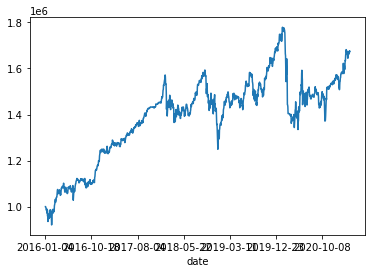

In [31]:
df_account_value.set_index('date').account_value.plot()

<a id='6.1'></a>
## 7.1 BackTestStats
pass in df_account_value, this information is stored in env class


In [32]:
print("==============Get Backtest Results===========")
now = datetime.datetime.now().strftime('%Y%m%d-%Hh%M')

perf_stats_all = backtest_stats(account_value=df_account_value)
perf_stats_all = pd.DataFrame(perf_stats_all)

==============Get Backtest Results===========
Annual return          0.103060
Cumulative returns     0.673579
Annual volatility      0.155378
Sharpe ratio           0.709960
Calmar ratio           0.412739
Stability              0.694572
Max drawdown          -0.249698
Omega ratio            1.146873
Sortino ratio          0.965346
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.890930
Daily value at risk   -0.019138
dtype: float64


<a id='6.2'></a>
## 7.2 BackTestPlot

==============Compare to DJIA===========
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (1322, 8)


Start date,2016-01-04
End date,2021-04-05
Total months,62
,Backtest
Annual return,10.356%
Cumulative returns,67.692%
Annual volatility,15.543%
Sharpe ratio,0.71
Calmar ratio,0.41
Stability,0.69
Max drawdown,-24.97%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,24.97,2020-02-06,2020-05-13,NaT,NaN
1,21.58,2018-10-03,2018-12-24,2019-10-30,281
2,13.13,2018-01-26,2018-03-23,2018-09-20,170
3,7.94,2016-01-04,2016-02-11,2016-03-01,42
4,6.72,2016-04-27,2016-06-27,2016-07-14,57


Stress Events,mean,min,max
New Normal,0.04%,-7.49%,4.64%


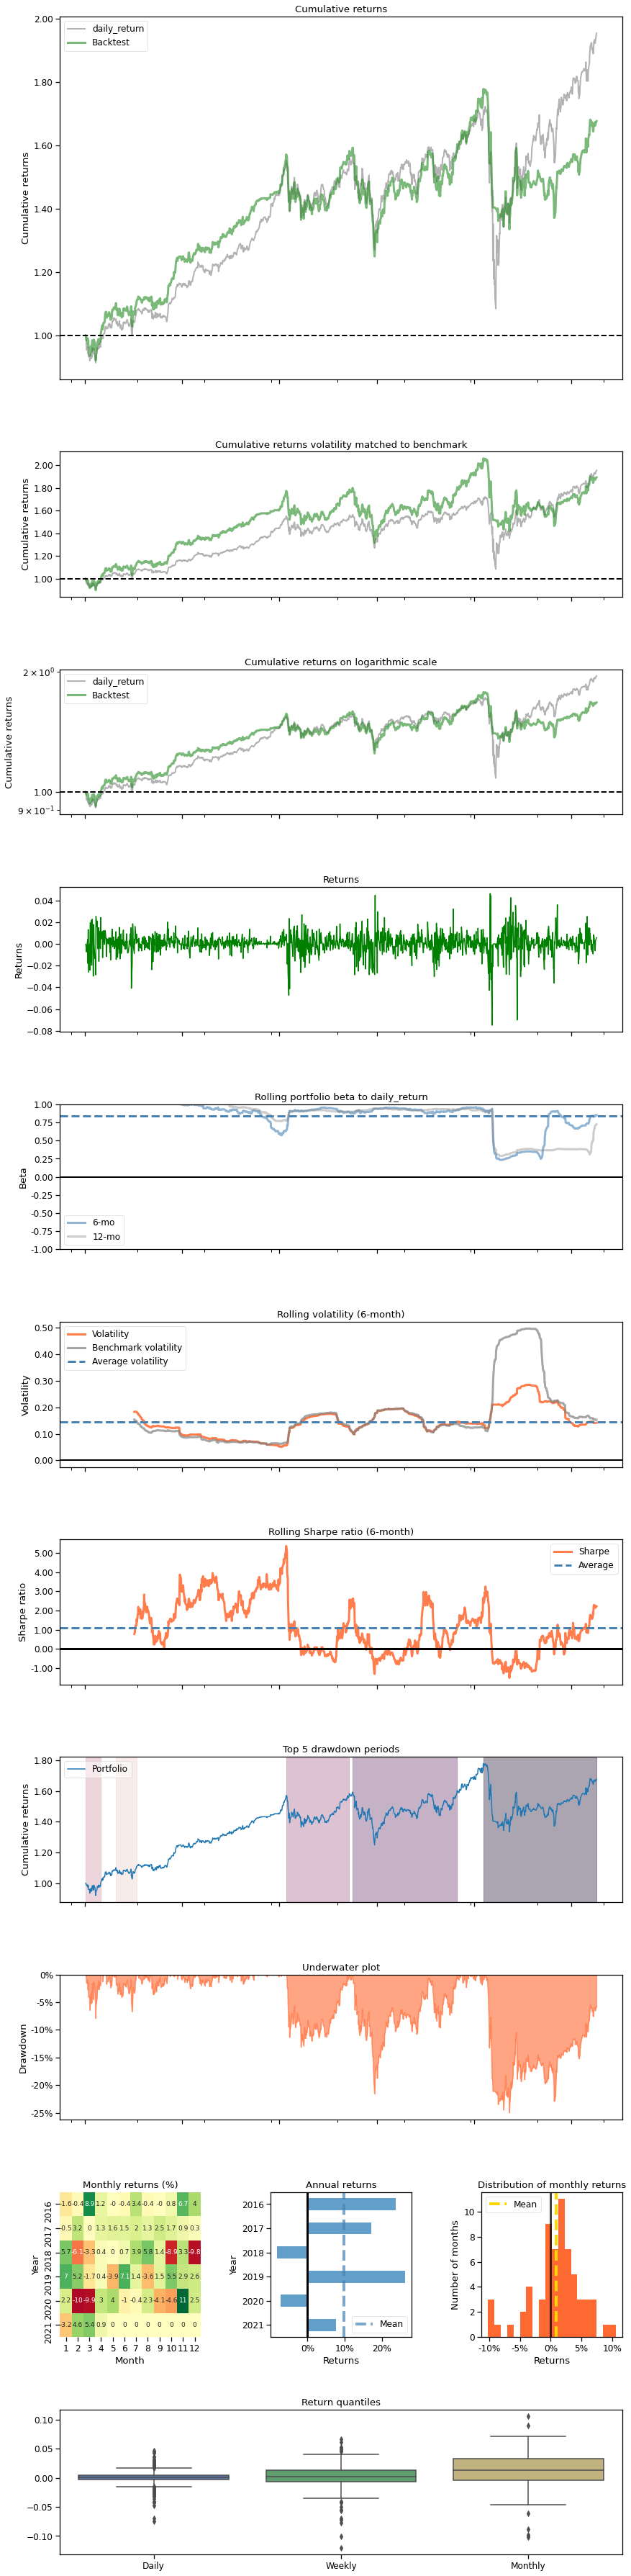

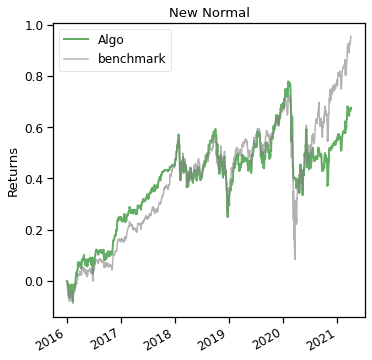

In [33]:
print("==============Compare to DJIA===========")
%matplotlib inline
backtest_plot(df_account_value, 
             baseline_ticker = '^DJI', 
             baseline_start = df_account_value.loc[0,'date'],
             baseline_end = df_account_value.loc[len(df_account_value)-1,'date'])

<a id='6.3'></a>
## 7.3 Baseline Stats

In [34]:
print("==============Get Baseline Stats===========")
baseline_perf_stats=get_baseline('^DJI',
                                  baseline_start = df_account_value.loc[0,'date'],
                                  baseline_end = df_account_value.loc[len(df_account_value)-1,'date'])

==============Get Baseline Stats===========


TypeError: get_baseline() got an unexpected keyword argument 'baseline_start'